<img src="https://i1.sndcdn.com/avatars-000274765548-vj7h0w-t500x500.jpg" style='float:right; width:200px; margin: 0 20px;'>

<img src="https://cdn2.iconfinder.com/data/icons/popular-social-media-flat/48/Popular_Social_Media-11-512.png" style='float:right; width:200px; margin: 0 20px;'>


# Twitter V CMV topological differences --> CMV
---

> Create feature set for CMV and Twitter 

> Do comperative analysis of features

In [1]:
# env 
import sys
sys.path.append('/Users/shaimeital/code/thesis/conversant')
sys.path.append('/Users/shaimeital/code/thesis/cmv-stance-classification')


In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import glob
import os

import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

In [3]:
from conversant.conversation.examples.controversial_feature_extraction import *
from conversant.conversation\
    .conversation_utils import conversation_to_dataframe
from stance_classification.twitter_conversation_parser import TwitterConversationReader

from stance_classification.classifiers.maxcut_stance_classifier import MaxcutStanceClassifier

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [40]:
import matplotlib.pyplot as plt

## Load Raw Data

In [5]:
trees_file_path = './trees_2.0.txt'
total_trees = sum(1 for _ in iter_trees_from_lines(trees_file_path))

print(f'loaded total of {total_trees}')

loaded total of 16306


## Transform to Conversation object and to feature set

In [6]:
trees = tqdm(iter_trees_from_lines(trees_file_path), total=total_trees)

In [7]:
conv_reader = CMVConversationReader()
conversations = map(conv_reader.parse, trees)
sub_convs = (Conversation(child) for conv in conversations for child in conv.root.children)
sub_convs = filter(lambda c: c.size >= 5, sub_convs)

In [10]:
conversations_ = list(conversations)

In [11]:
convs = pd.concat(conversation_to_dataframe(conv) for conv in conversations_)

In [12]:
convs.groupby('conversation_id')['data.id'].count().mean()

42.1425855513308

In [13]:
convs.groupby('conversation_id')['depth'].nunique().mean()

6.942413835398013

In [14]:
convs.depth.mean()

4.925982679862685

In [8]:
#data = pd.concat(conversation_to_dataframe(conv) for conv in sub_convs)
conversations = list(conversations)

## EDA

### Mean branch participation for user in CMV
remove op and show that most users in a conversation only participaten in one branch

In [ ]:
roots = convs.loc[convs.is_root == True][['author', 'full_conv_id']]
roots

In [ ]:
def conversattion_to_dataframe_filter_root(conv):
    conv = conversation_to_dataframe(conv)
    full_conv_id = conv.full_conv_id[:1].values[0]
    root_author_name = roots.loc[roots.full_conv_id == full_conv_id].author.values[0]
    return conv.loc[conv.author != root_author_name]

In [ ]:
# data = pd.concat(conversattion_to_dataframe_filter_root(conv) for conv in sub_convs)

In [ ]:
data = convs

In [ ]:
user_participation=pd.DataFrame(data.groupby(['author', 'conversation_id']).timestamp.count())\
                    .rename({'timestamp': '#participation'}, axis=1)
user_participation.head()

In [ ]:
mean_branch_participation = pd.DataFrame(user_participation.groupby('author')['#participation'].mean()).\
                            rename({'#participation': 'mean_branch_participation'}, axis=1)
mean_branch_participation.head()

In [ ]:
bins = [0,1,2,3,4,5,6,7,8,9,72]

In [ ]:
mean_branch_participation['mean_par_bin'] = pd.cut(mean_branch_participation.mean_branch_participation, bins=bins)

In [ ]:
mean_branch_participation

In [ ]:
mean_branch_participation.describe()

In [ ]:
bin_participation = mean_branch_participation.groupby('mean_par_bin').count()
bin_participation

In [ ]:
bin_participation = bin_participation.reset_index()
bin_participation

In [ ]:
bin_participation.mean_branch_participation.sum()

In [ ]:
percen = bin_participation.mean_branch_participation.apply(lambda x: x / 37264)

In [ ]:
bin_participation = bin_participation.assign(perc = percen)
bin_participation

In [ ]:
_, ax = plt.subplots(figsize=(14,6))
sns.set_style("whitegrid")
ax = sns.barplot(data=bin_participation, x = 'mean_par_bin', y= 'perc', palette="deep")
plt.ylabel('percentage of twitter users')
plt.xlabel('mean participation bin')

## Some Feature Extraction

In [ ]:
# example of one branch 
conv = data.loc[data.conversation_id == 'dq95b41']
conv

In [ ]:
def count_op_involvment(subconv:pd.DataFrame, roots:pd.DataFrame) -> float:
    """
    counts the proportion of posts from the full conversation author in the subconversation
    """
    full_conversation_id = subconv.sample(1).full_conv_id.values[0]
    op = roots.loc[roots.full_conv_id == full_conversation_id].author.values[0]
    return len(subconv.loc[subconv.author == op]) / len(subconv)

In [ ]:
count_op_involvment(conv, roots)

In [ ]:
# max branch depth 
def max_branch_depth(conv:pd.DataFrame) -> int:
    return conv.depth.max()

In [ ]:
max_branch_depth(conv)

In [ ]:
# apply two features to all of the sub-conversations 
op_involvment = data.groupby('conversation_id').apply(lambda x: count_op_involvment(x, roots))

In [ ]:
op_involvment.value_counts()

In [ ]:
op_involvment_ = pd.DataFrame(op_involvment).rename({0:'op_involvment'}, axis=1)
op_involvment_

In [ ]:
feature_set = data.merge(op_involvment_, how='left', on = 'conversation_id')

## Running MAXCUT

6kn9gy


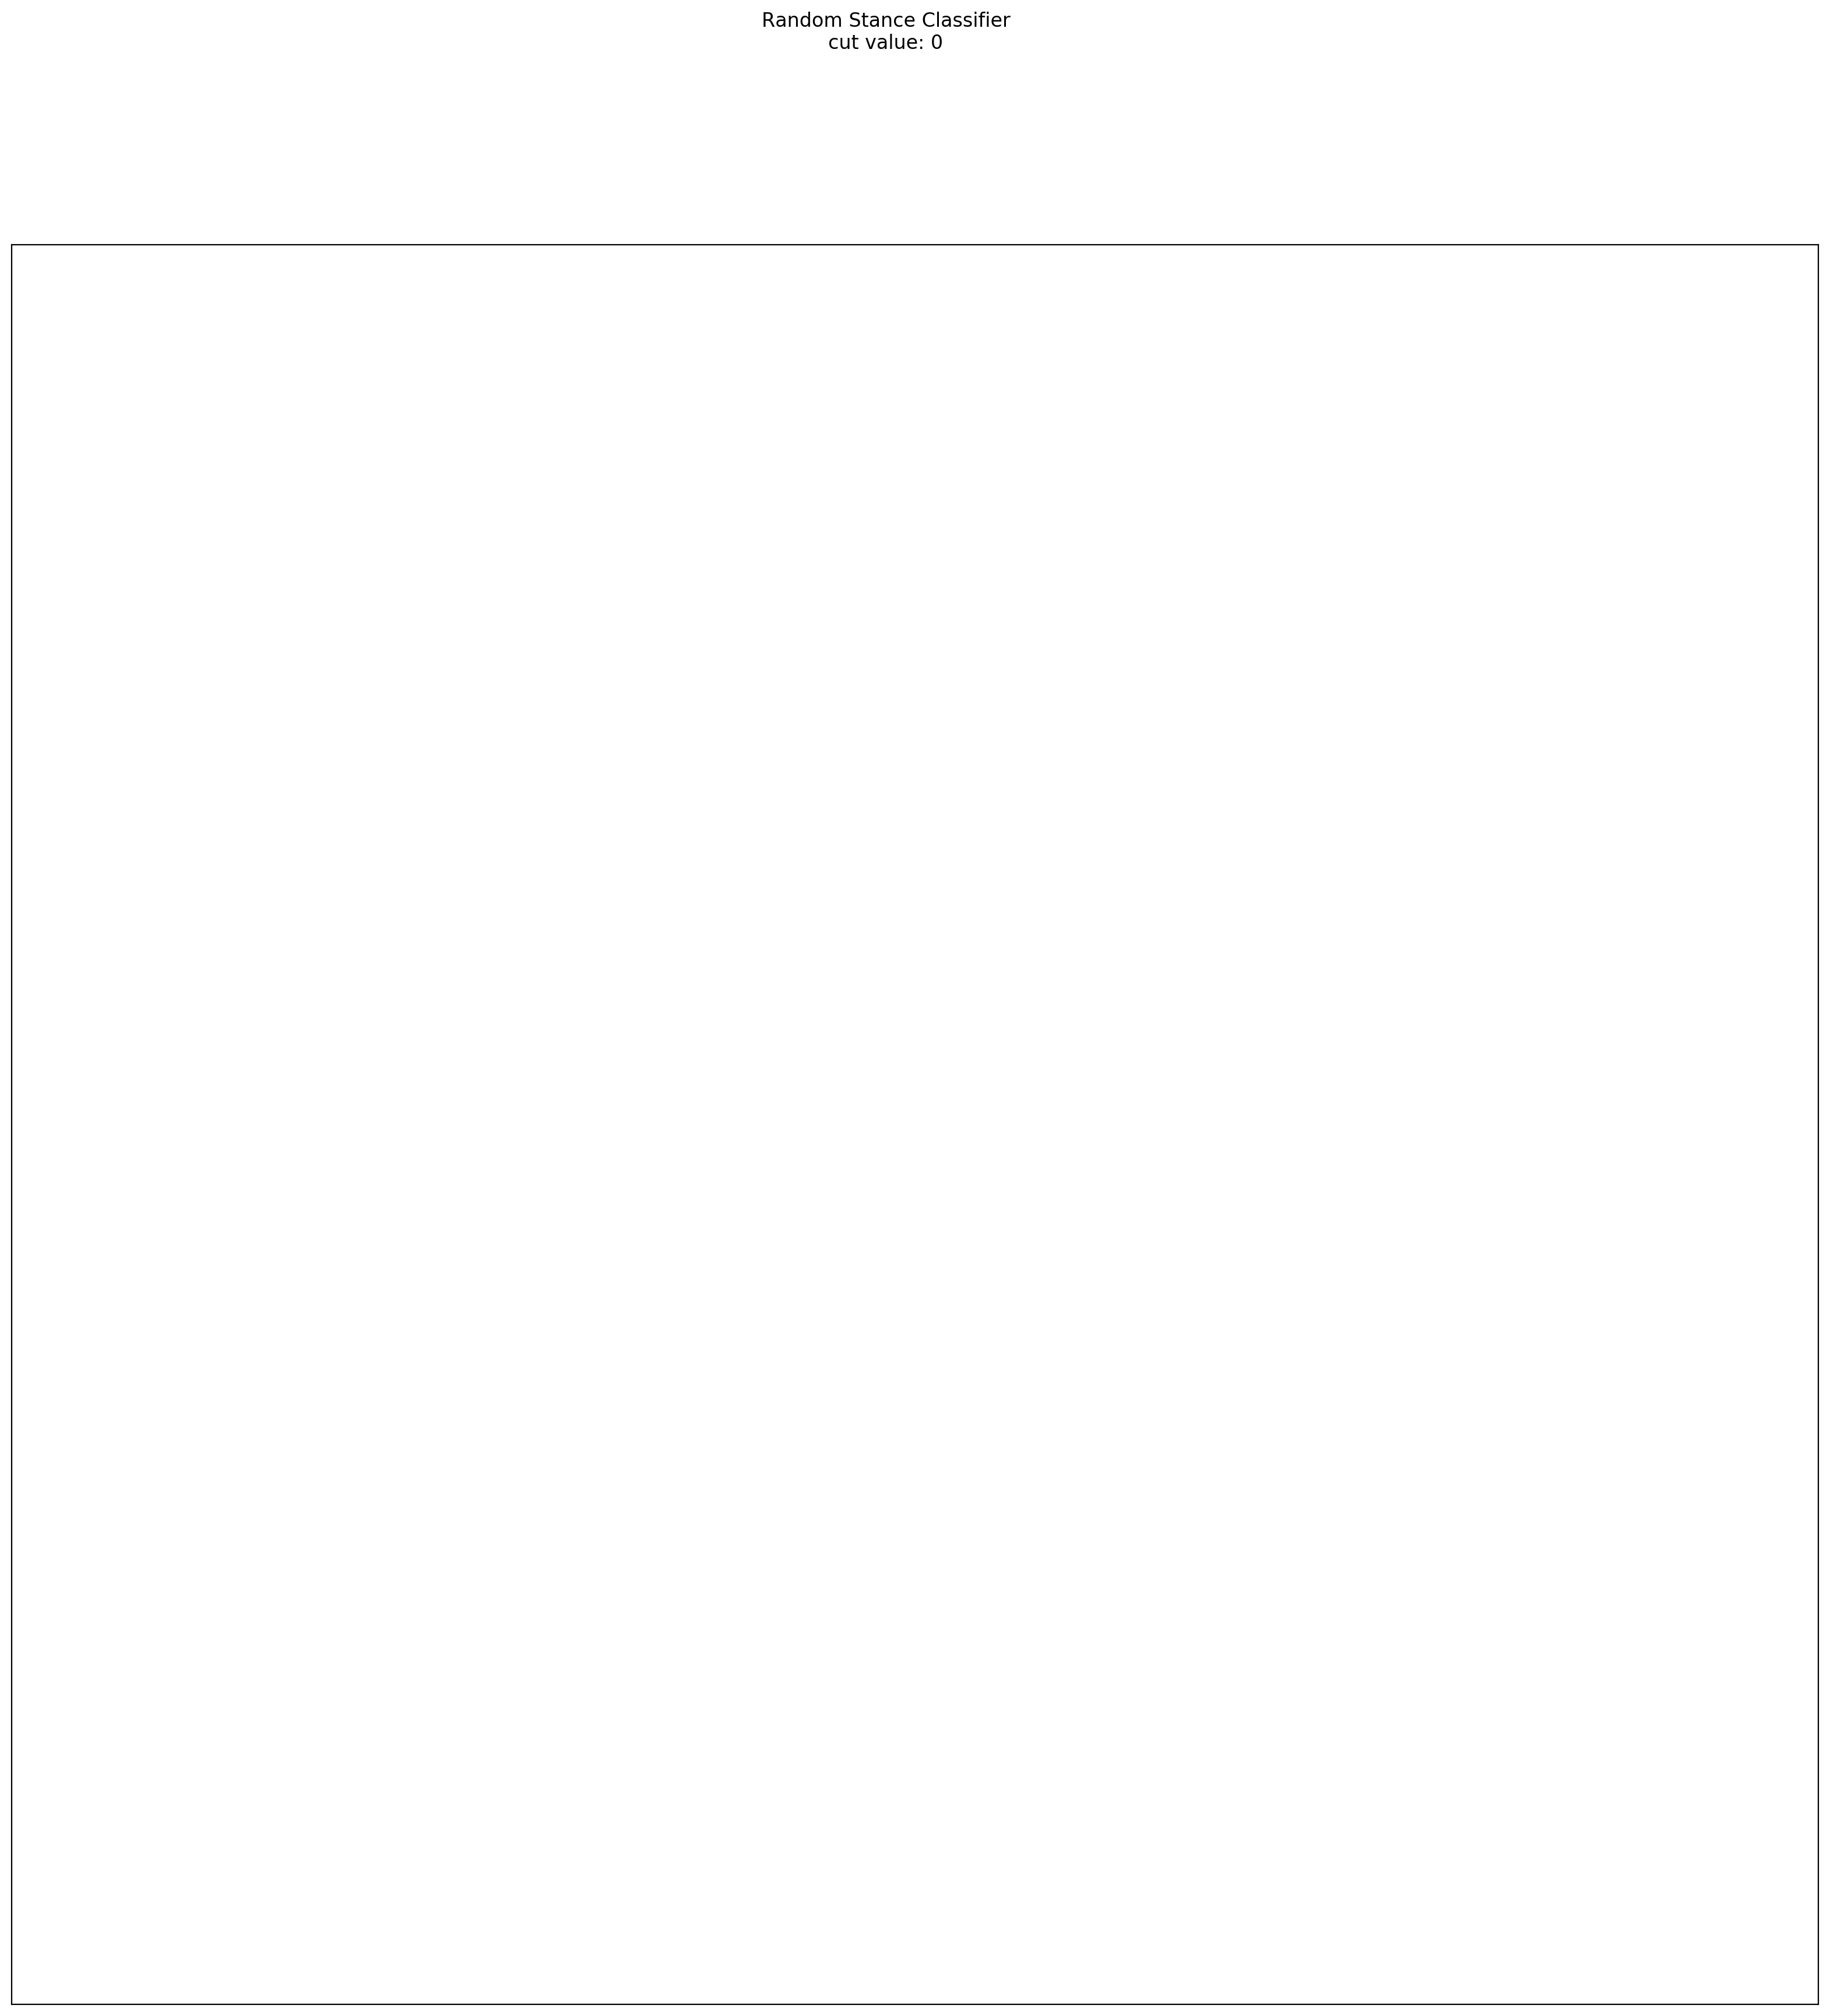

7f53sk


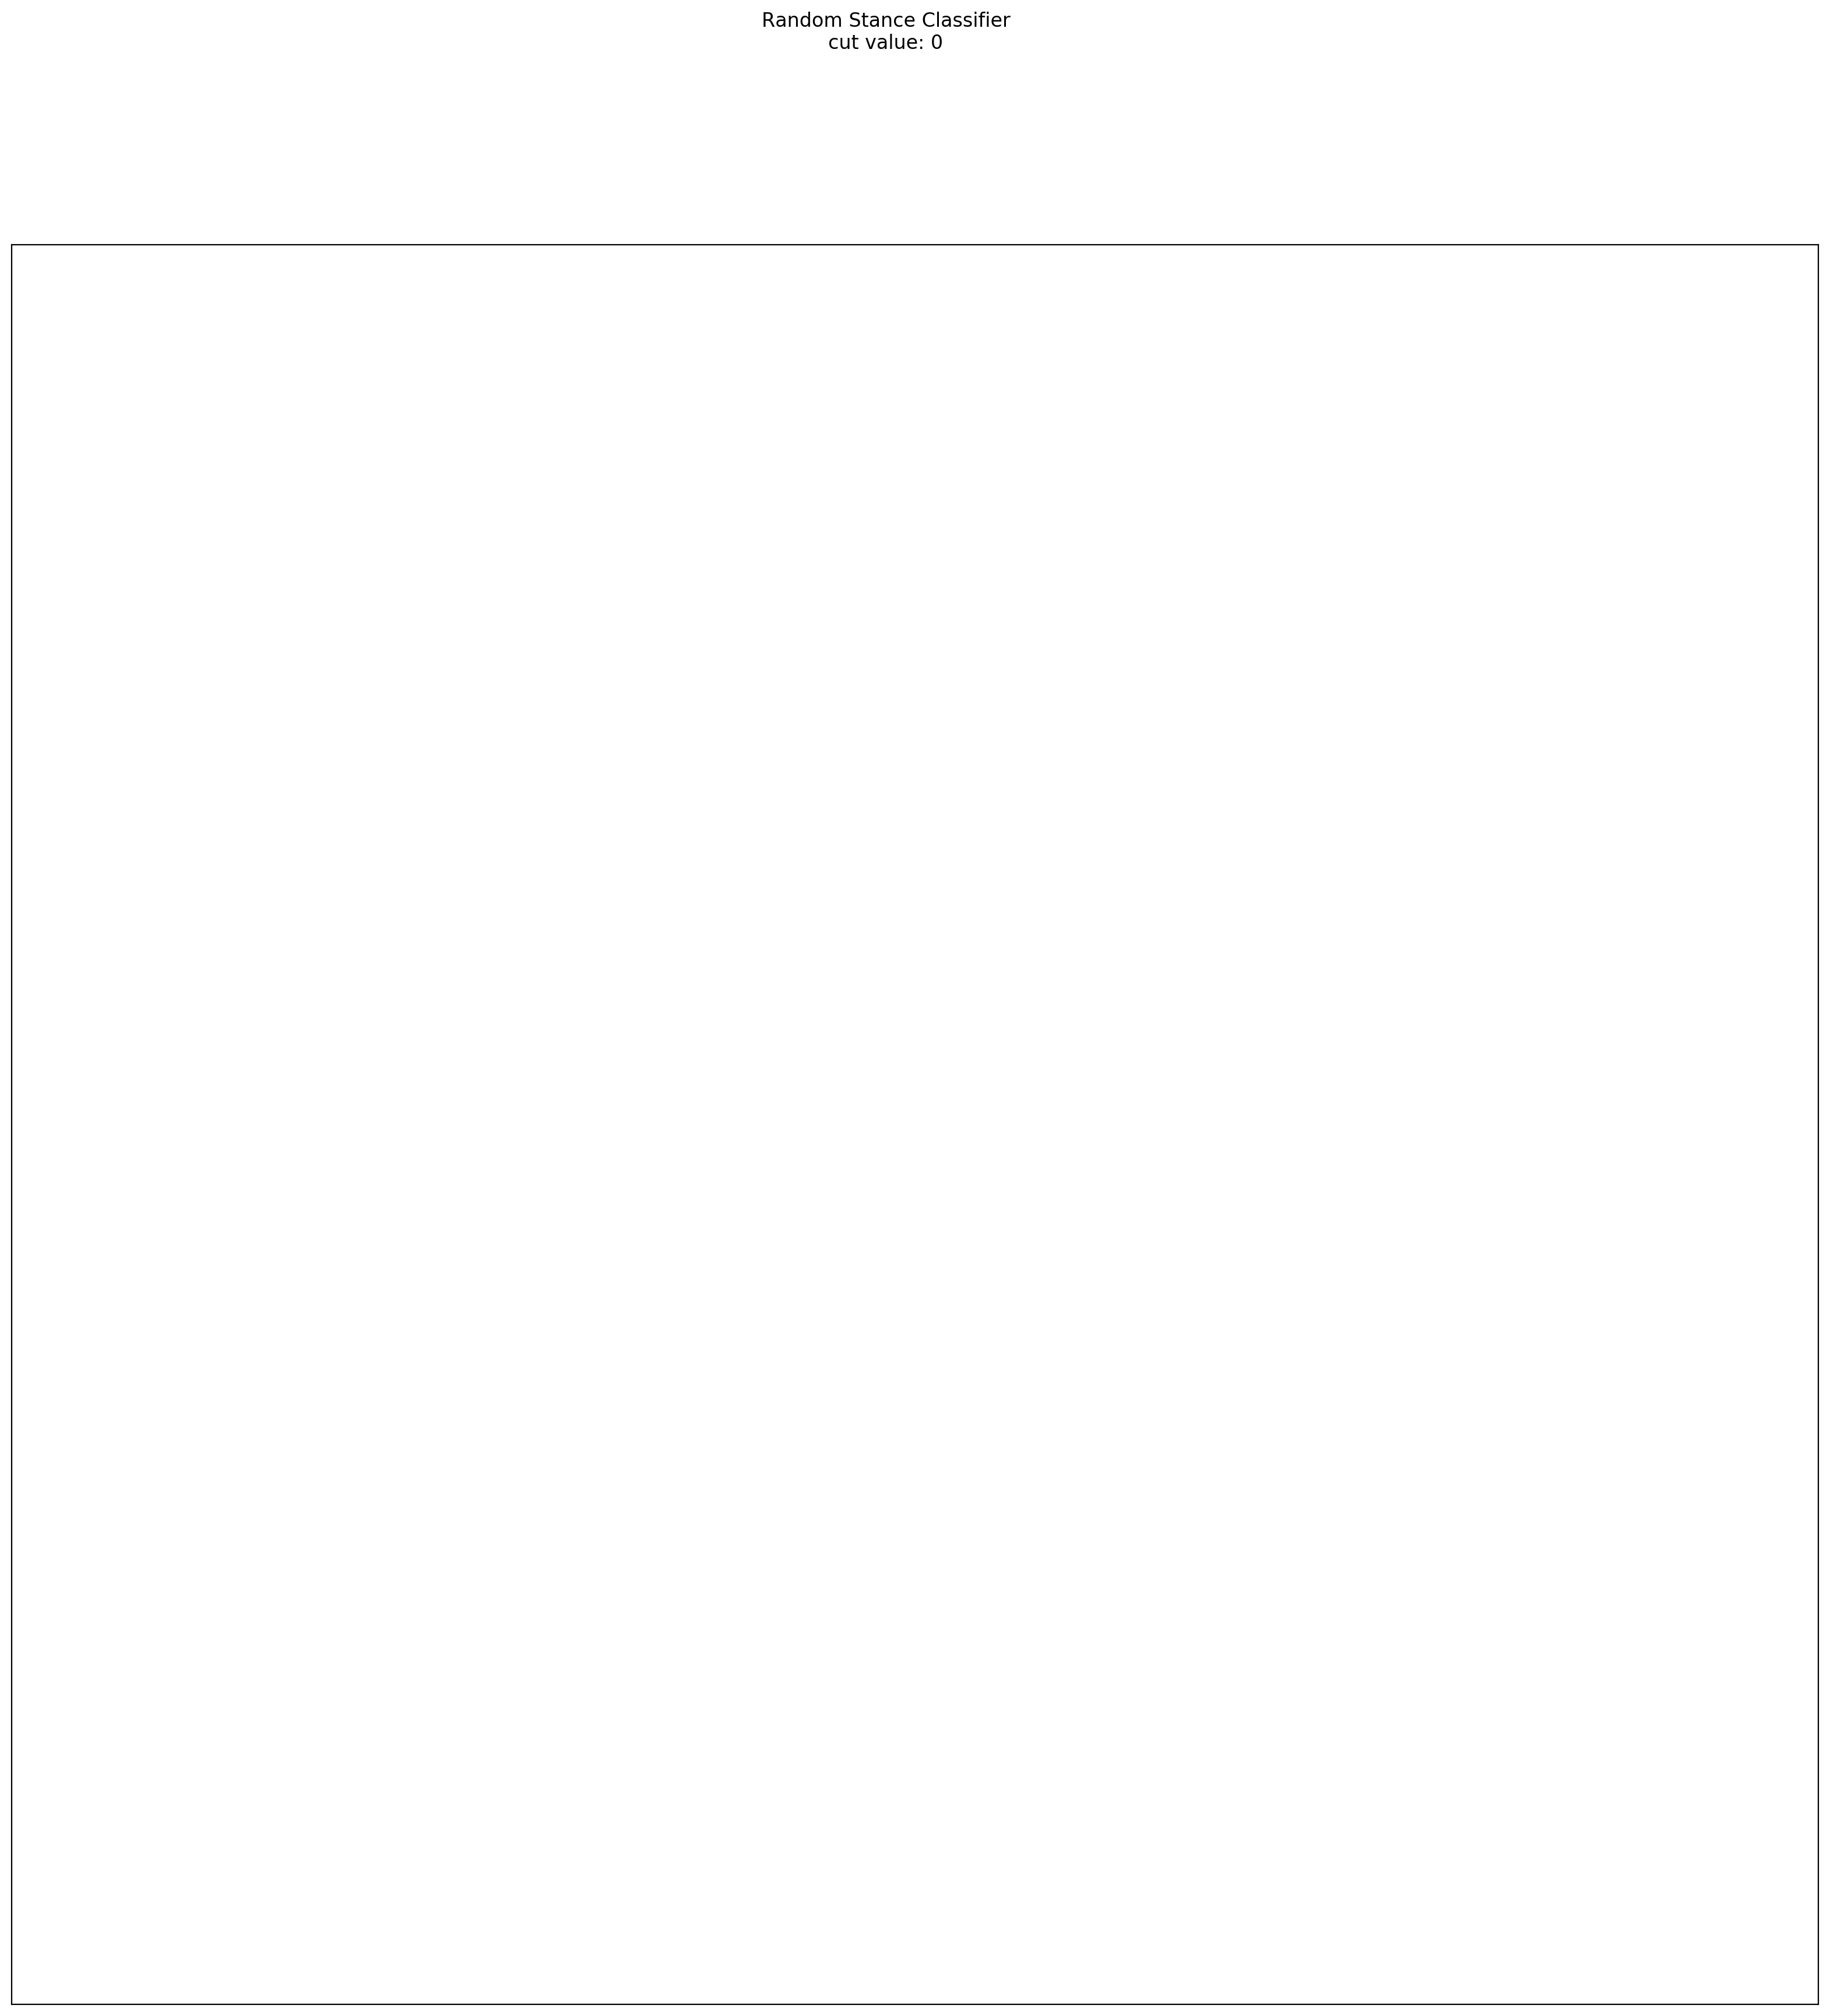

6ozbfi


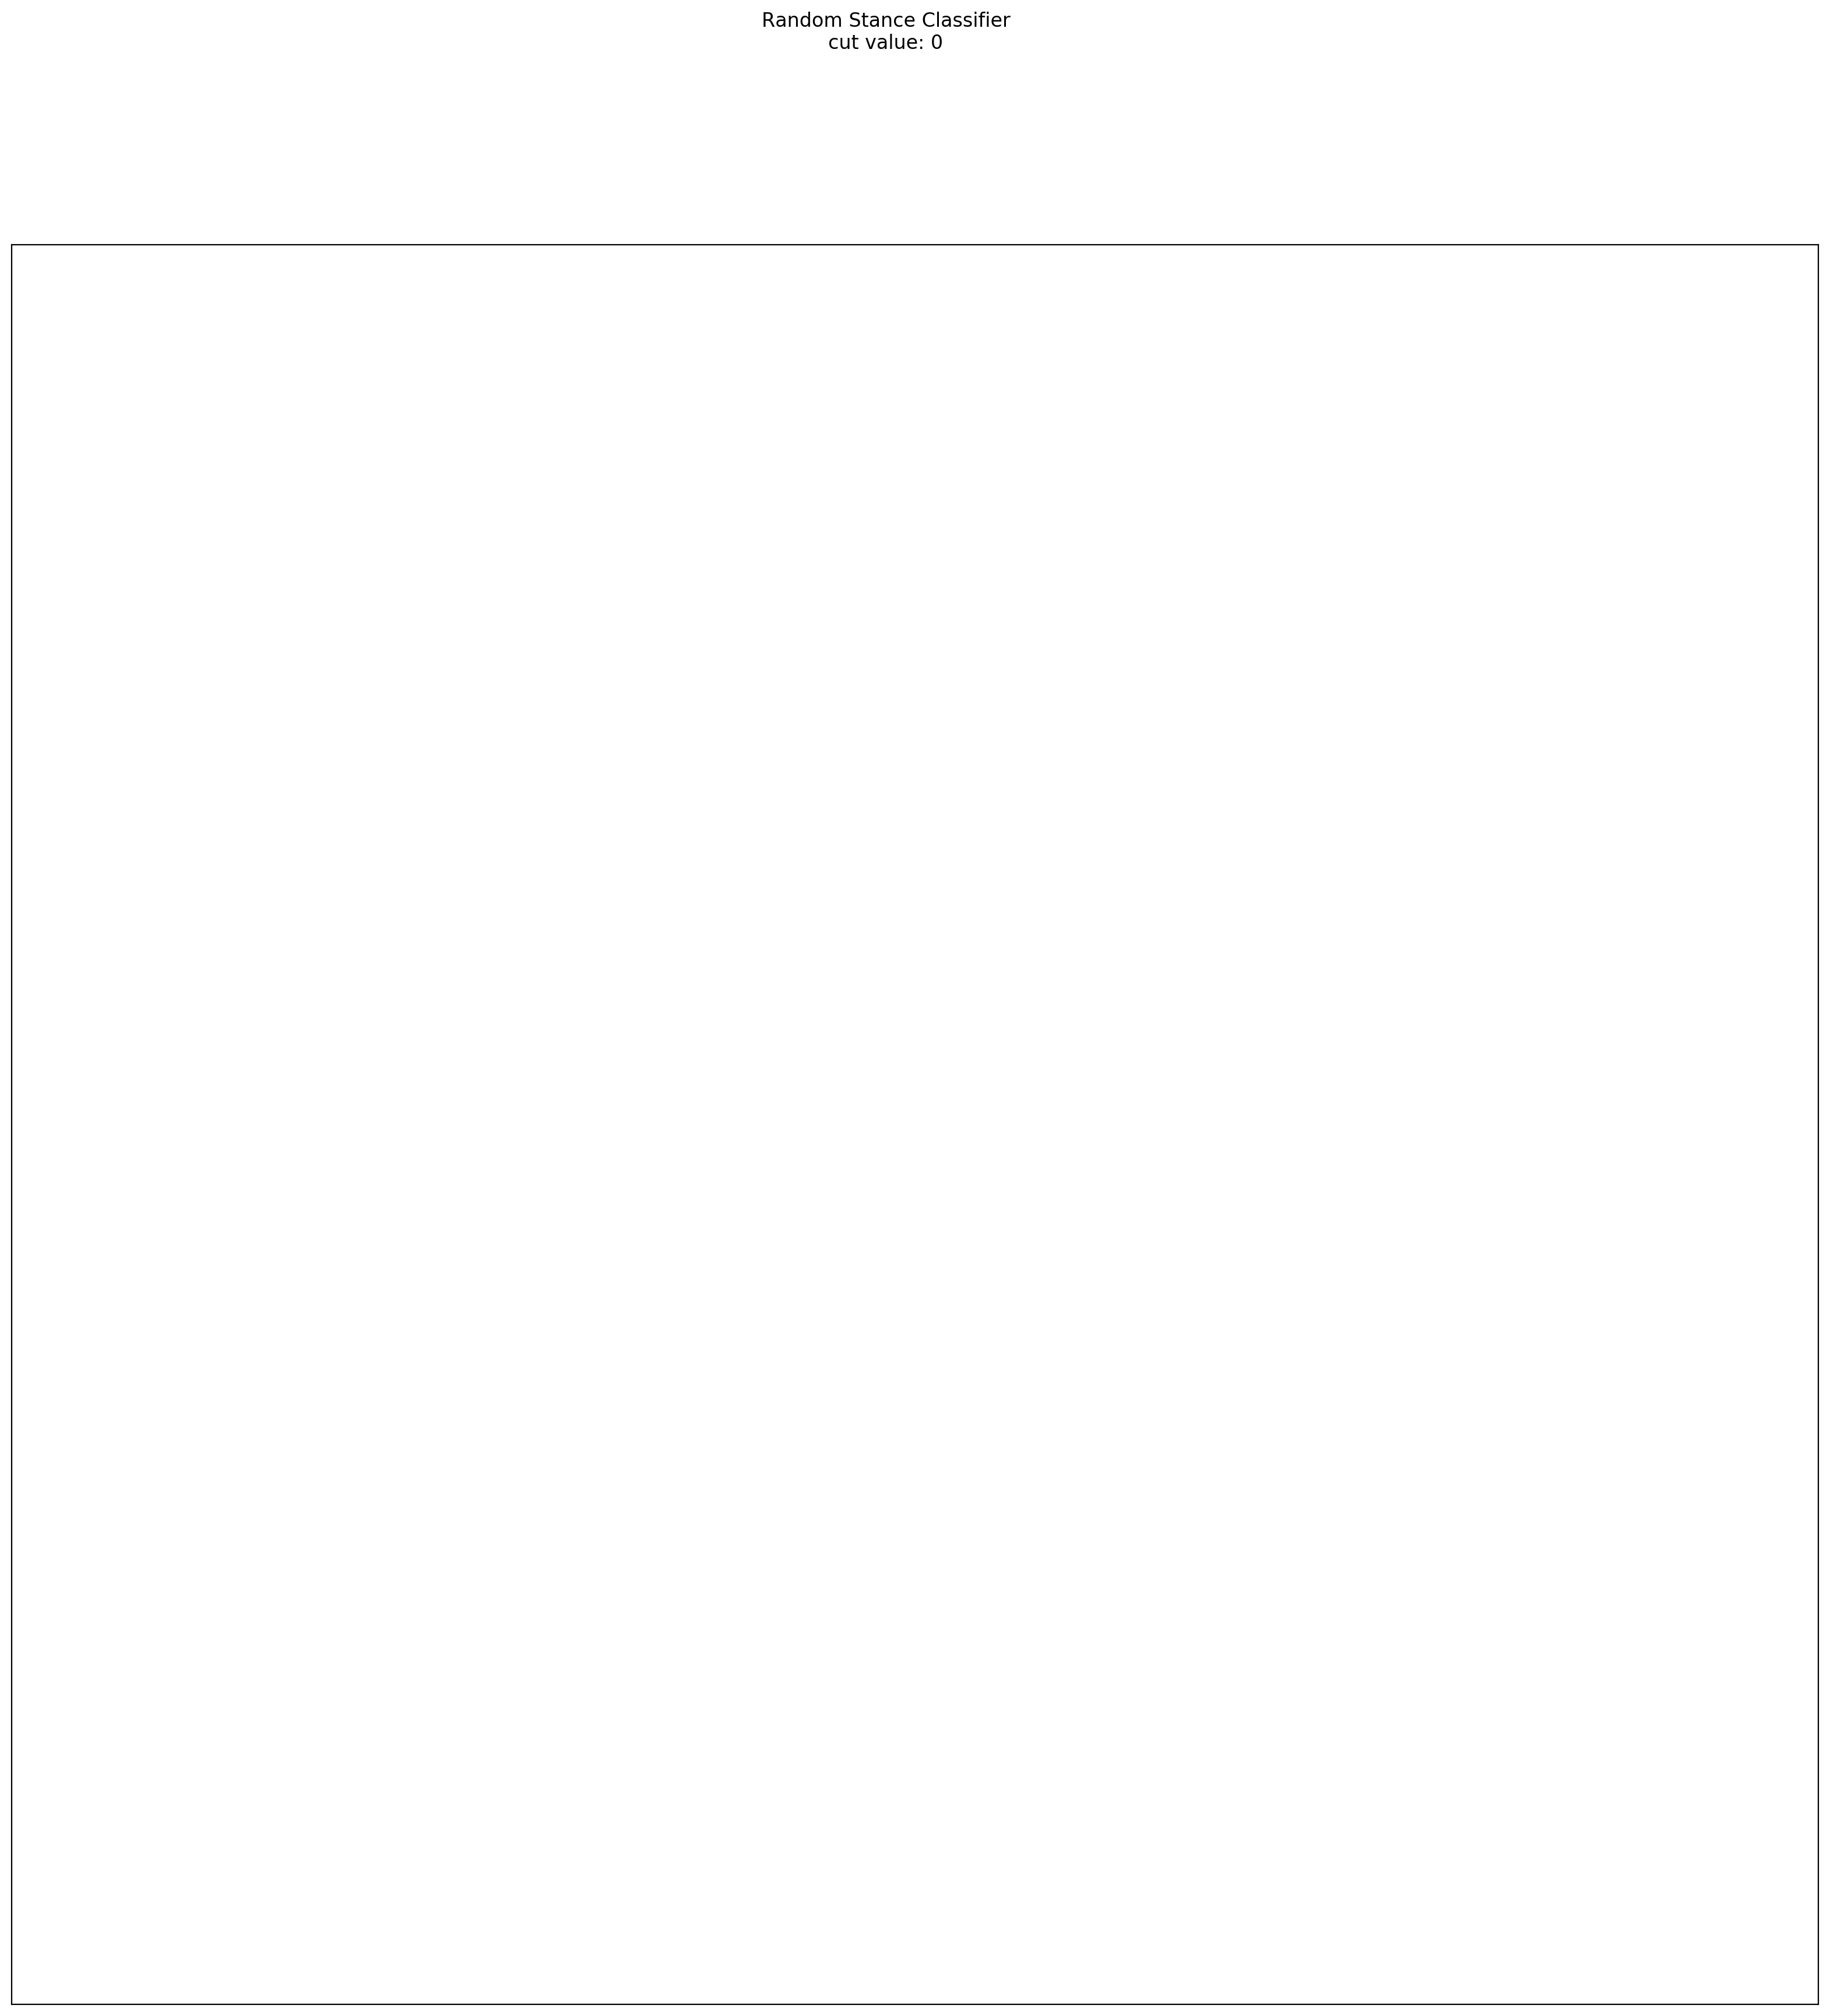

7f30fw


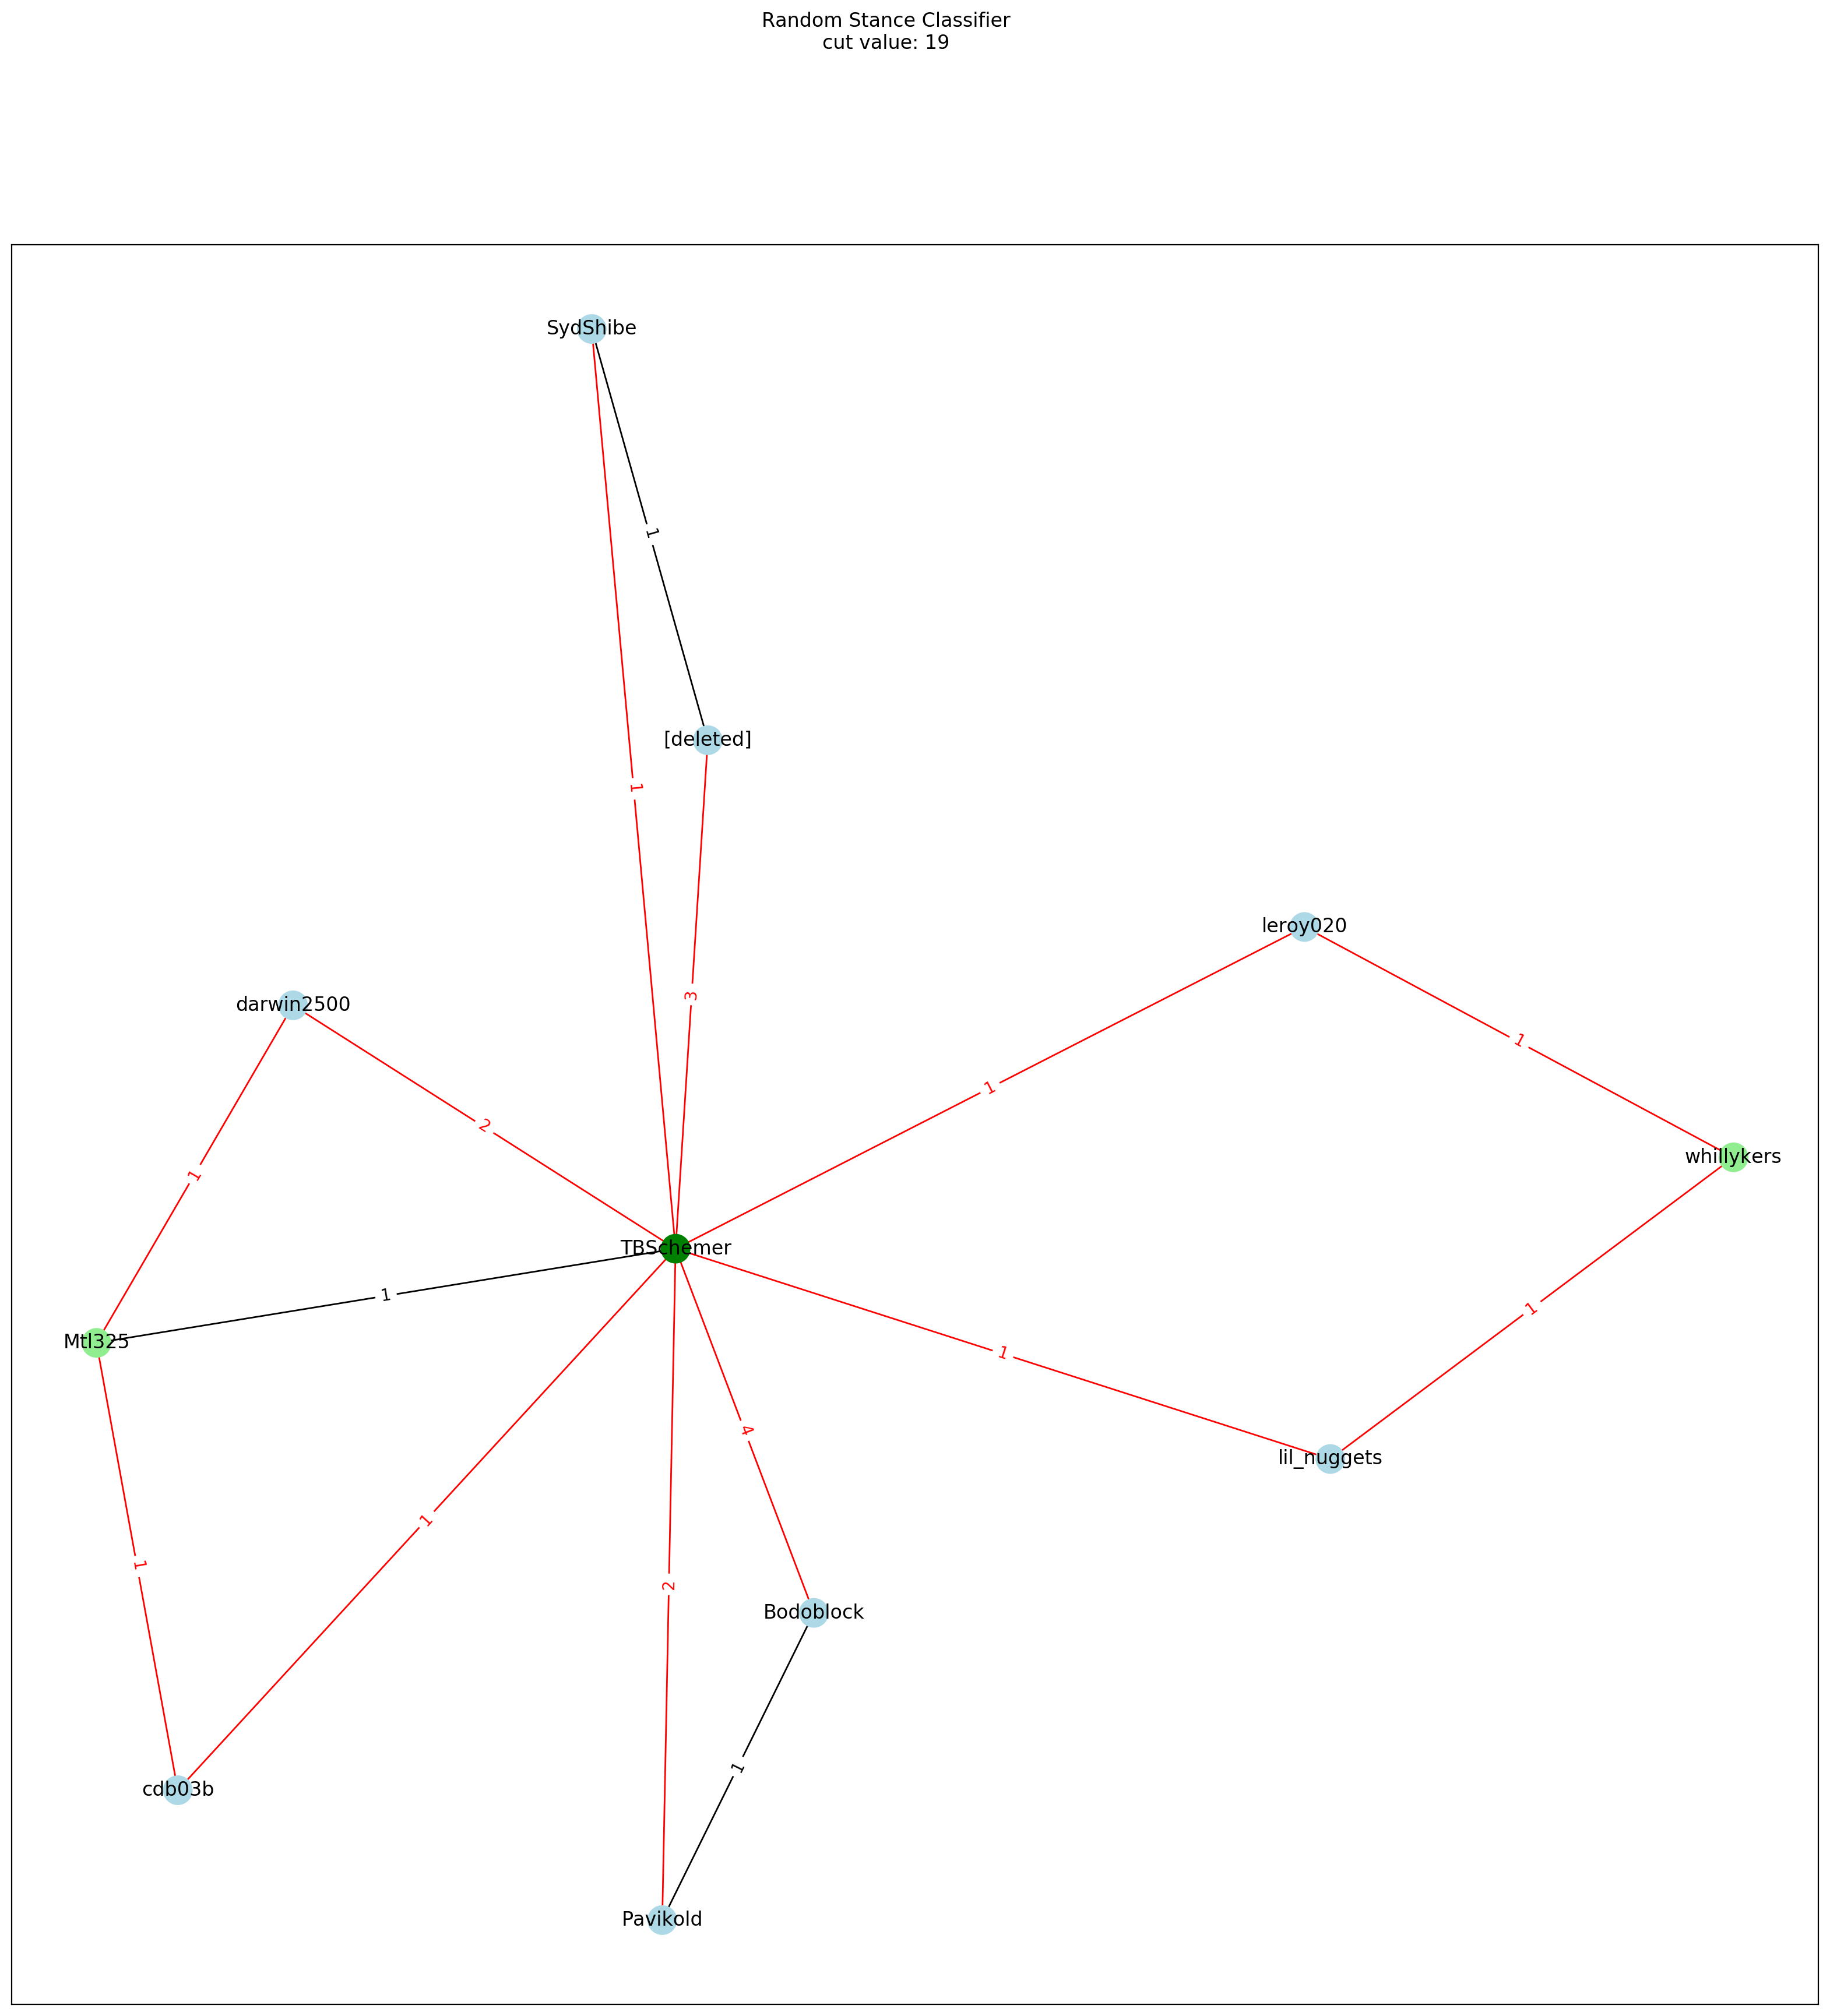

6g7ct0


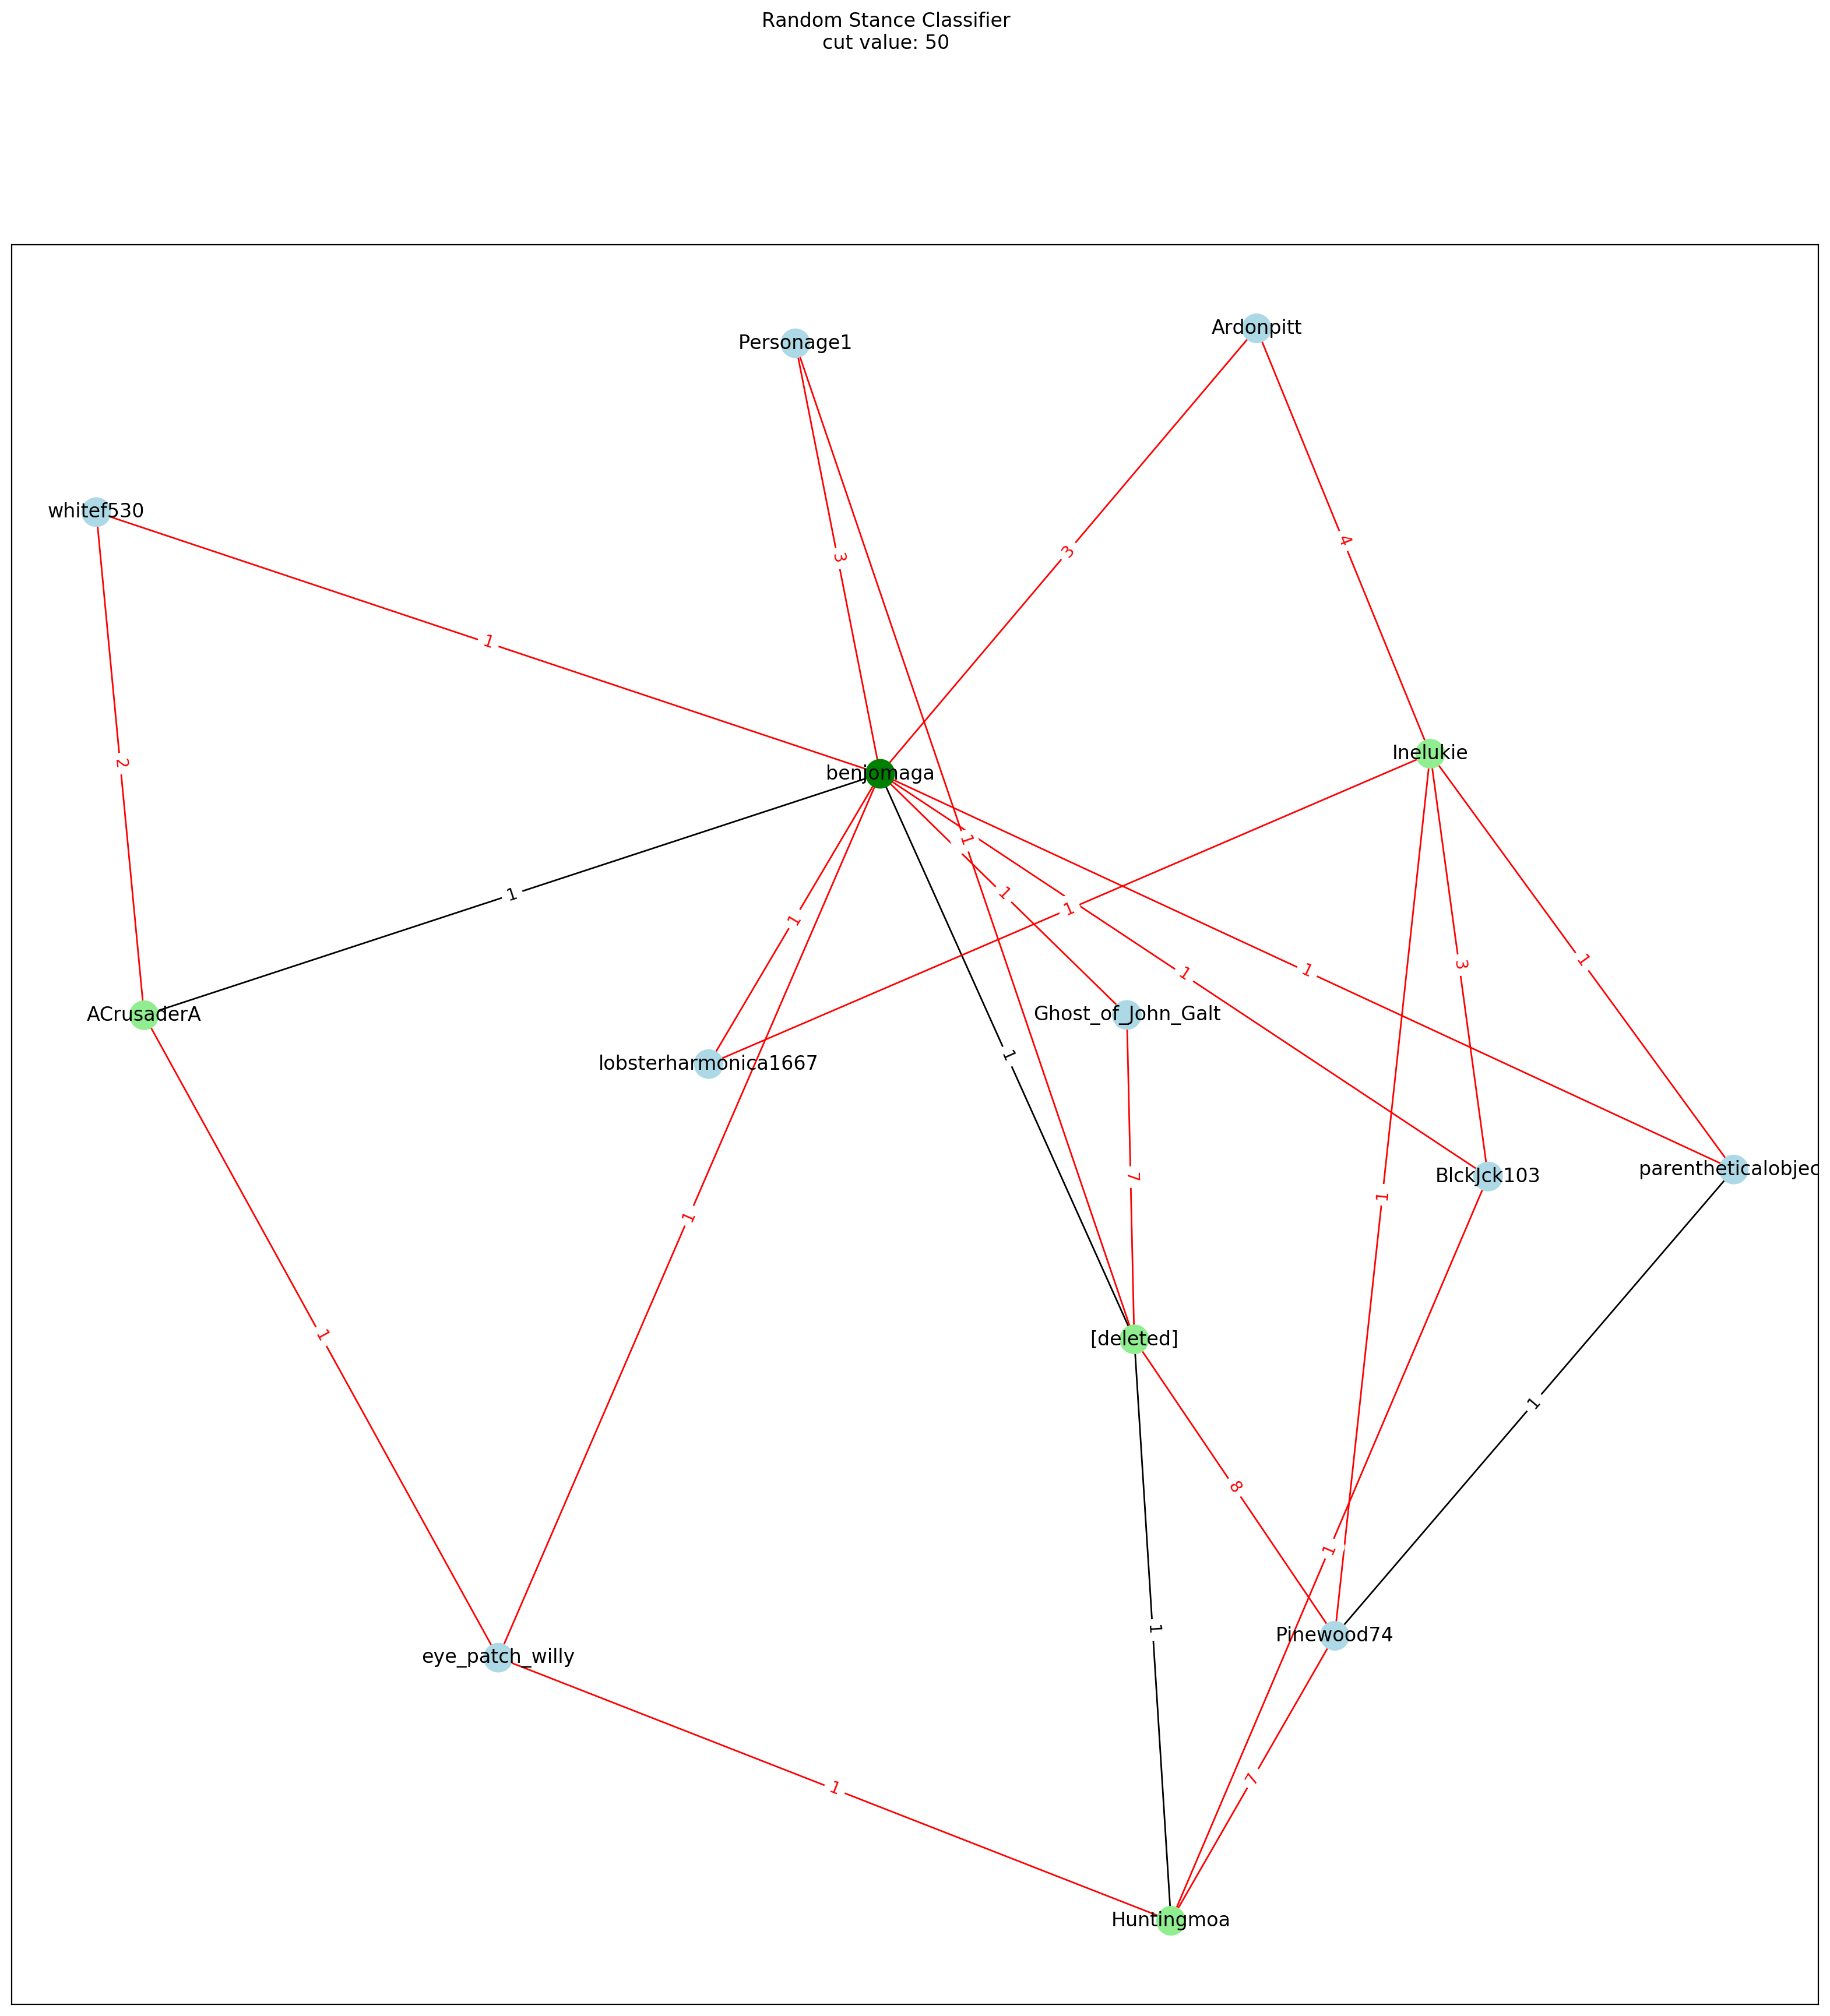

715i08


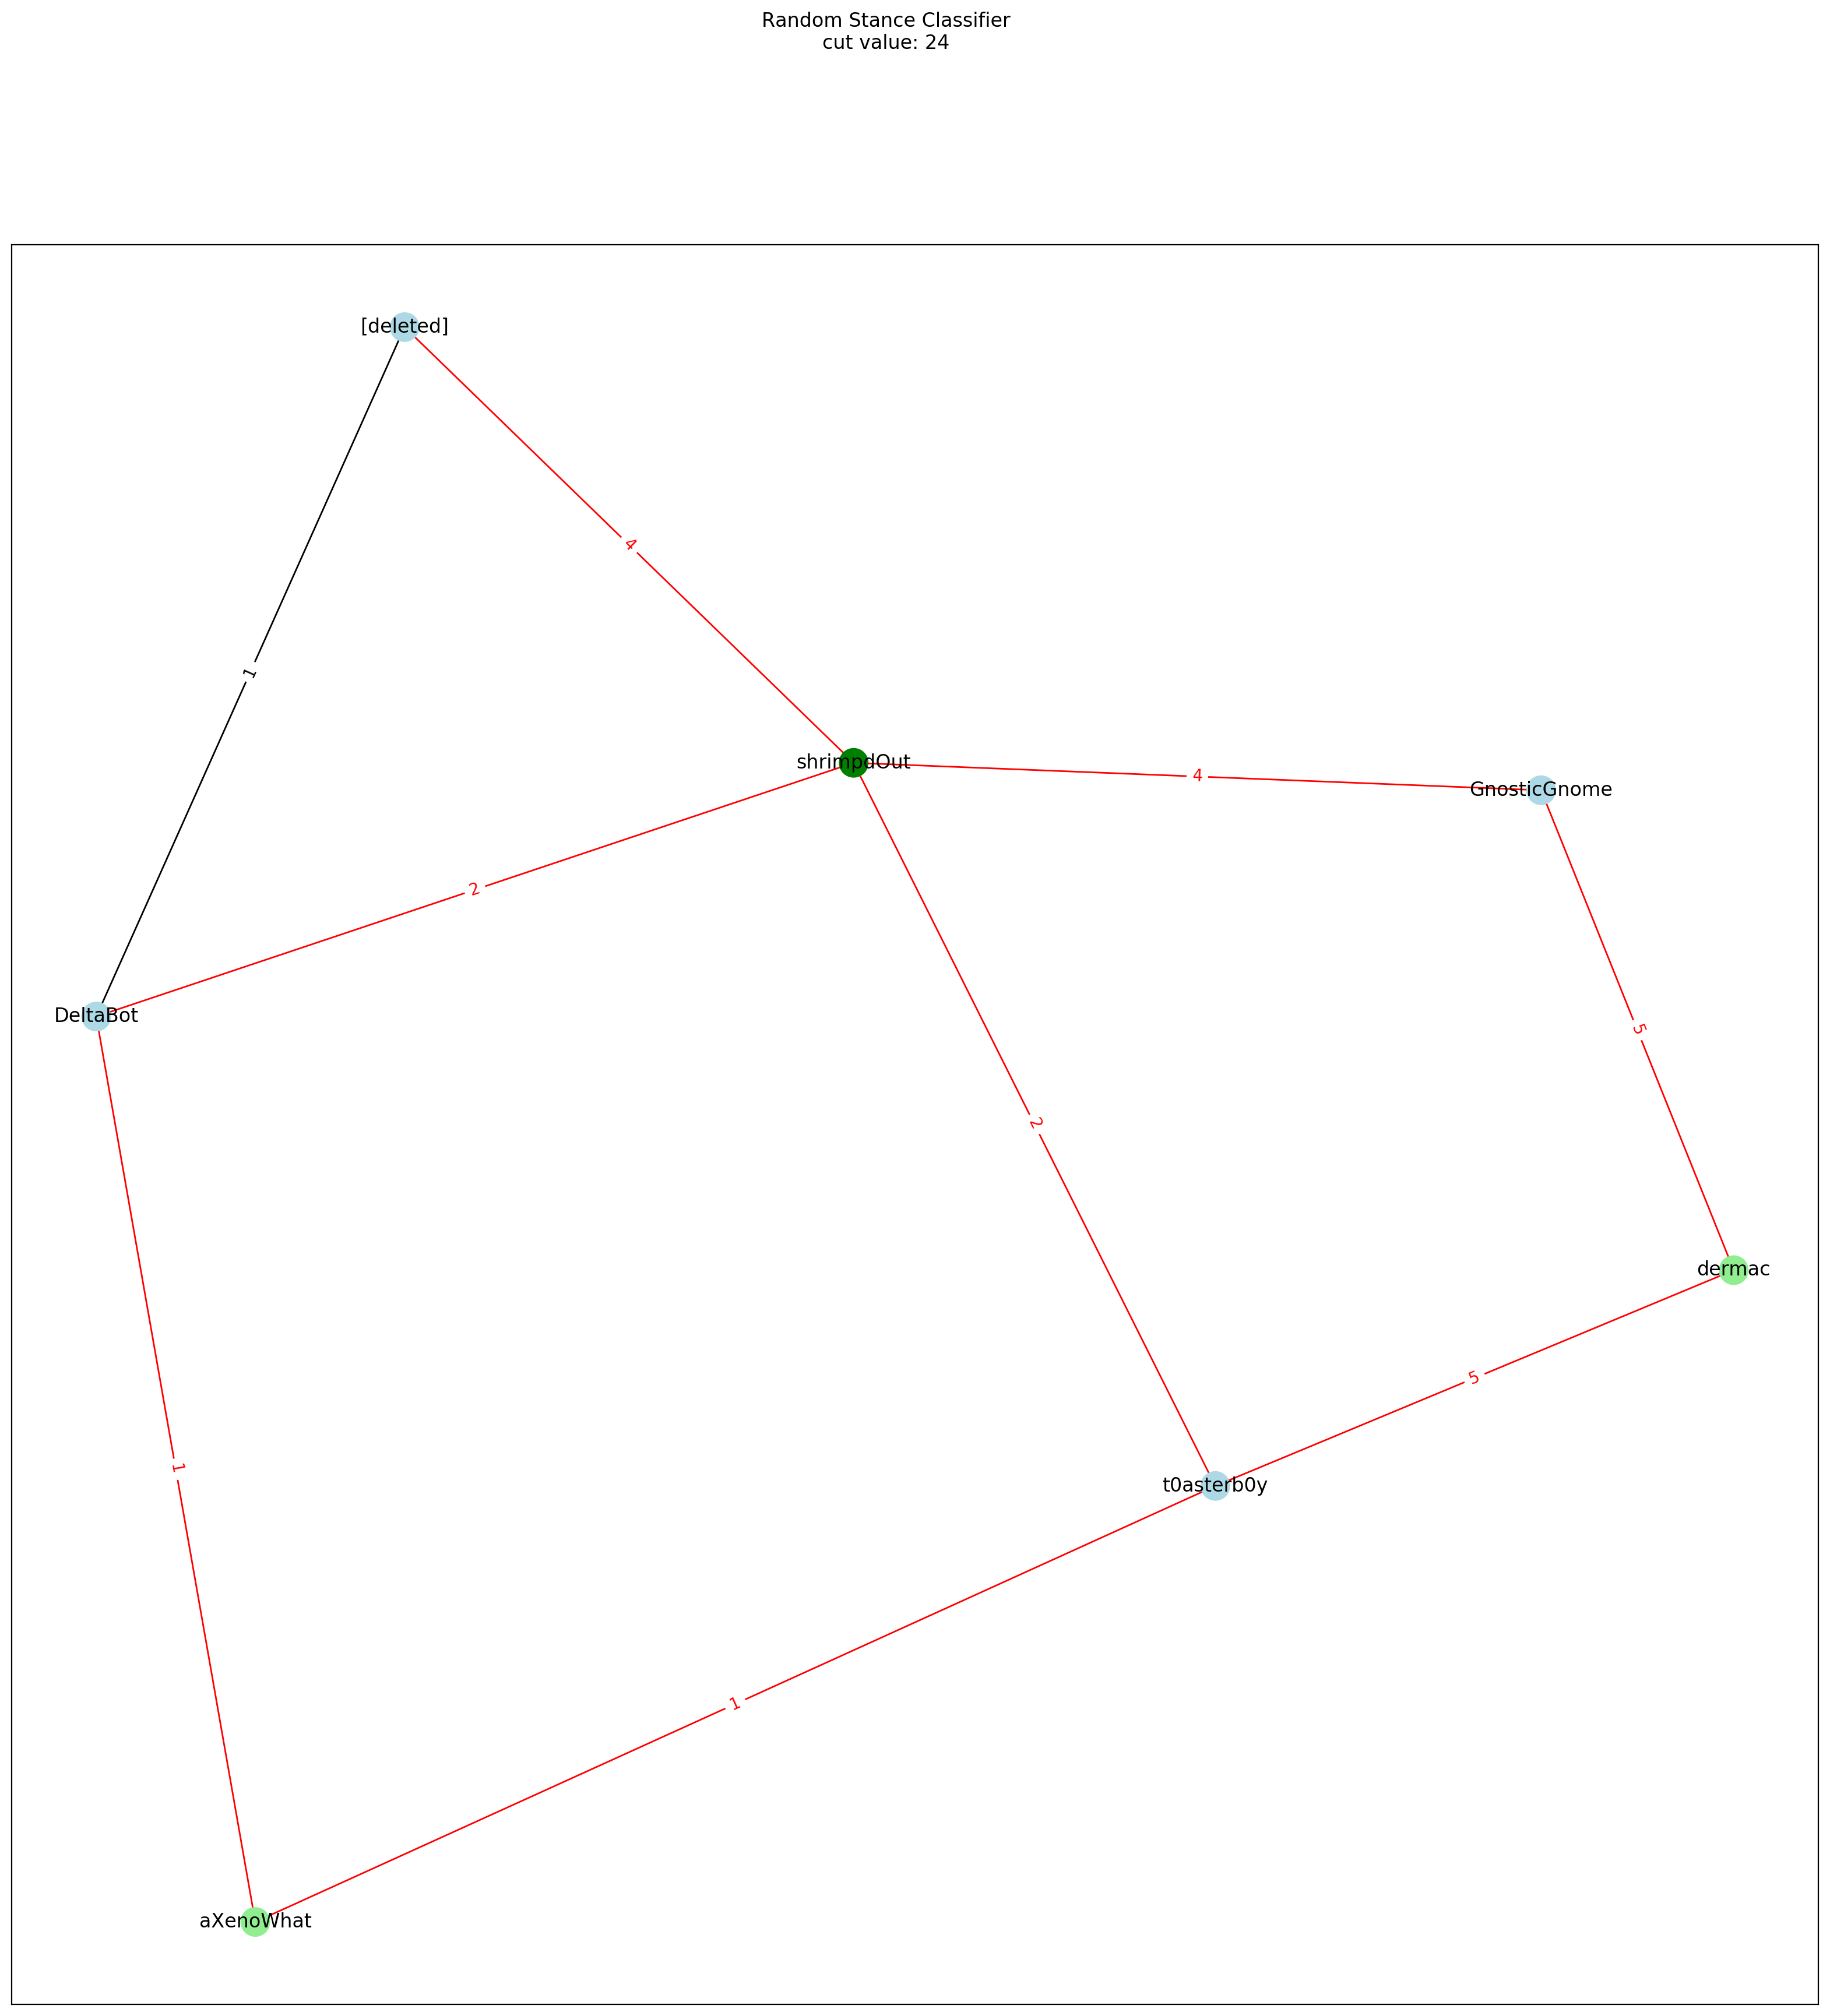

5u8mnq


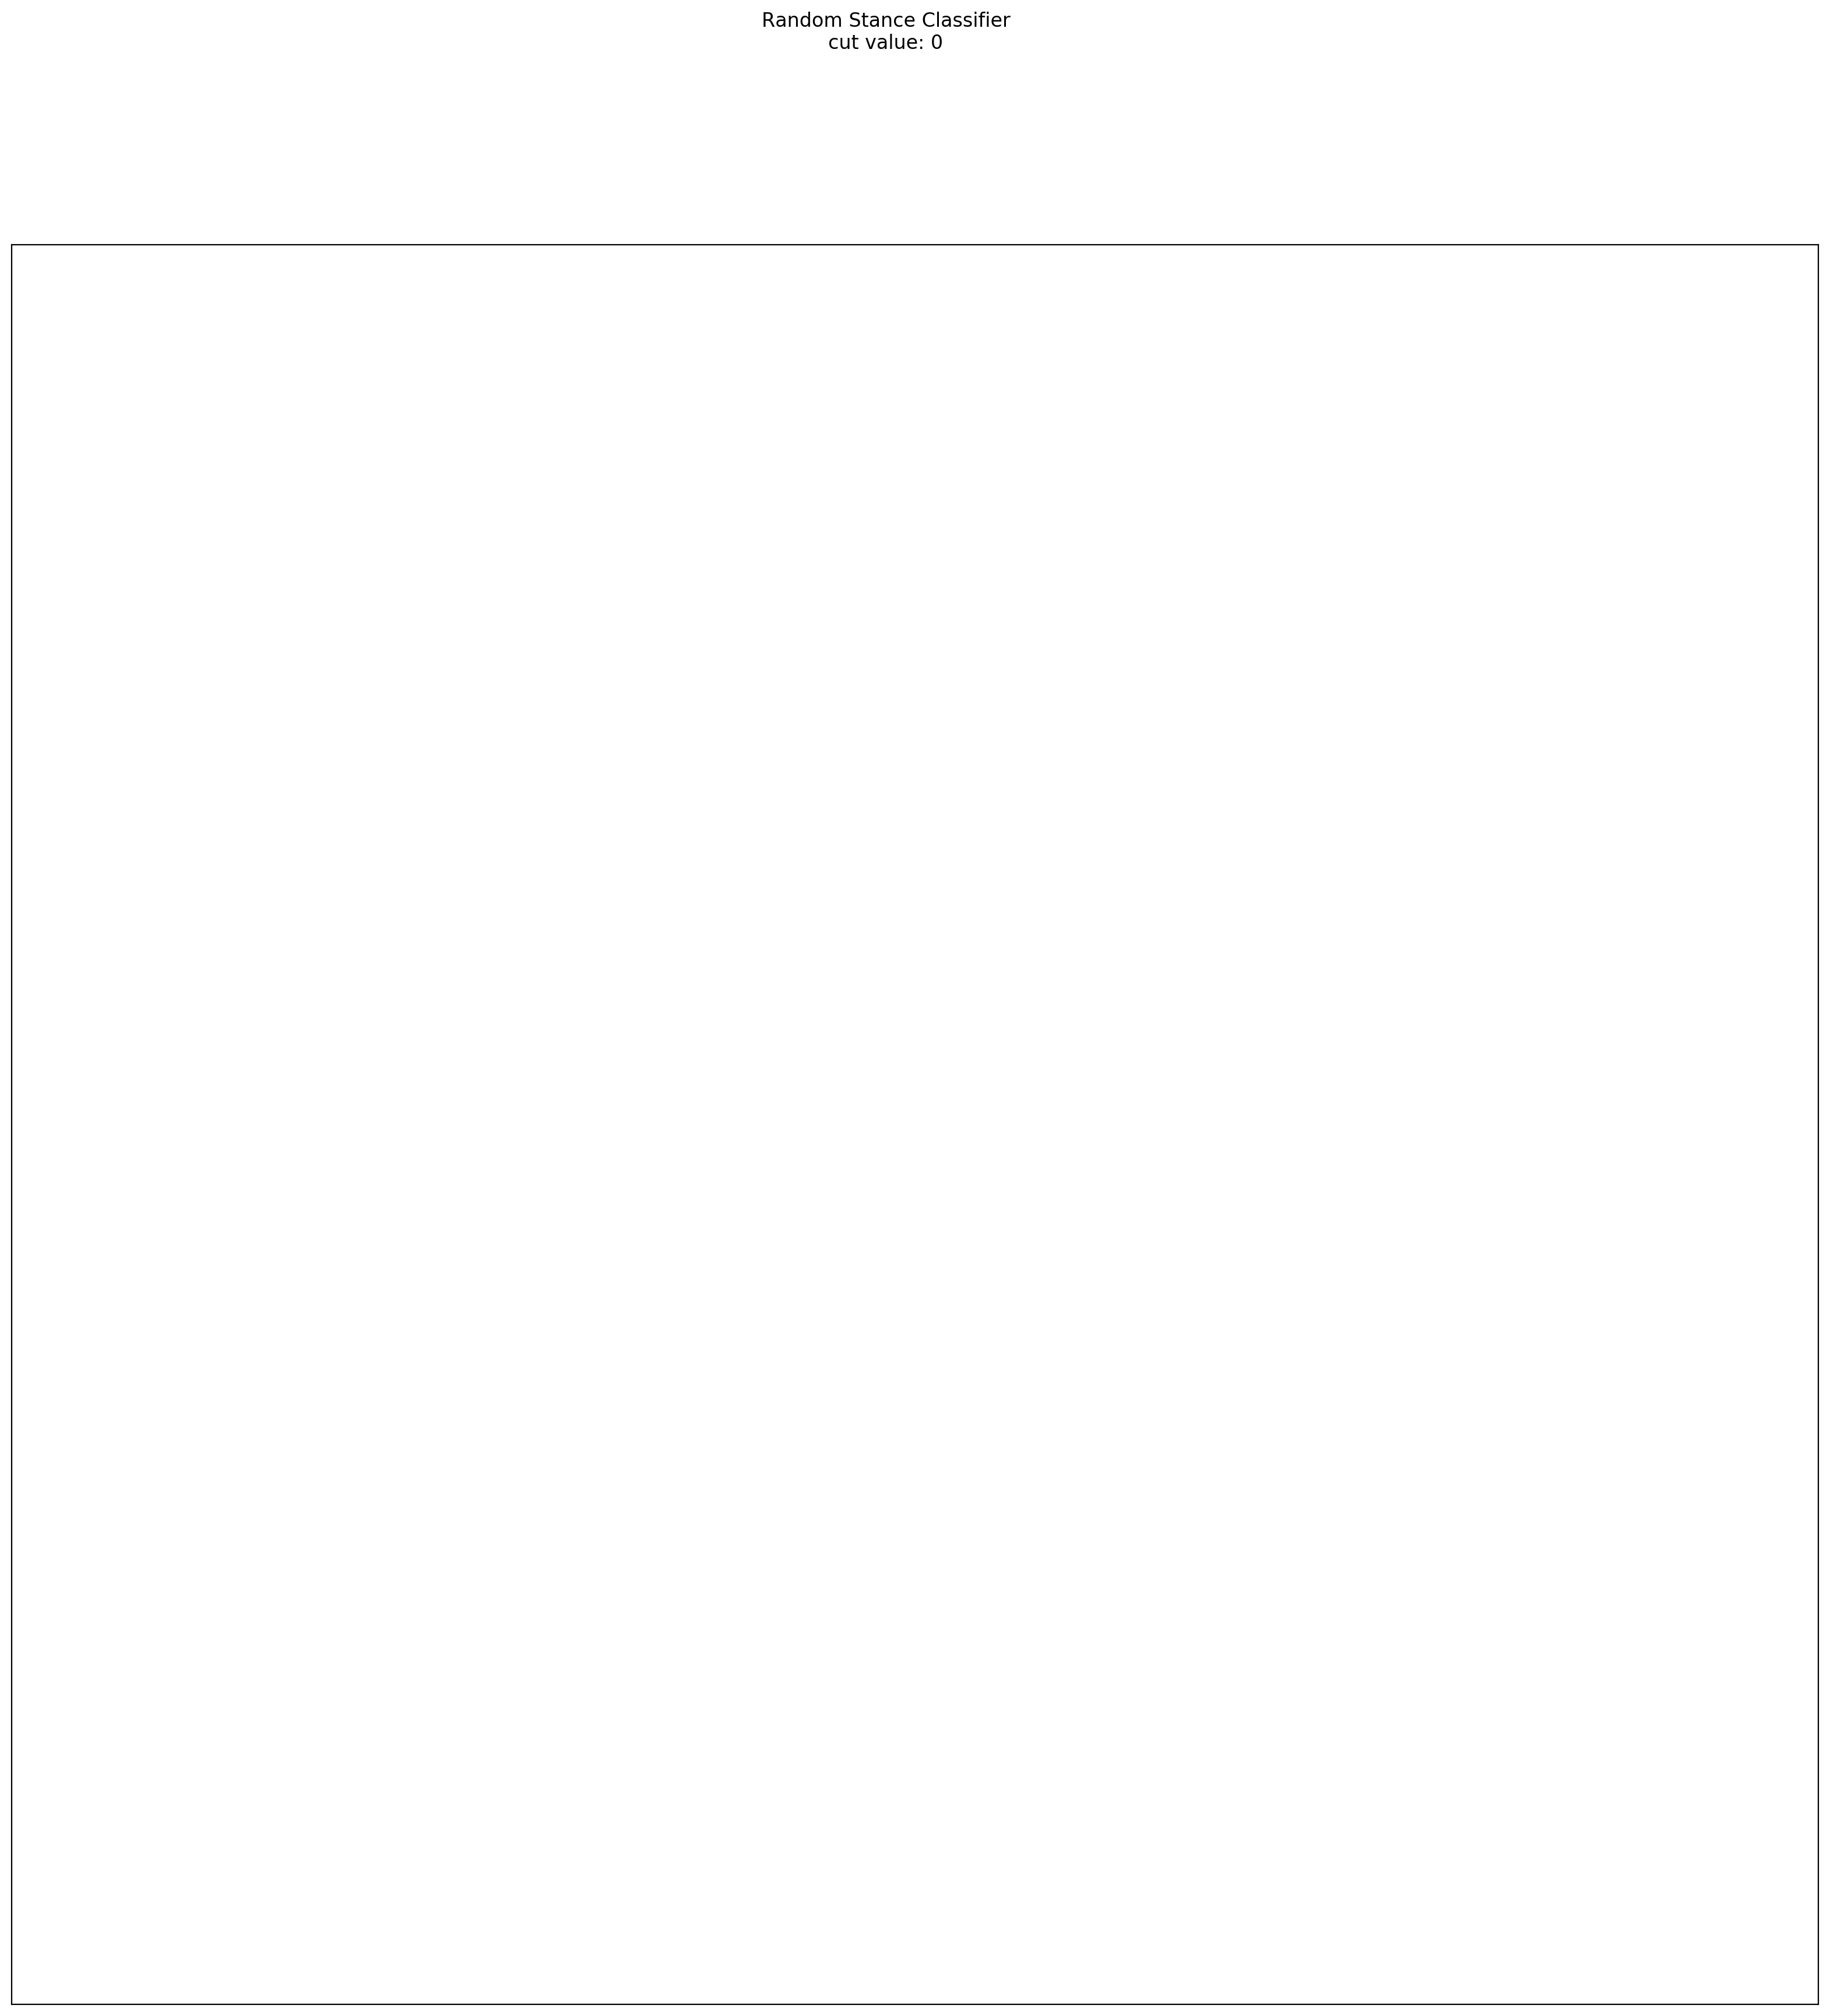

5tmr76


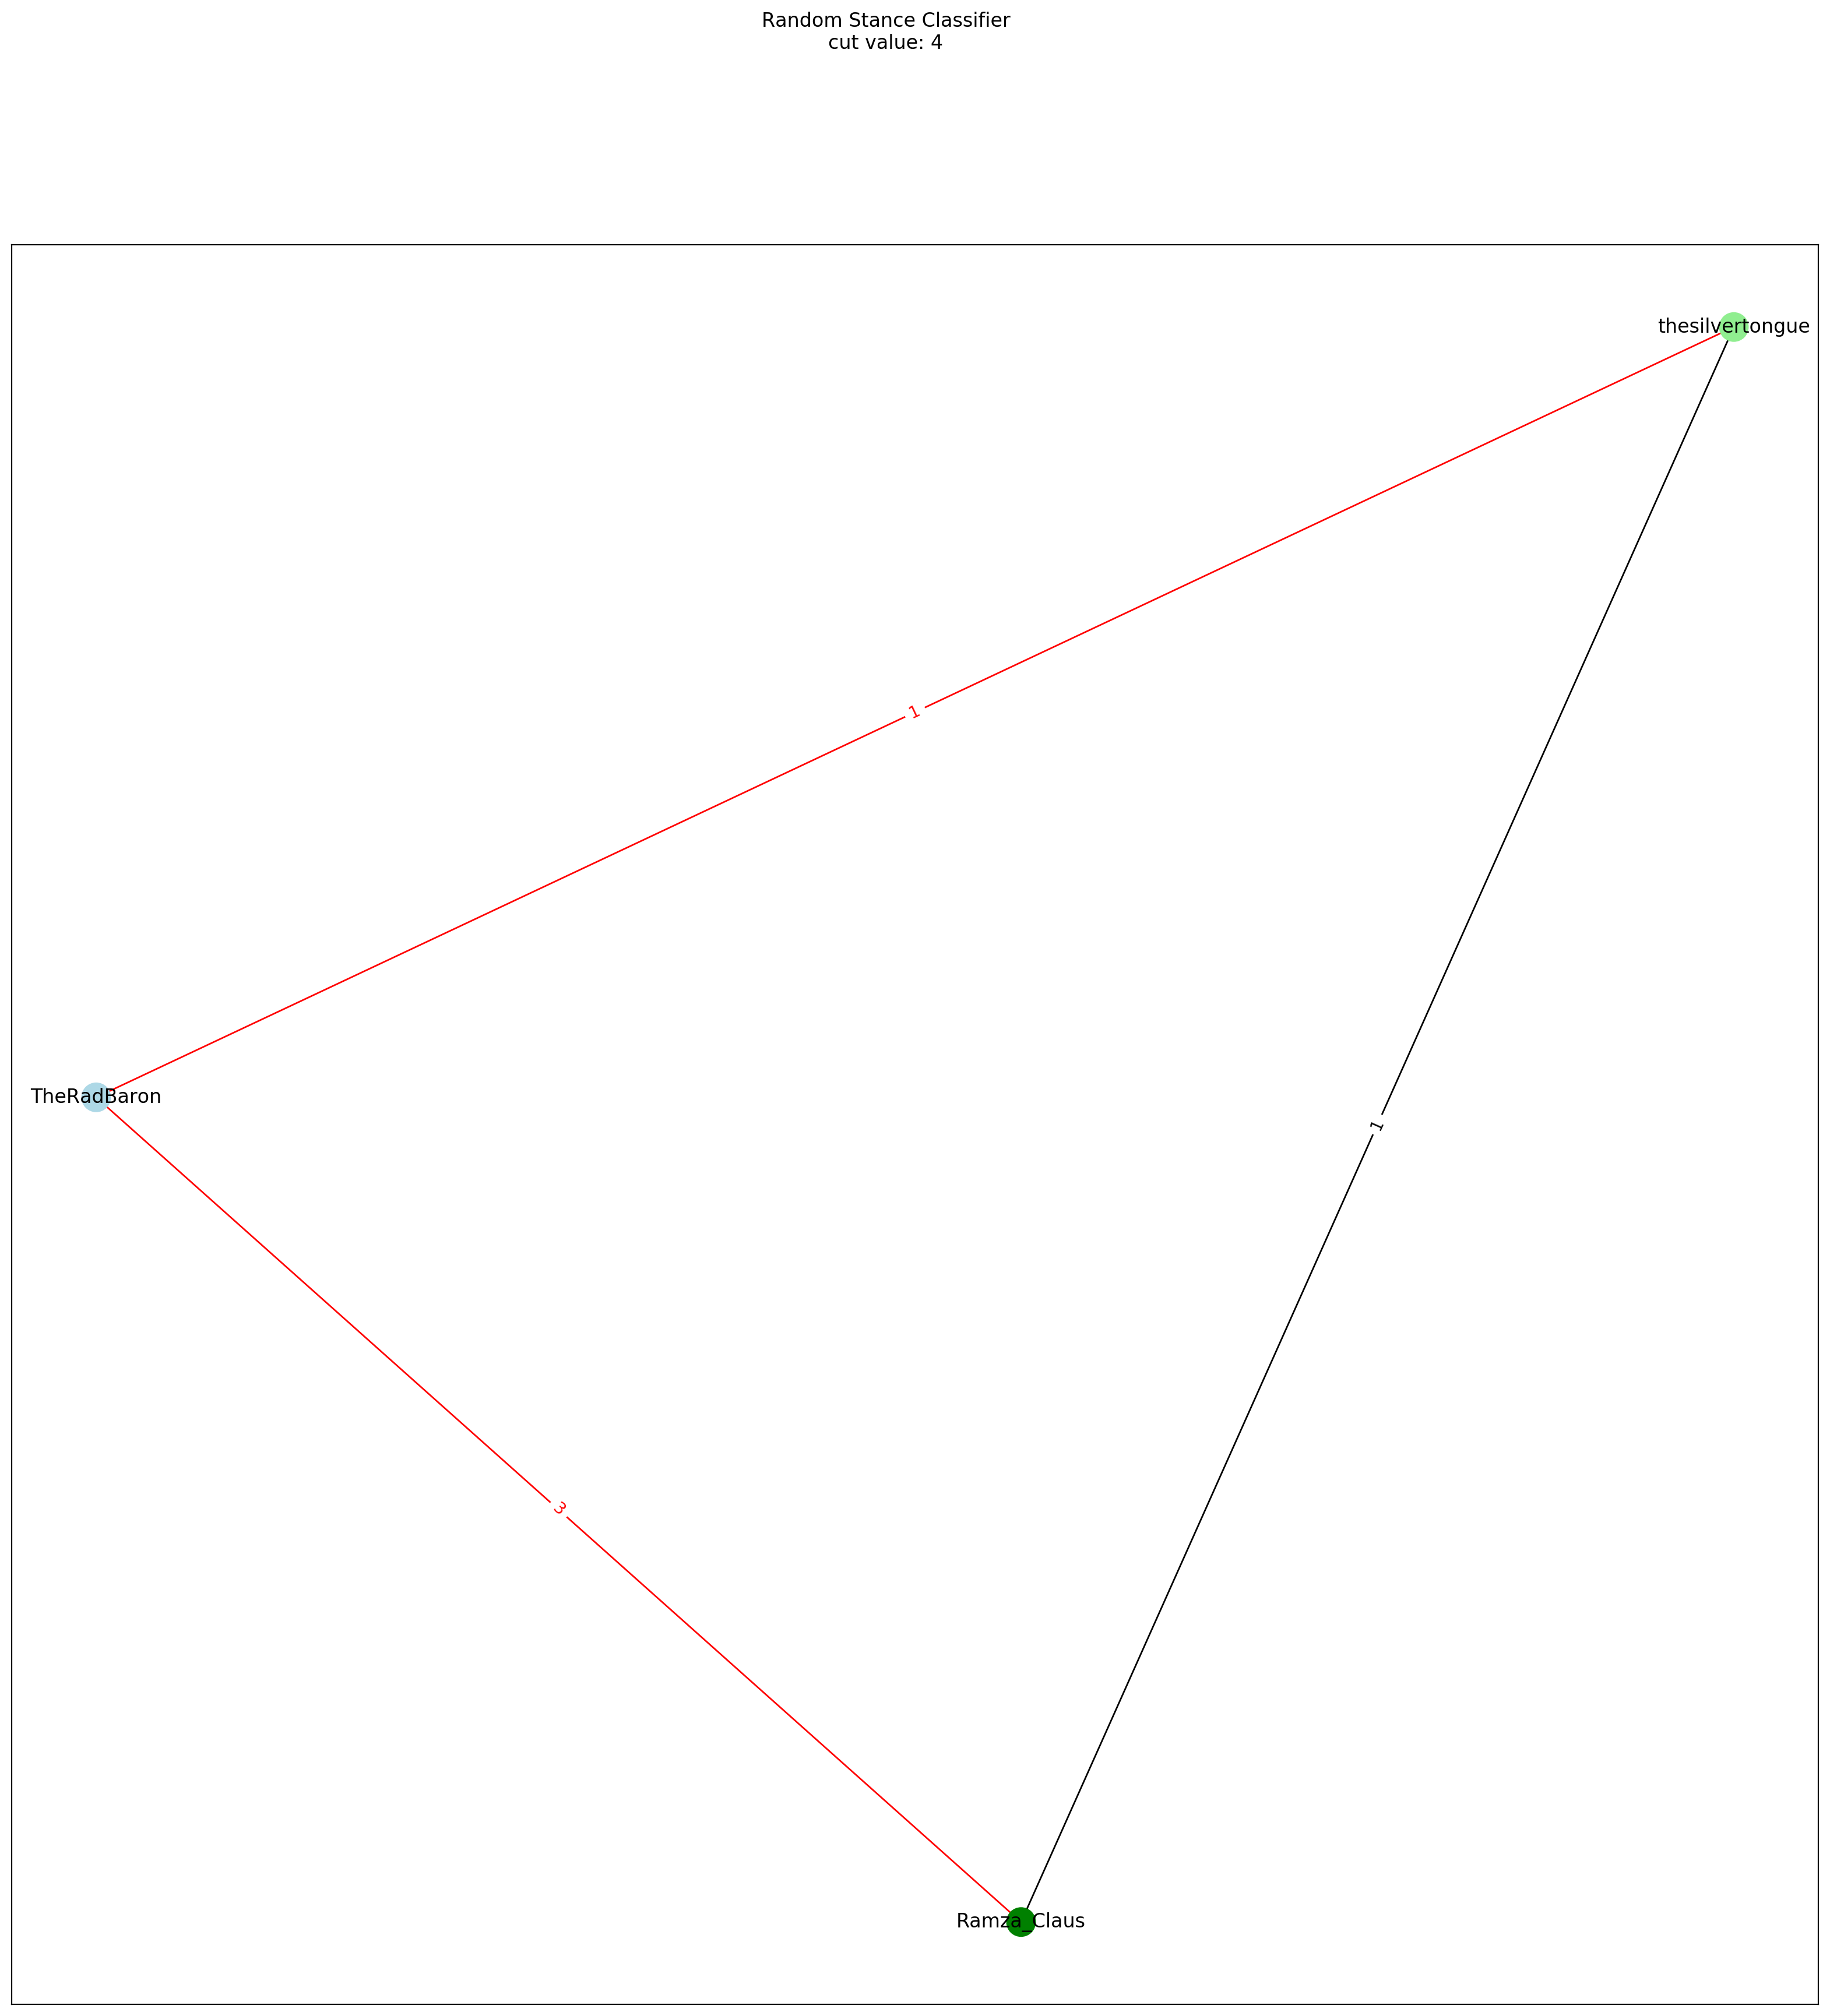

7fu0vw


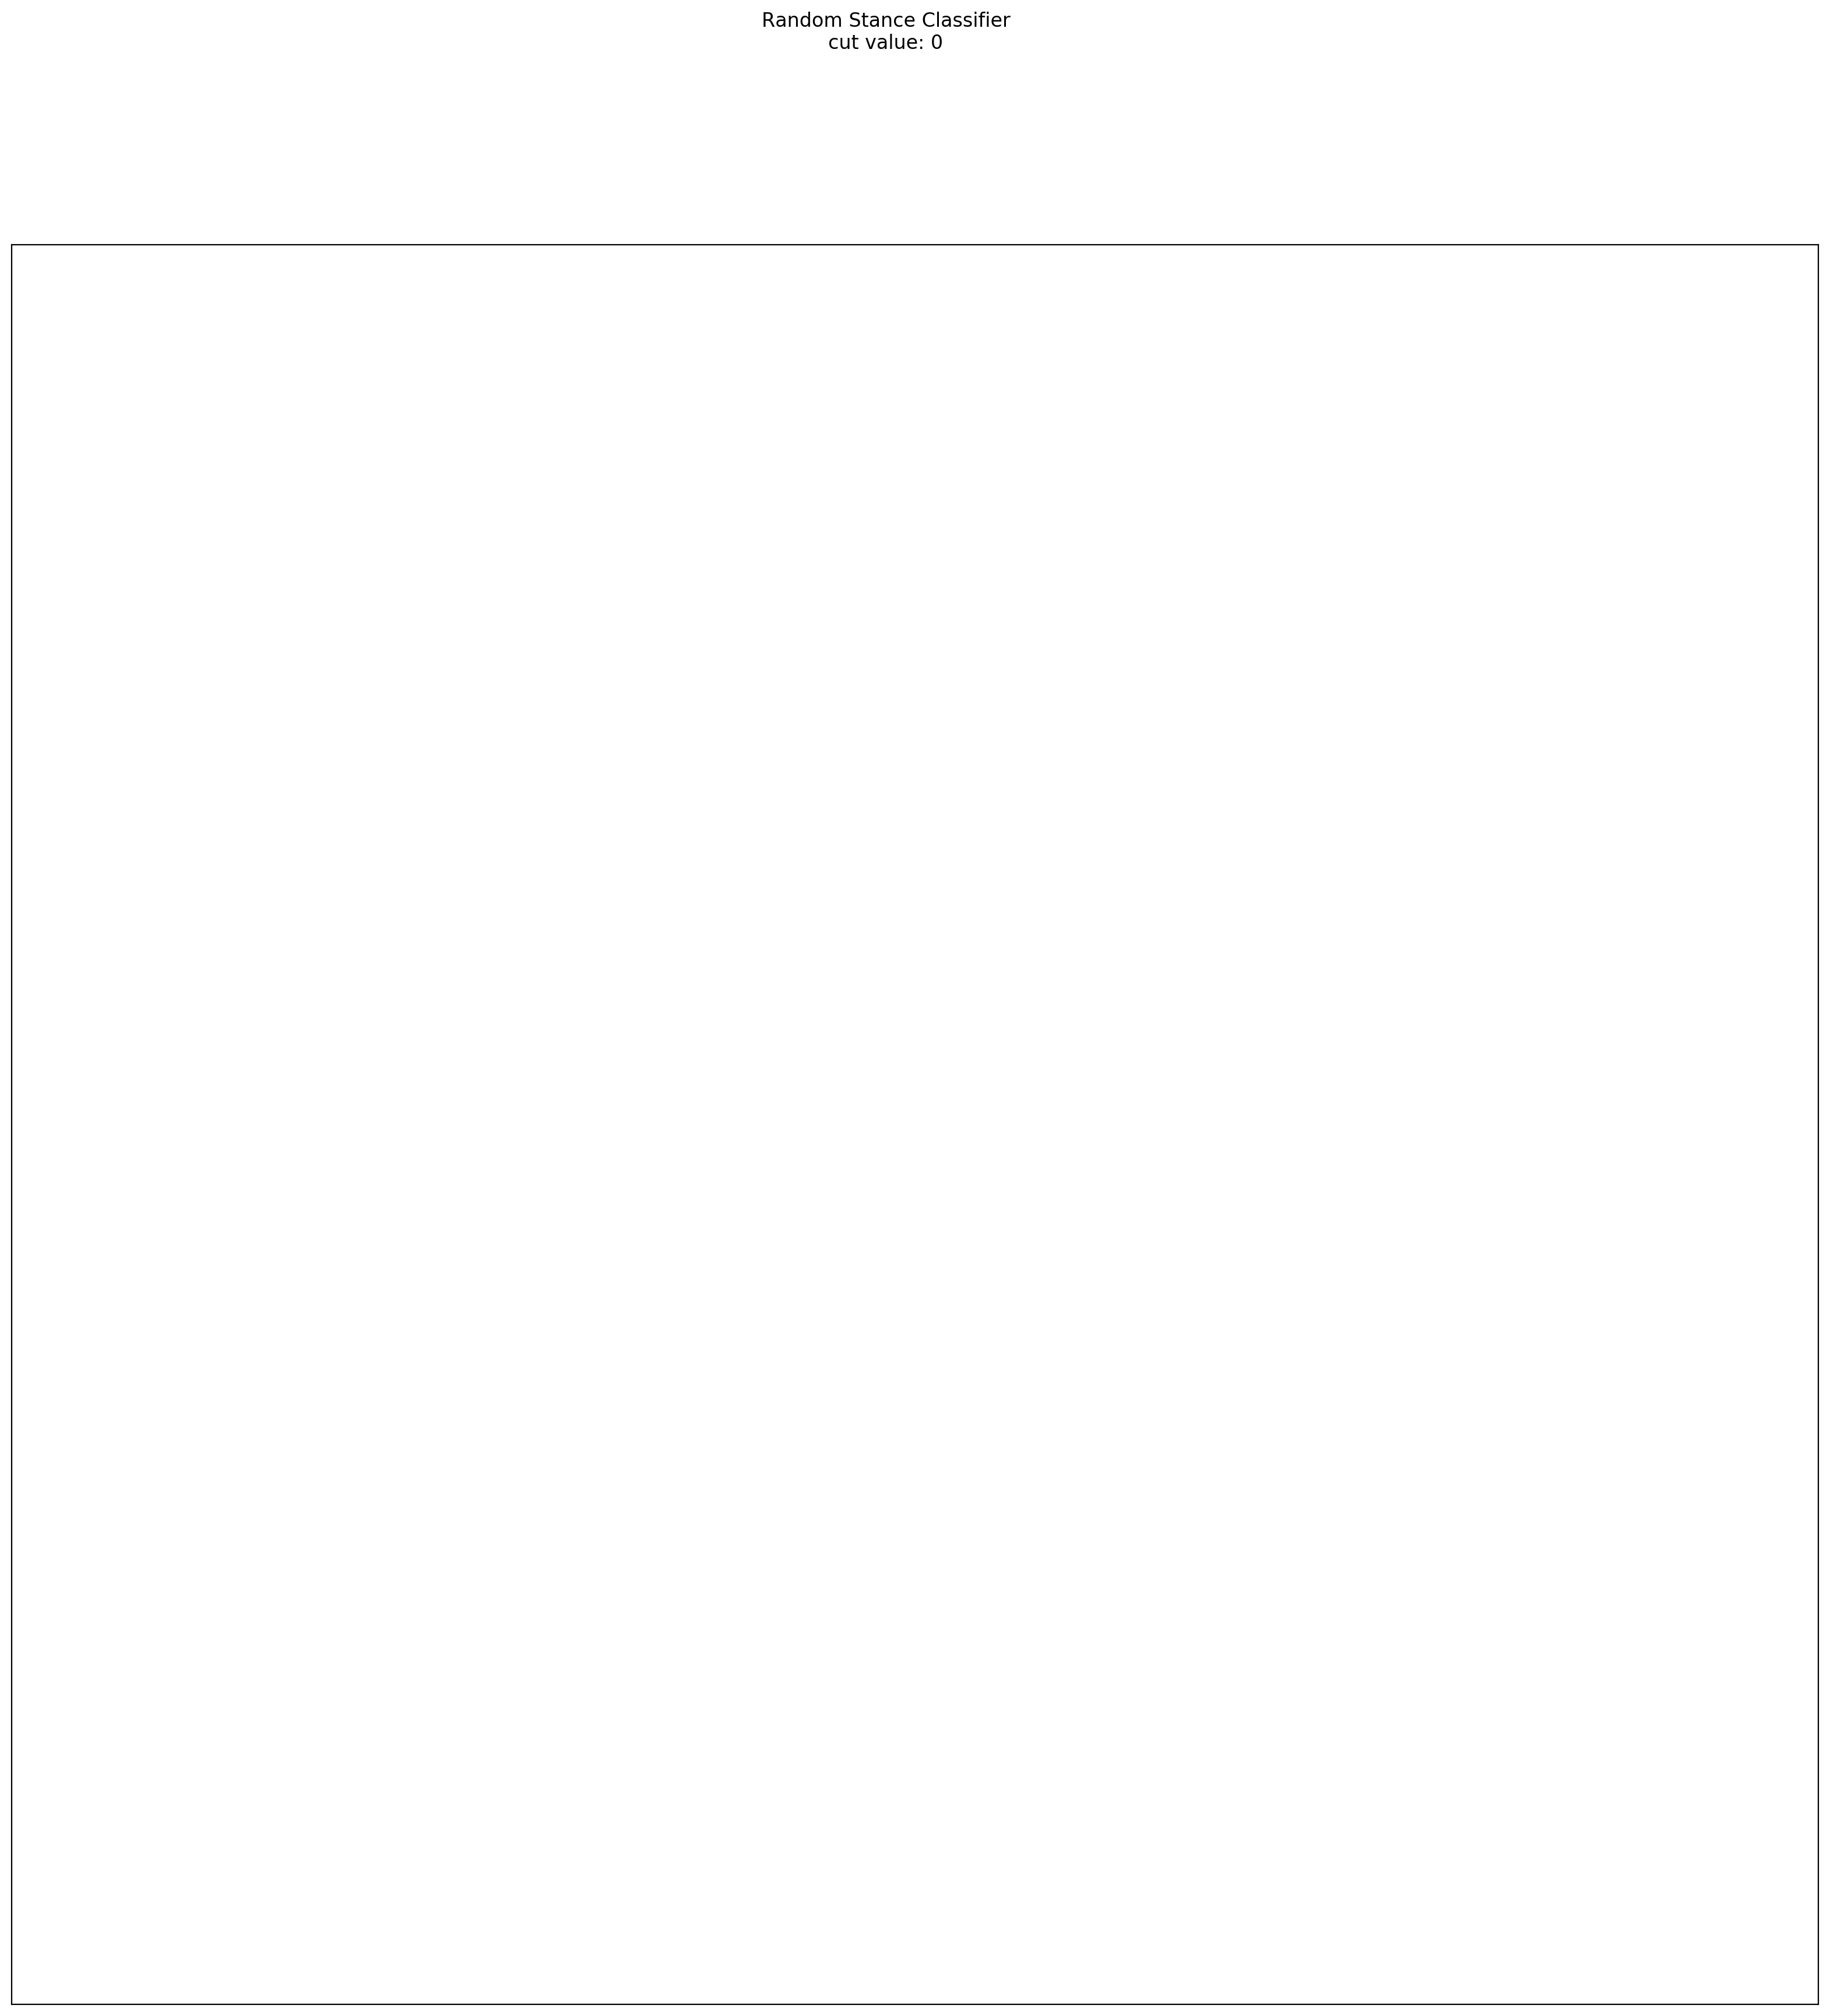

4rx9zu


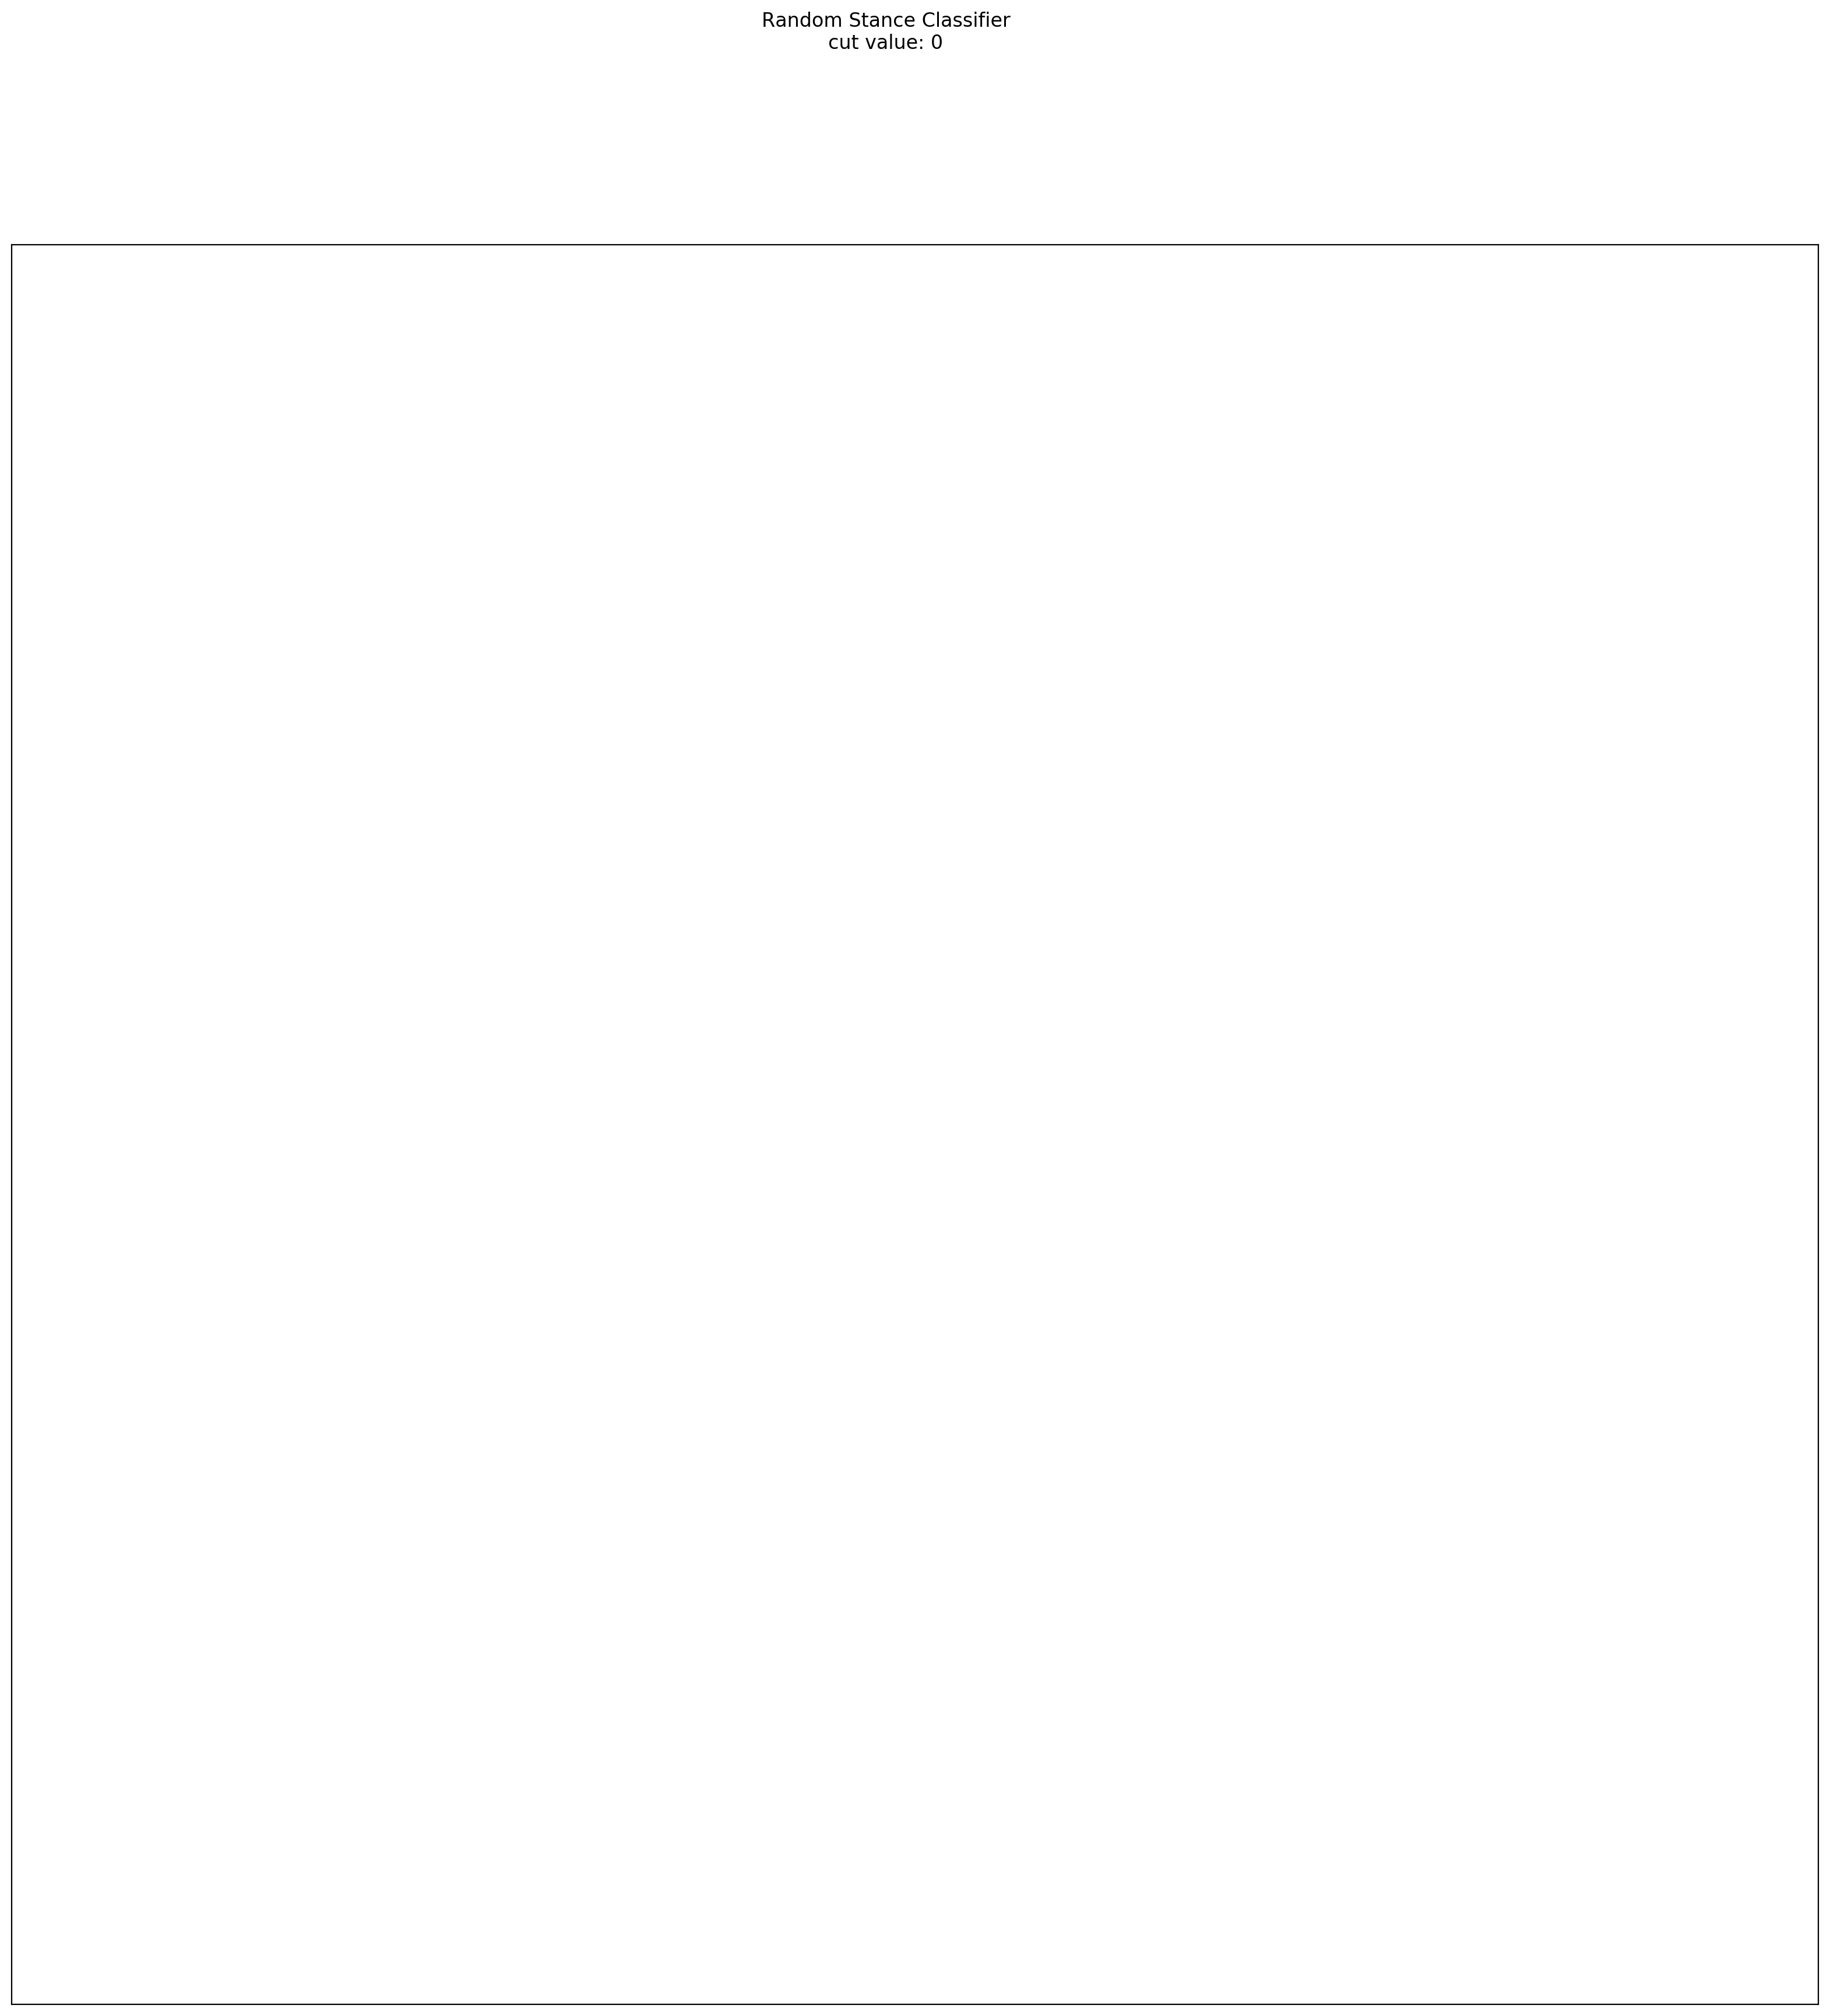

645ogu


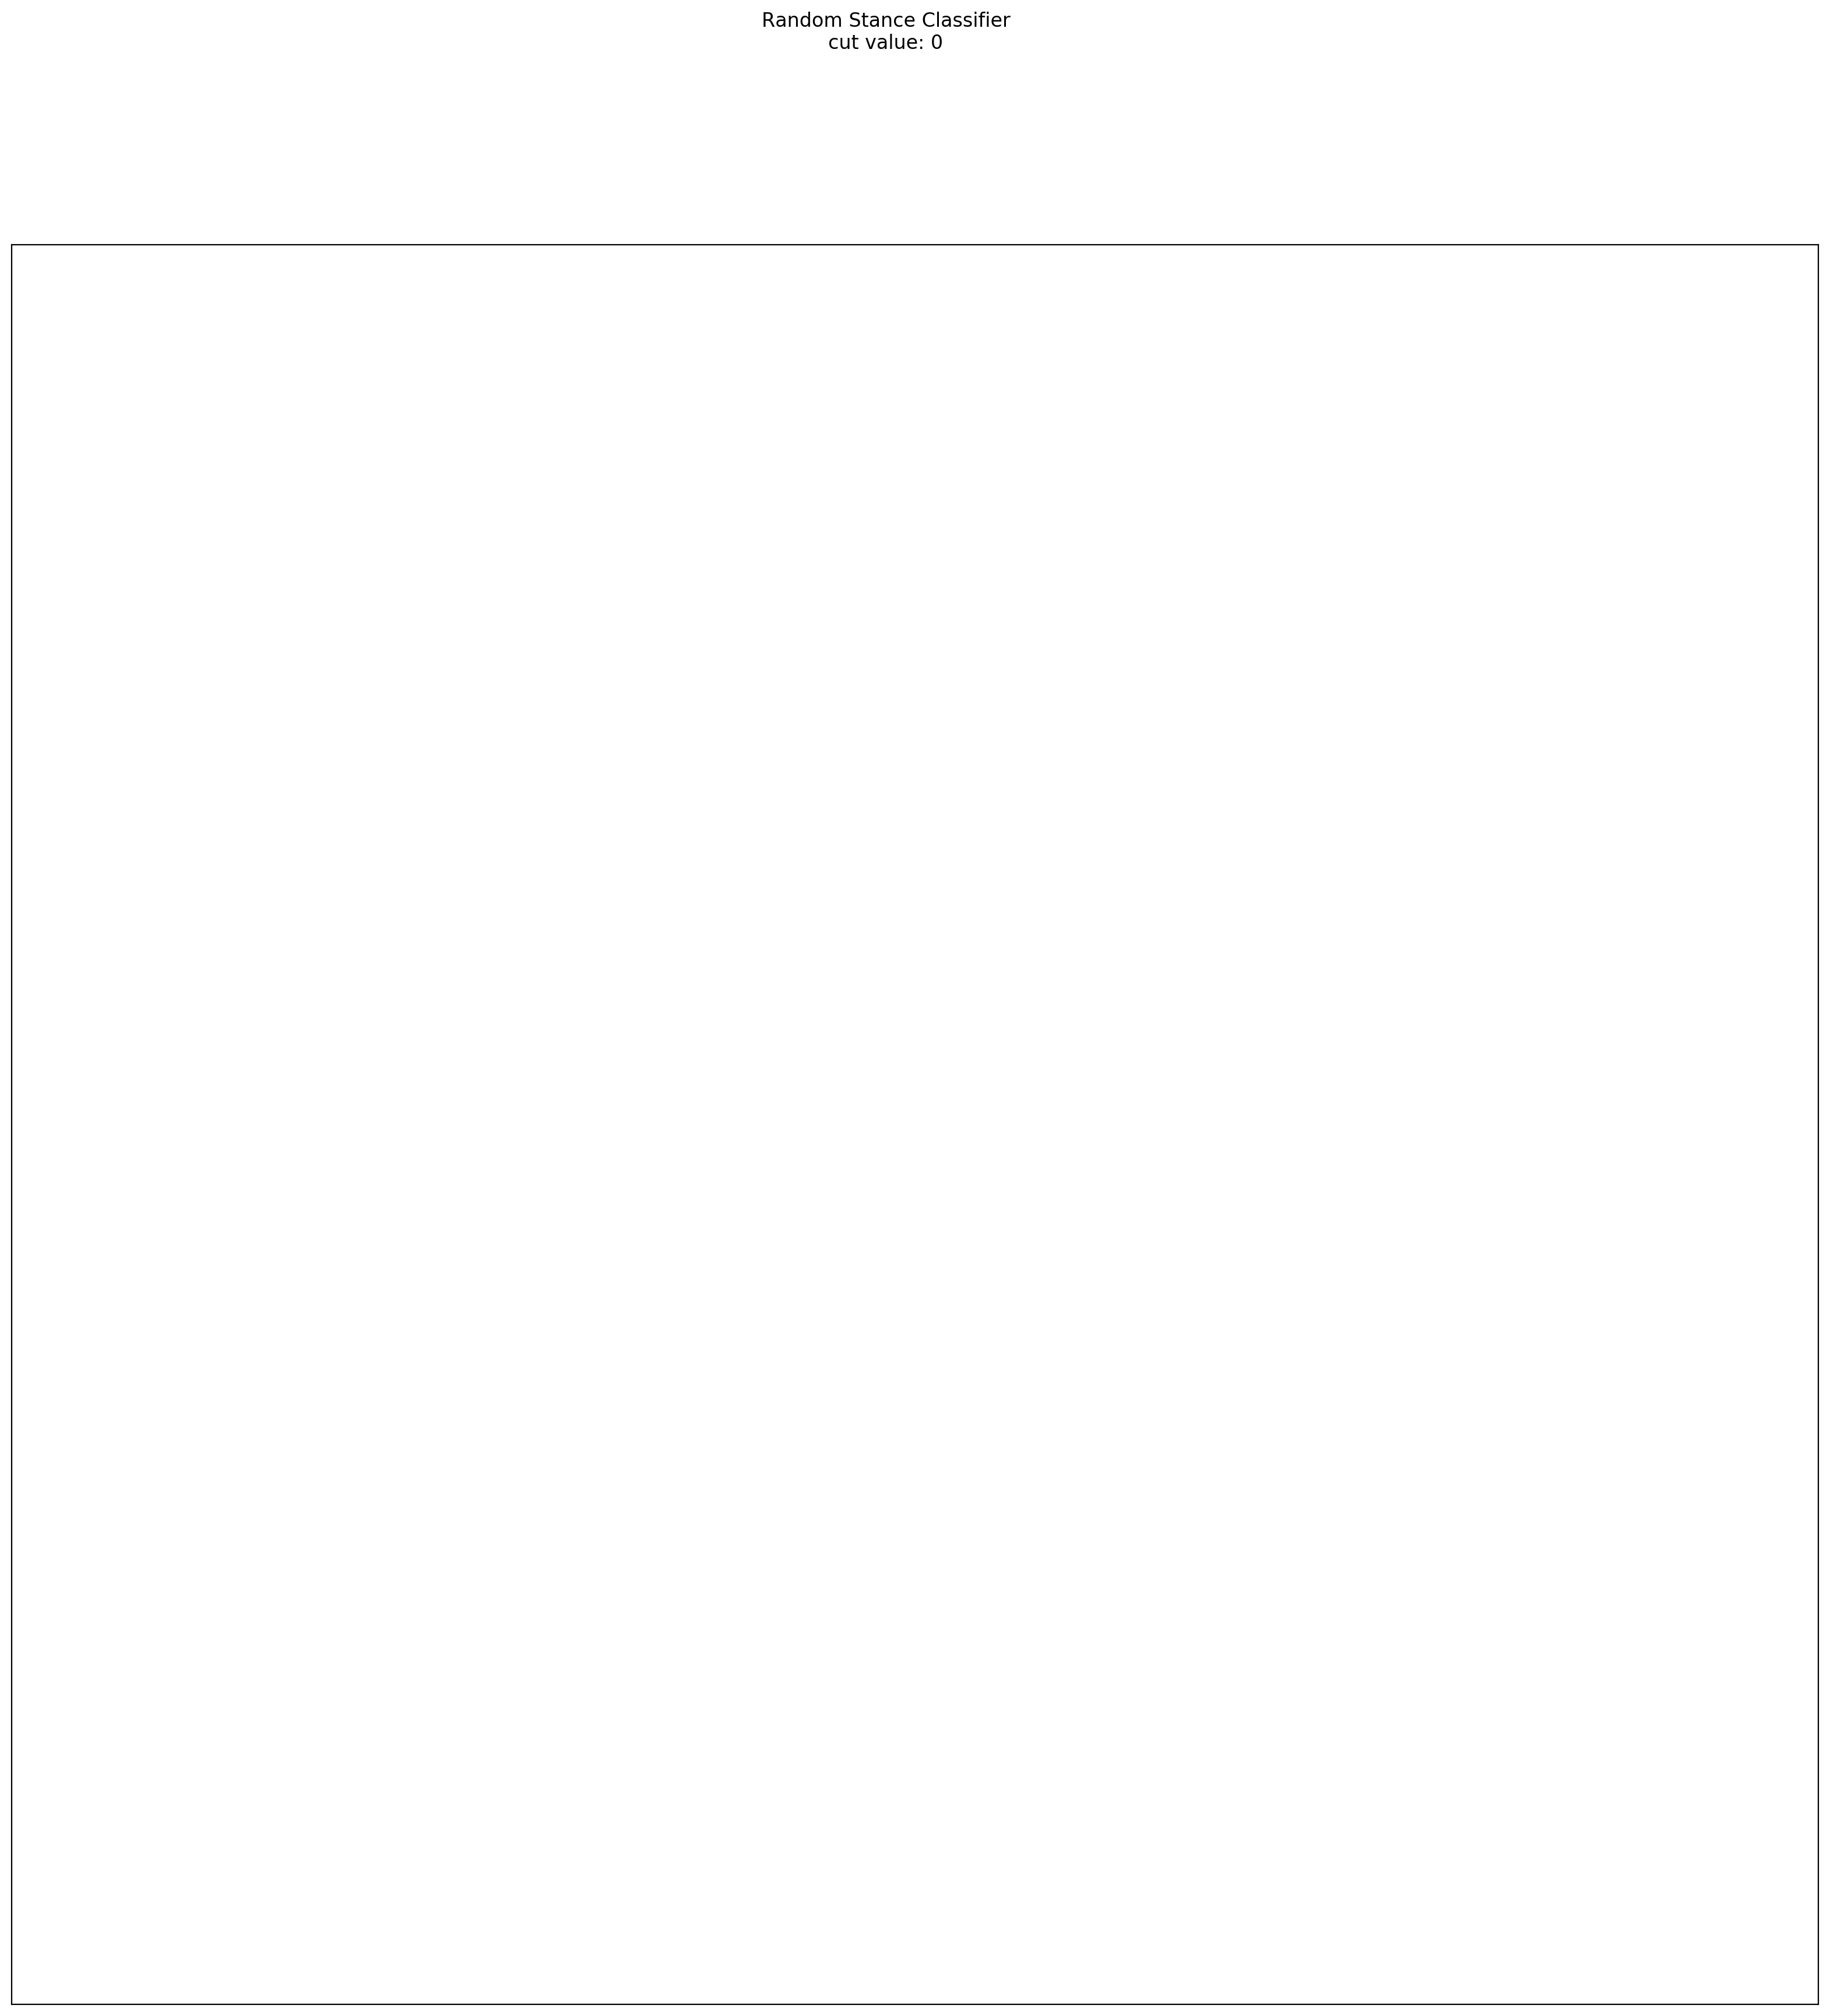

6y9rf7


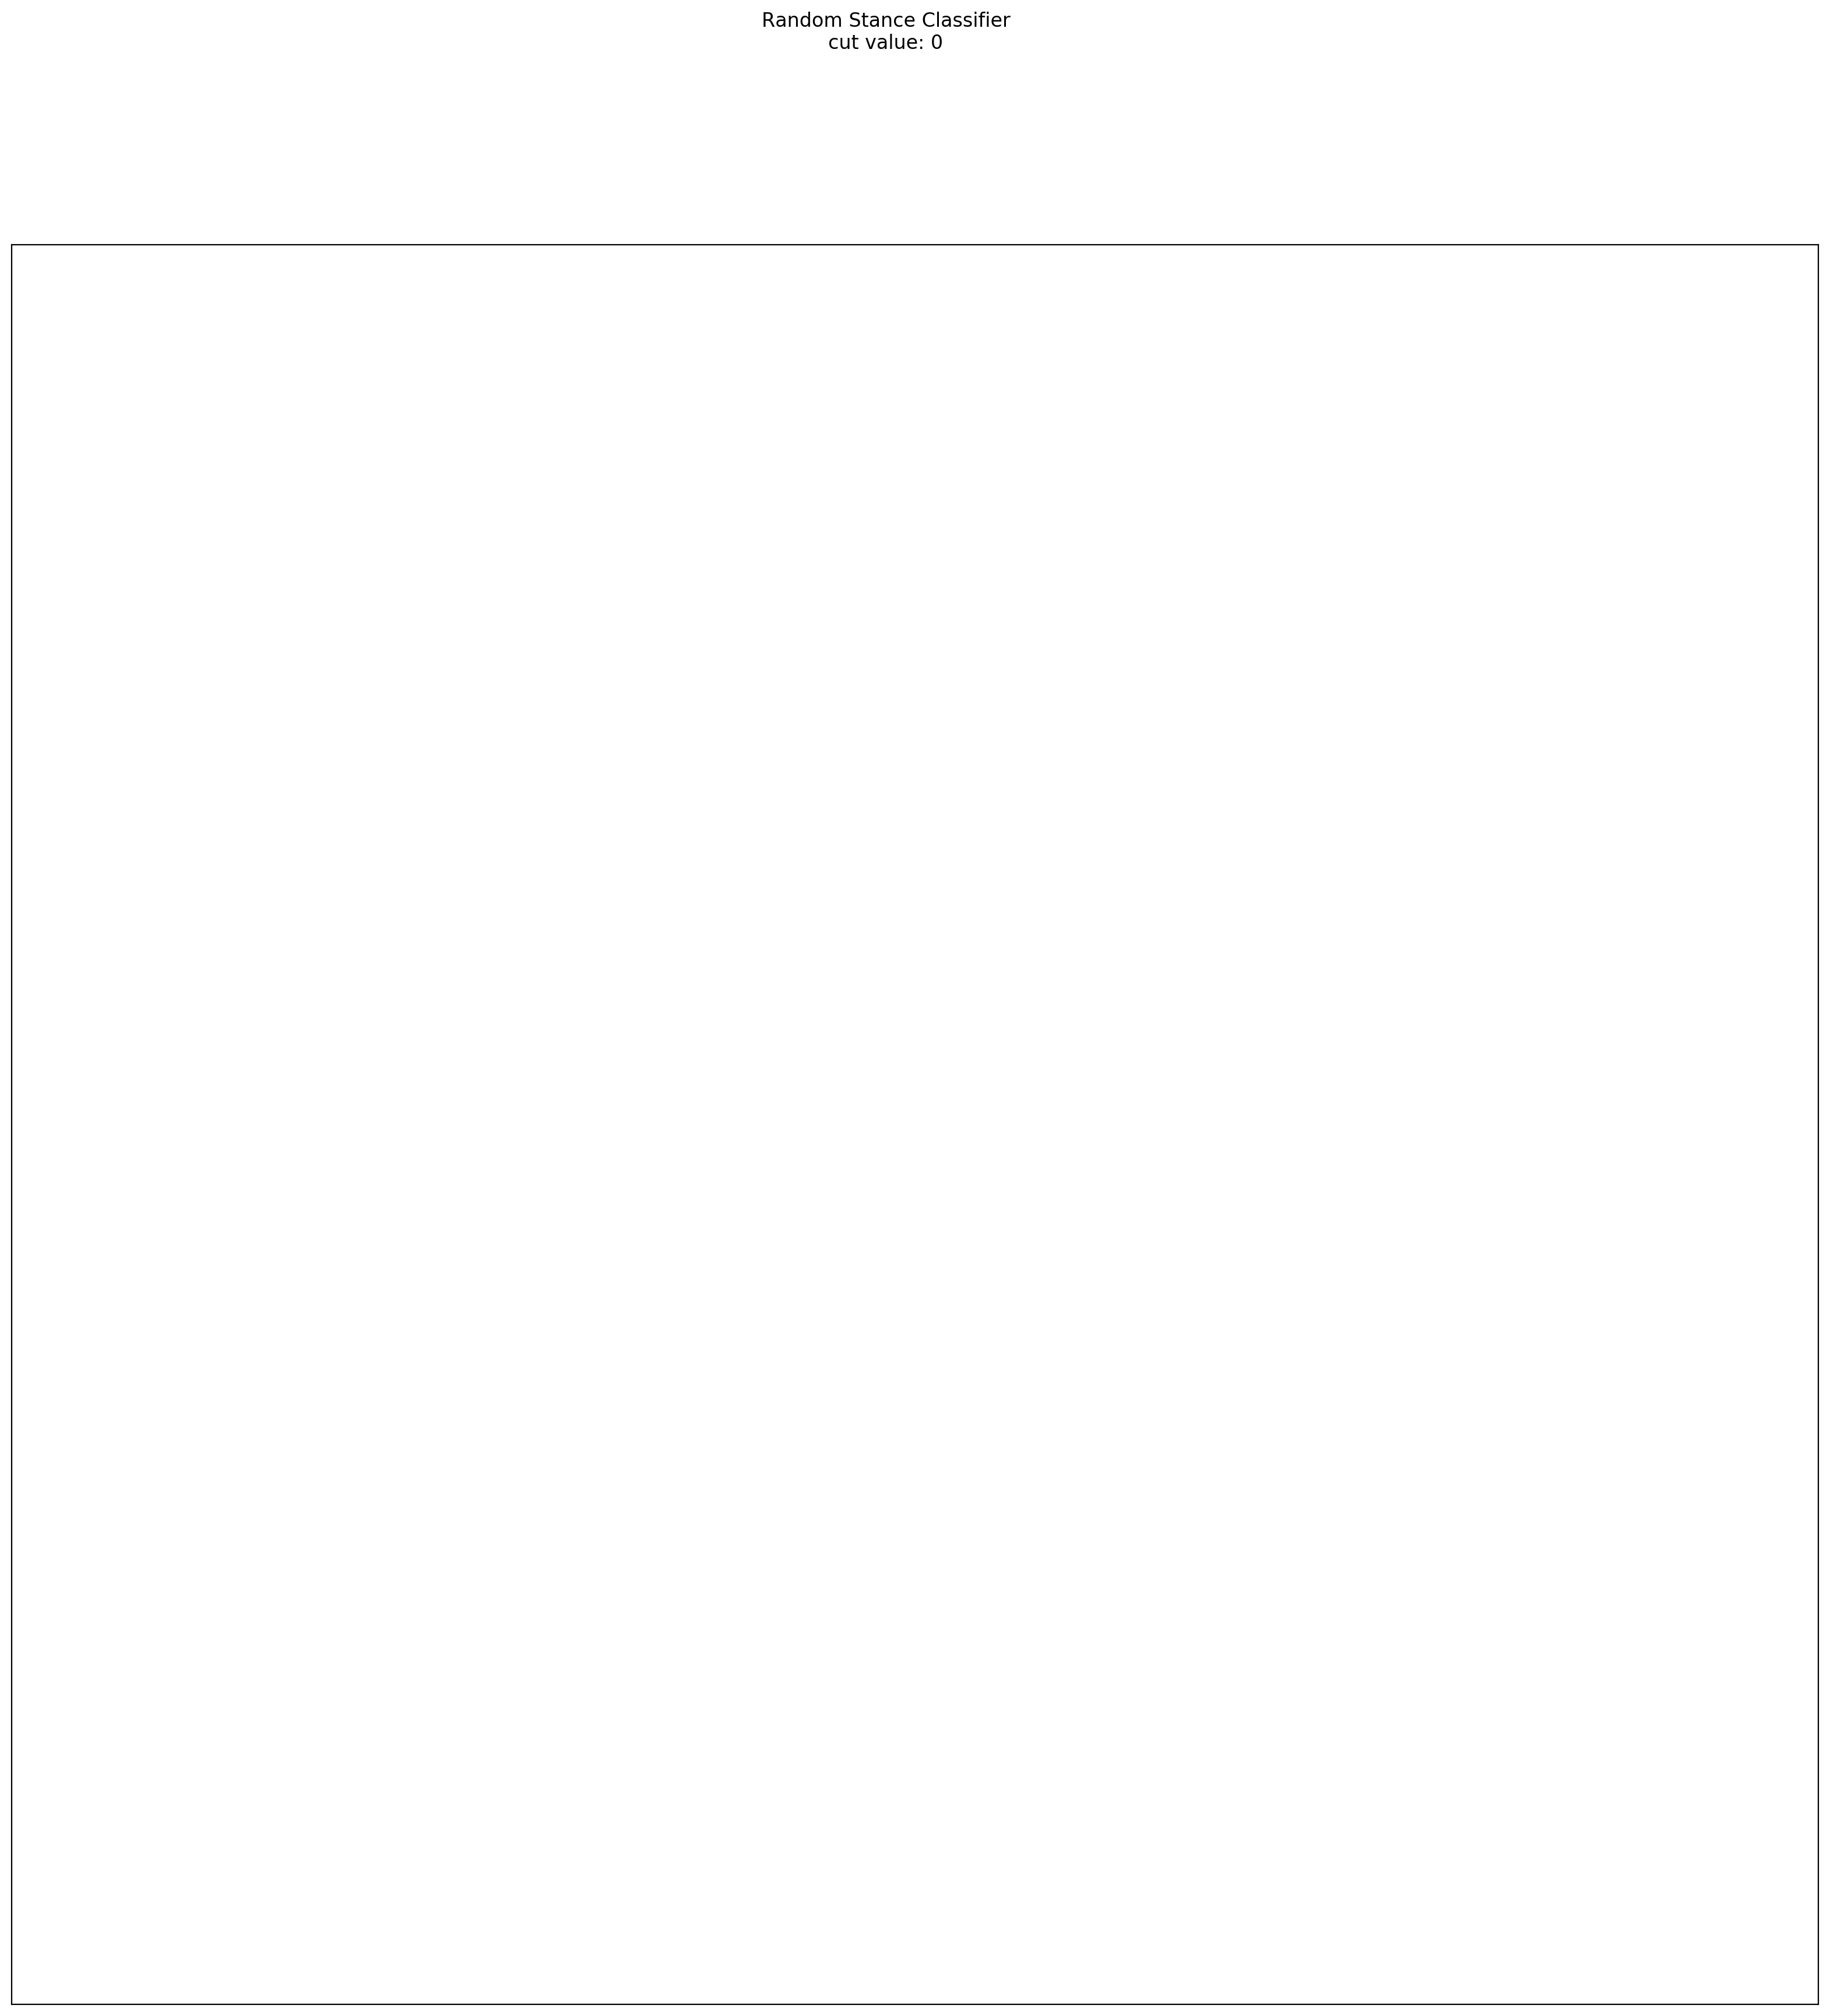

4ulnbu


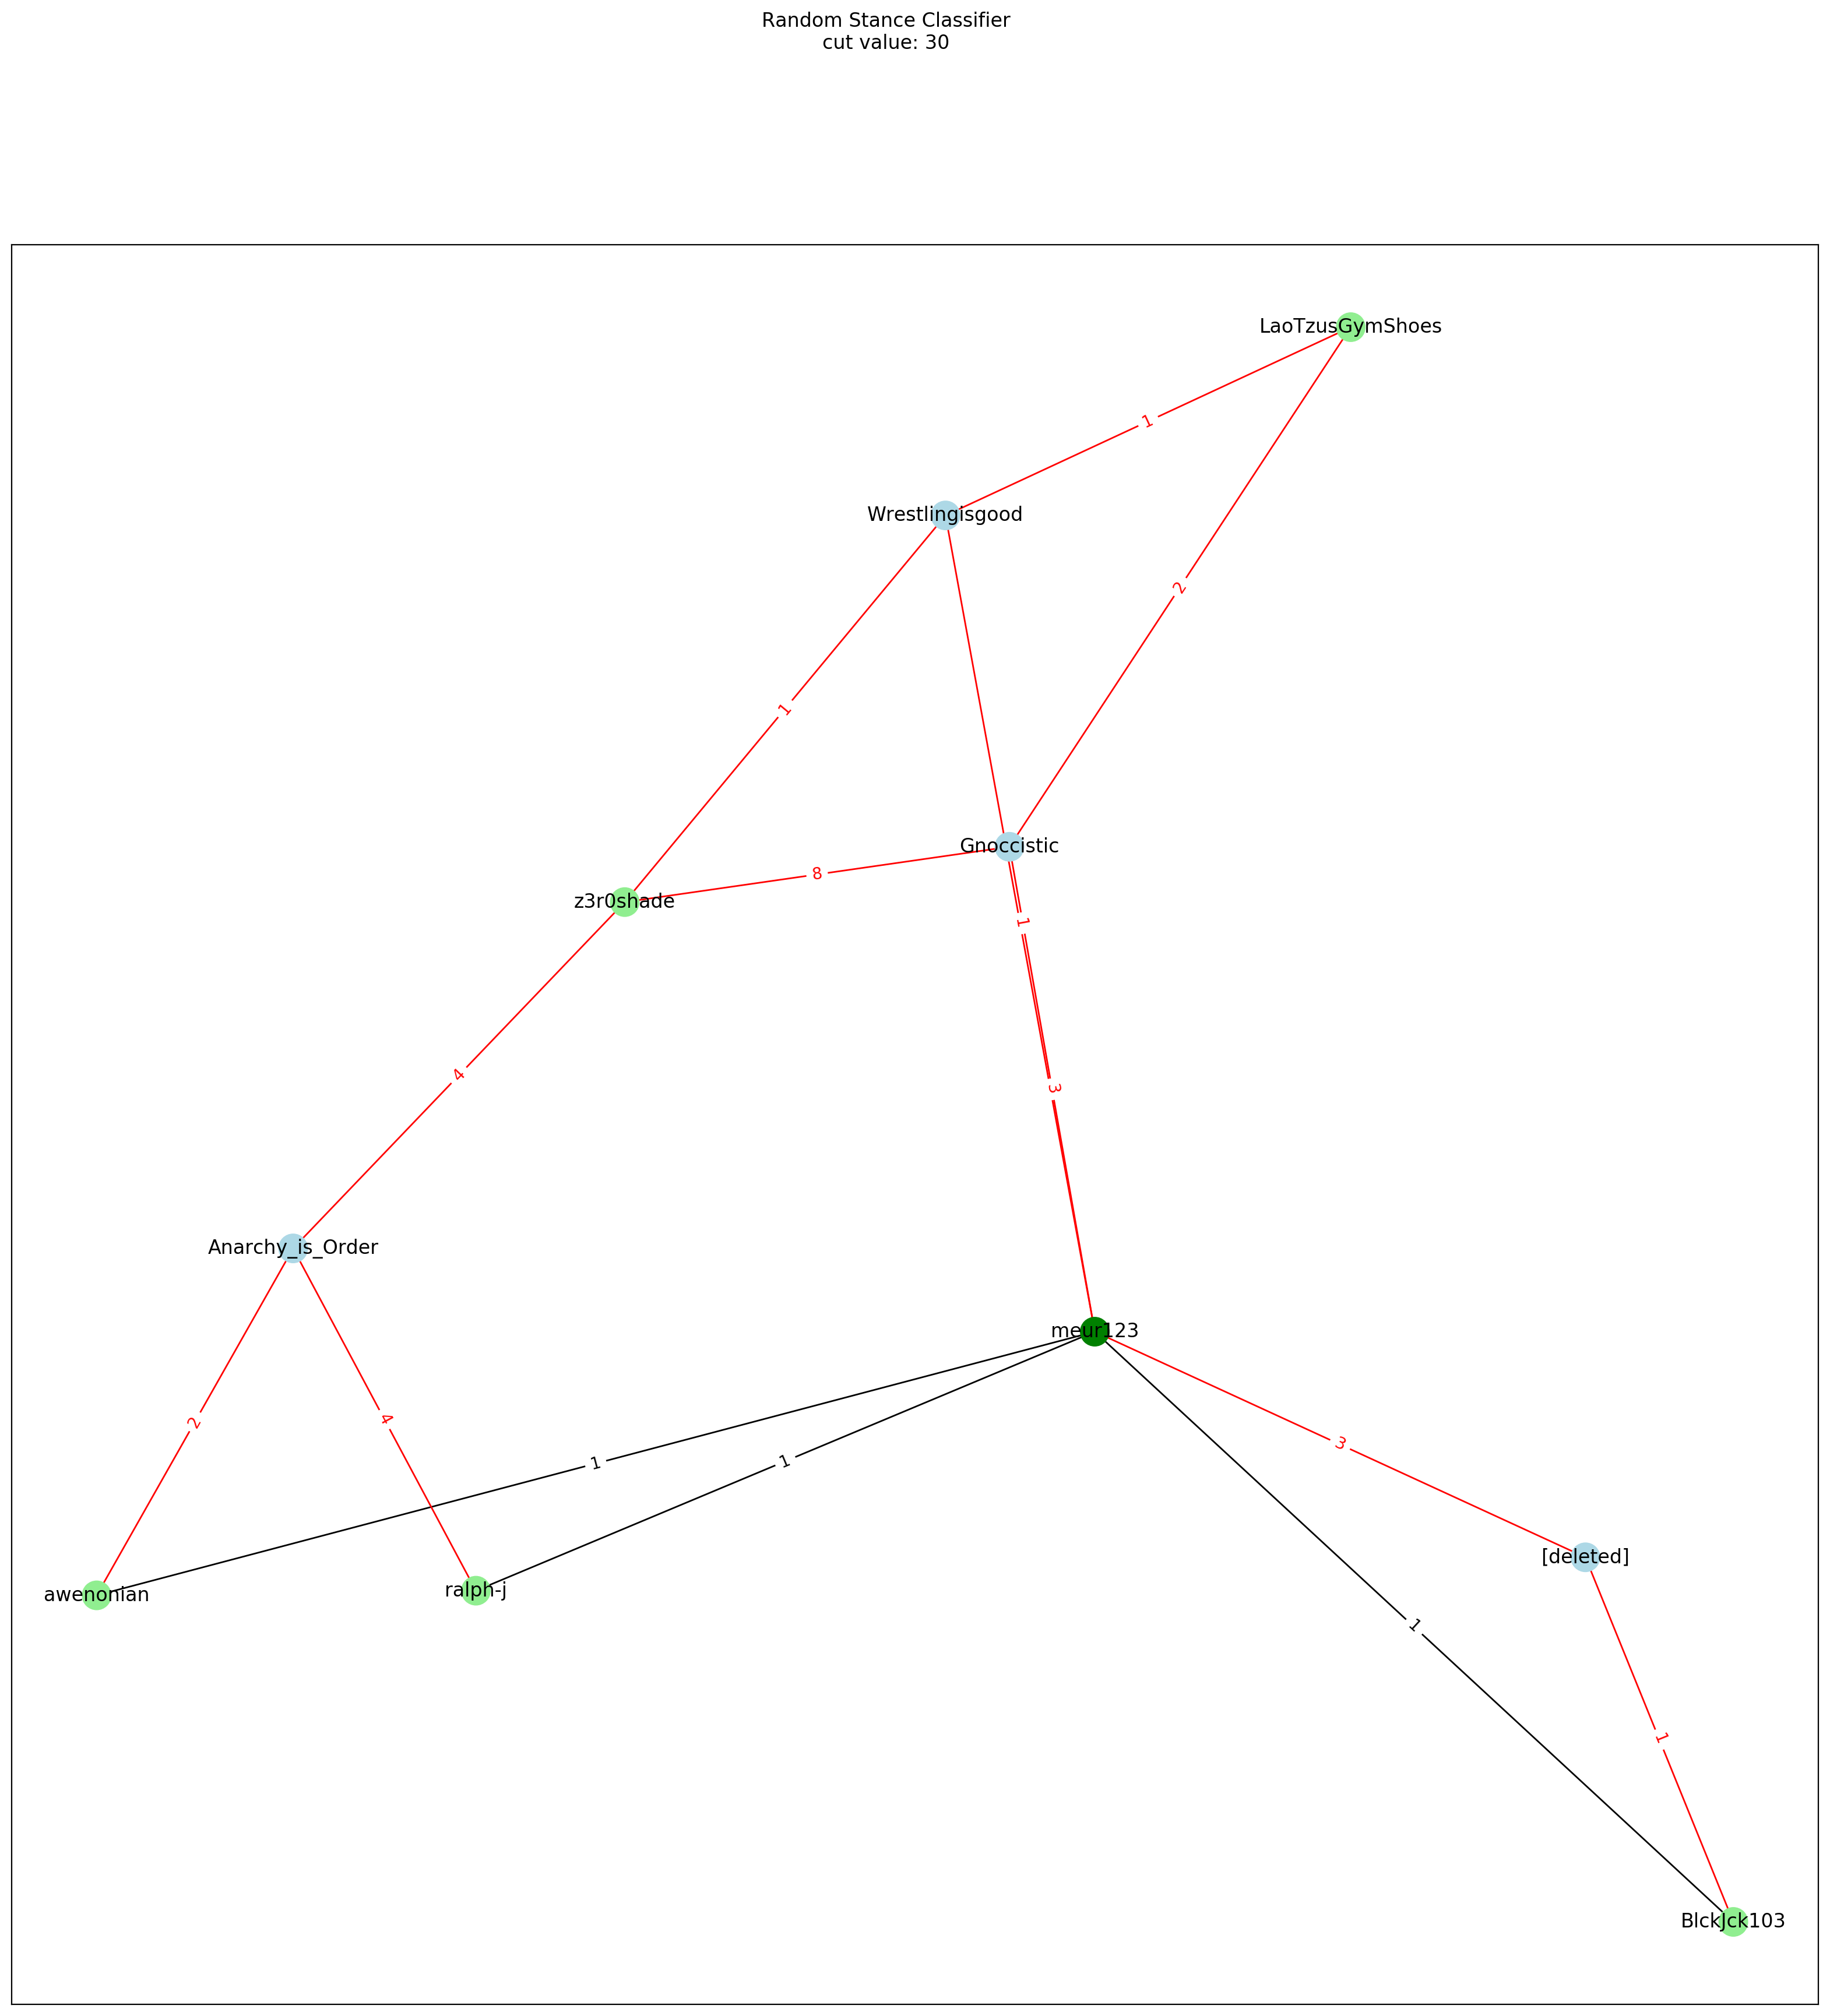

5s2xvu


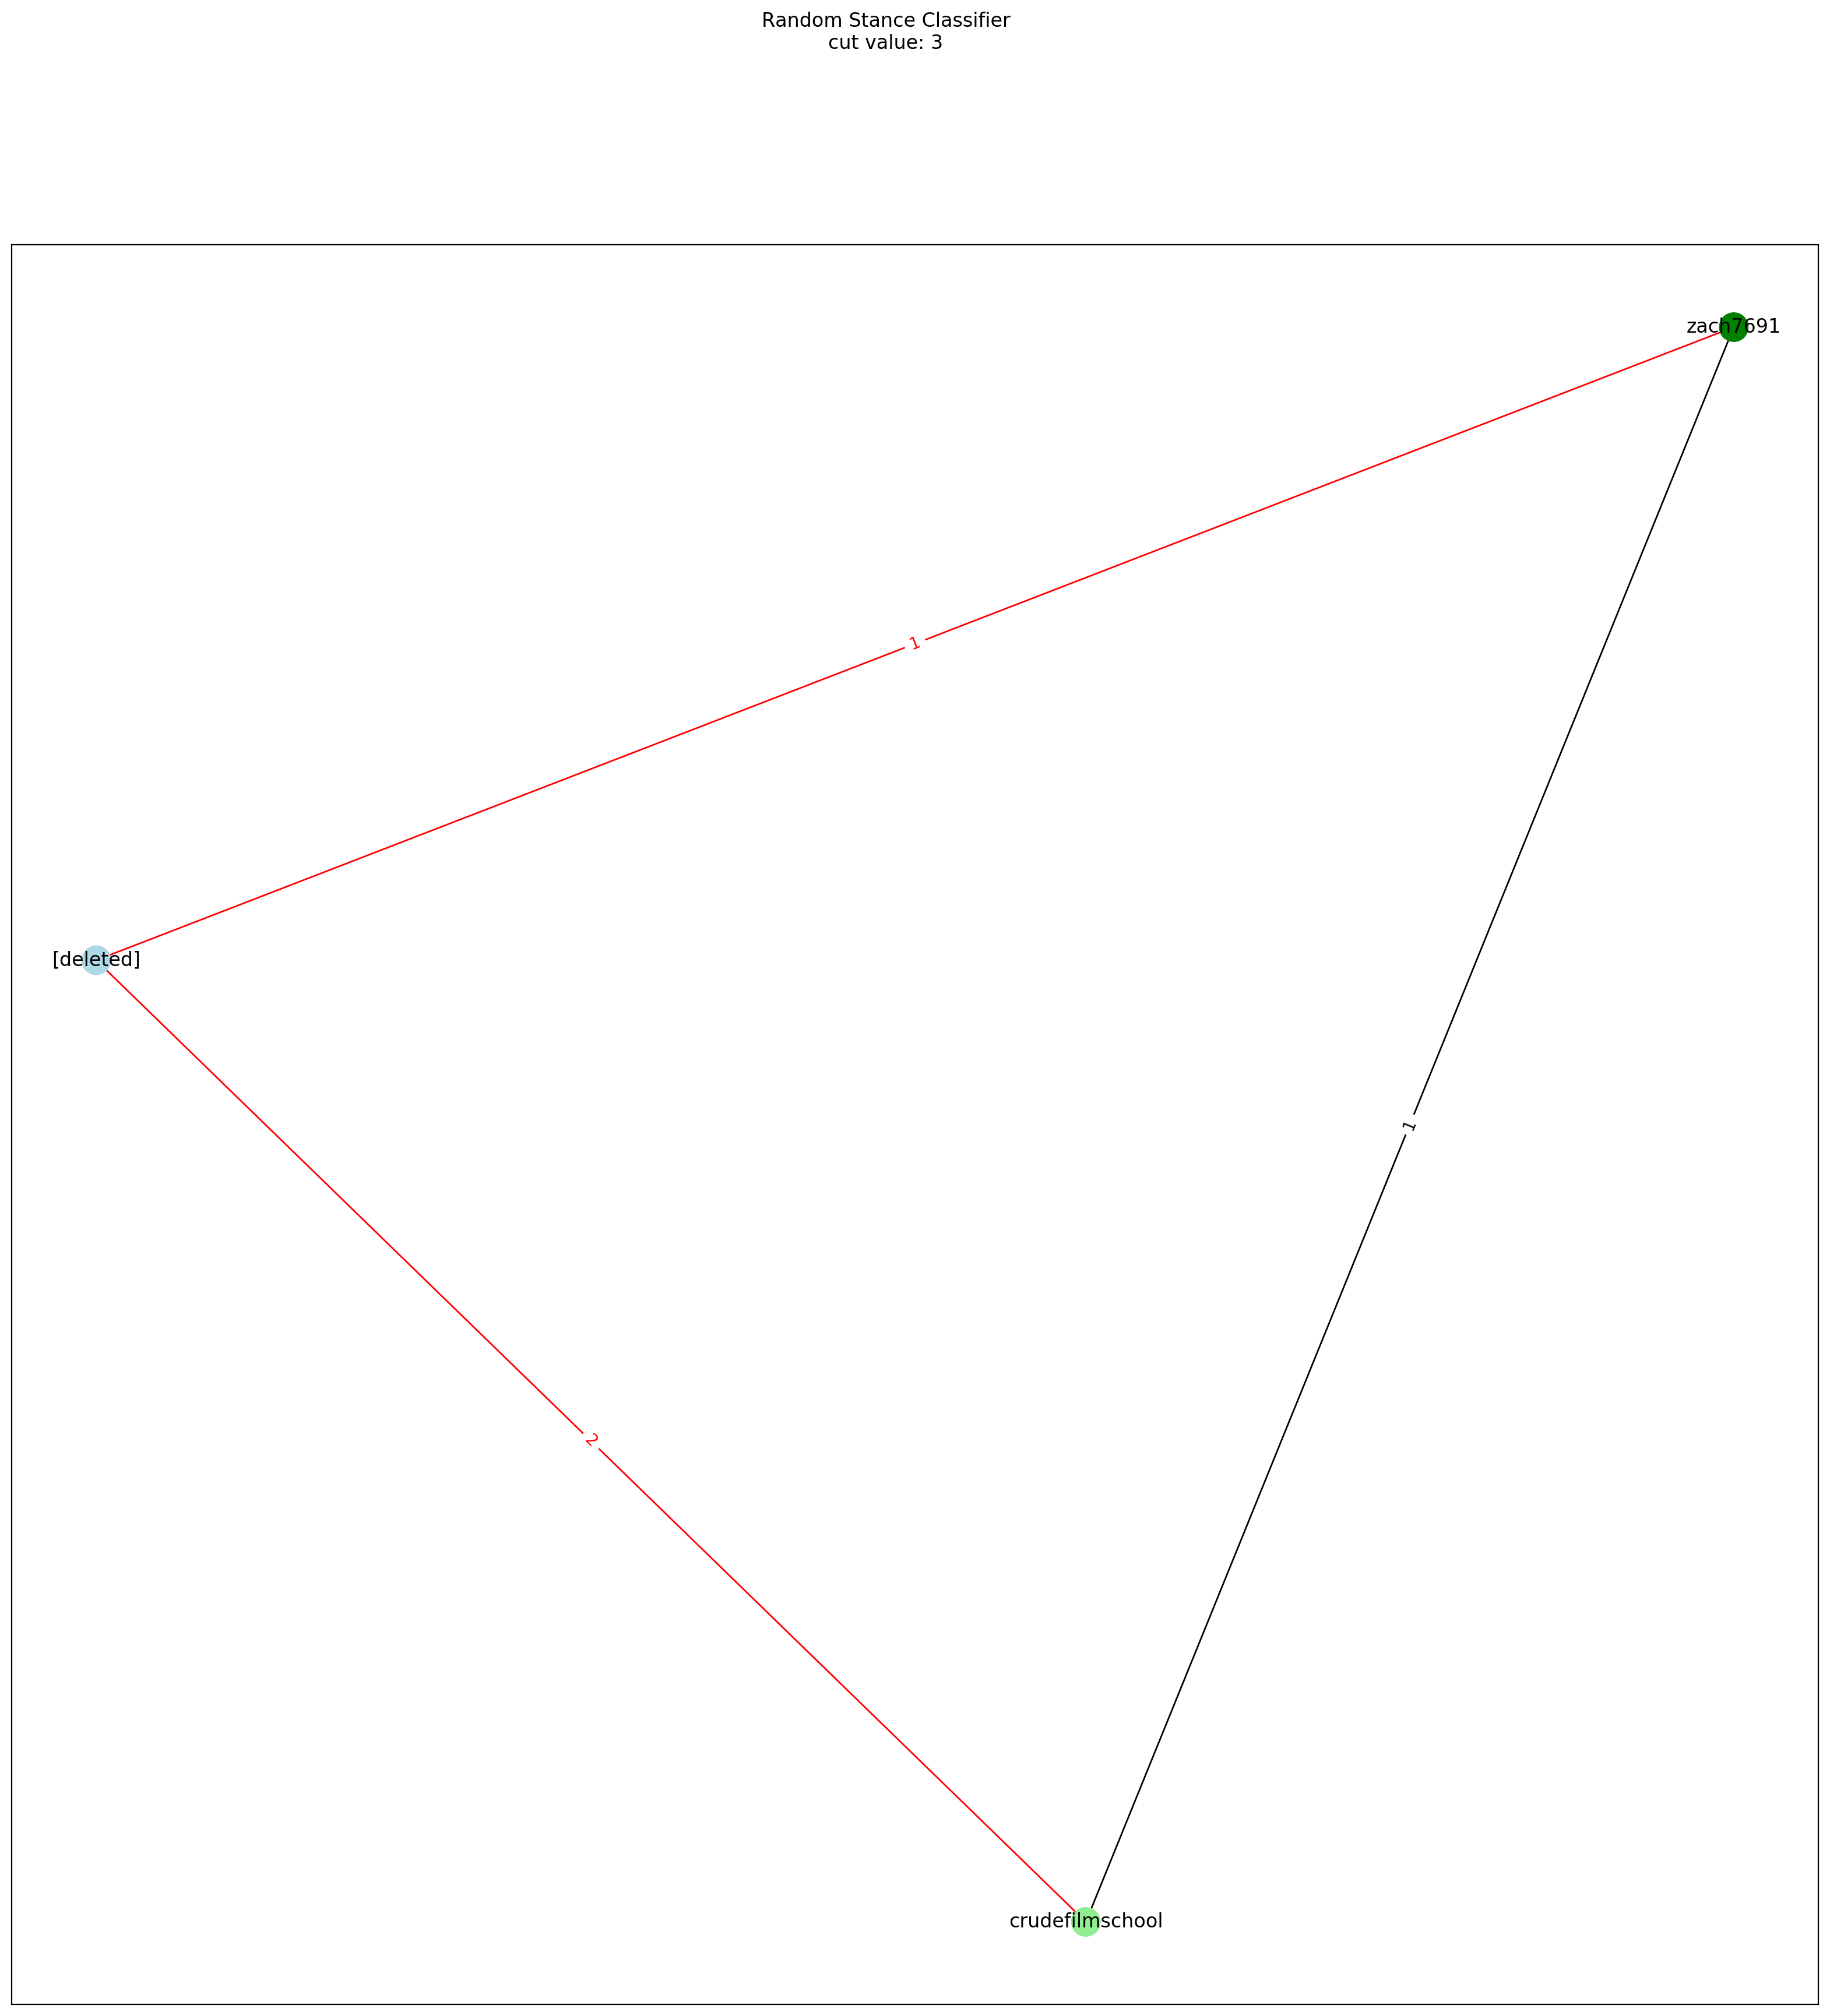

7gqgq9


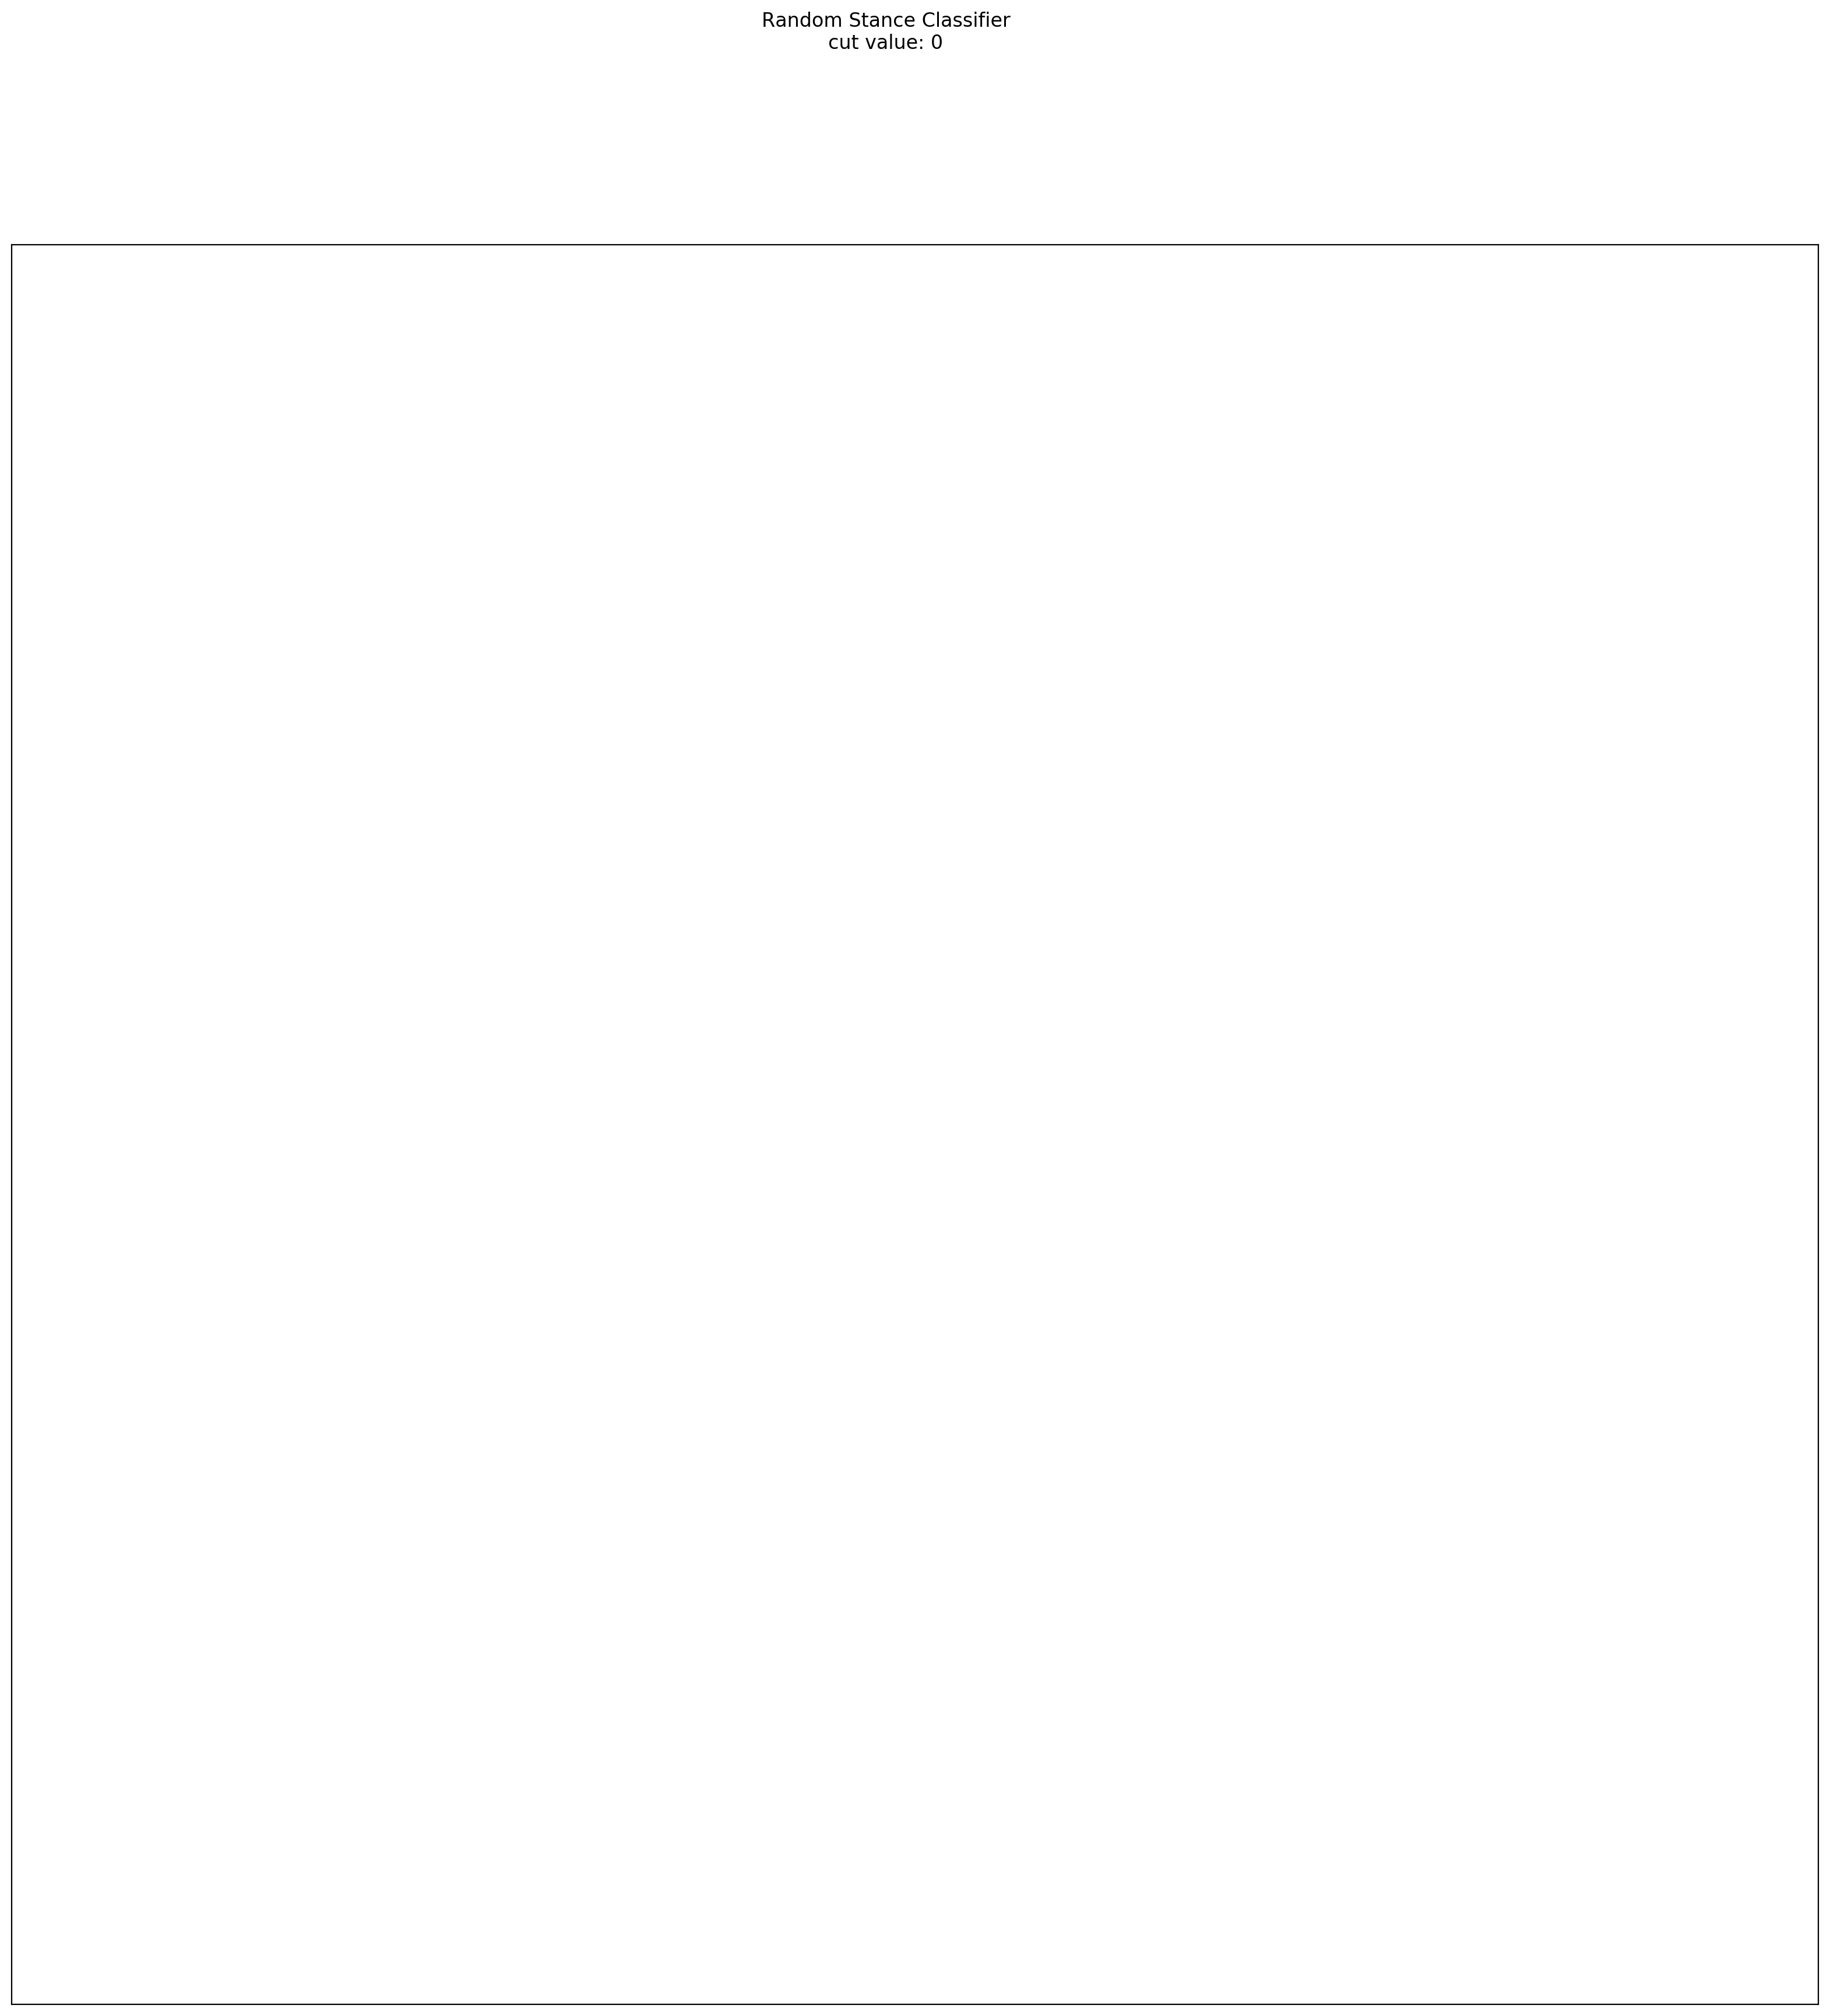

6em11w


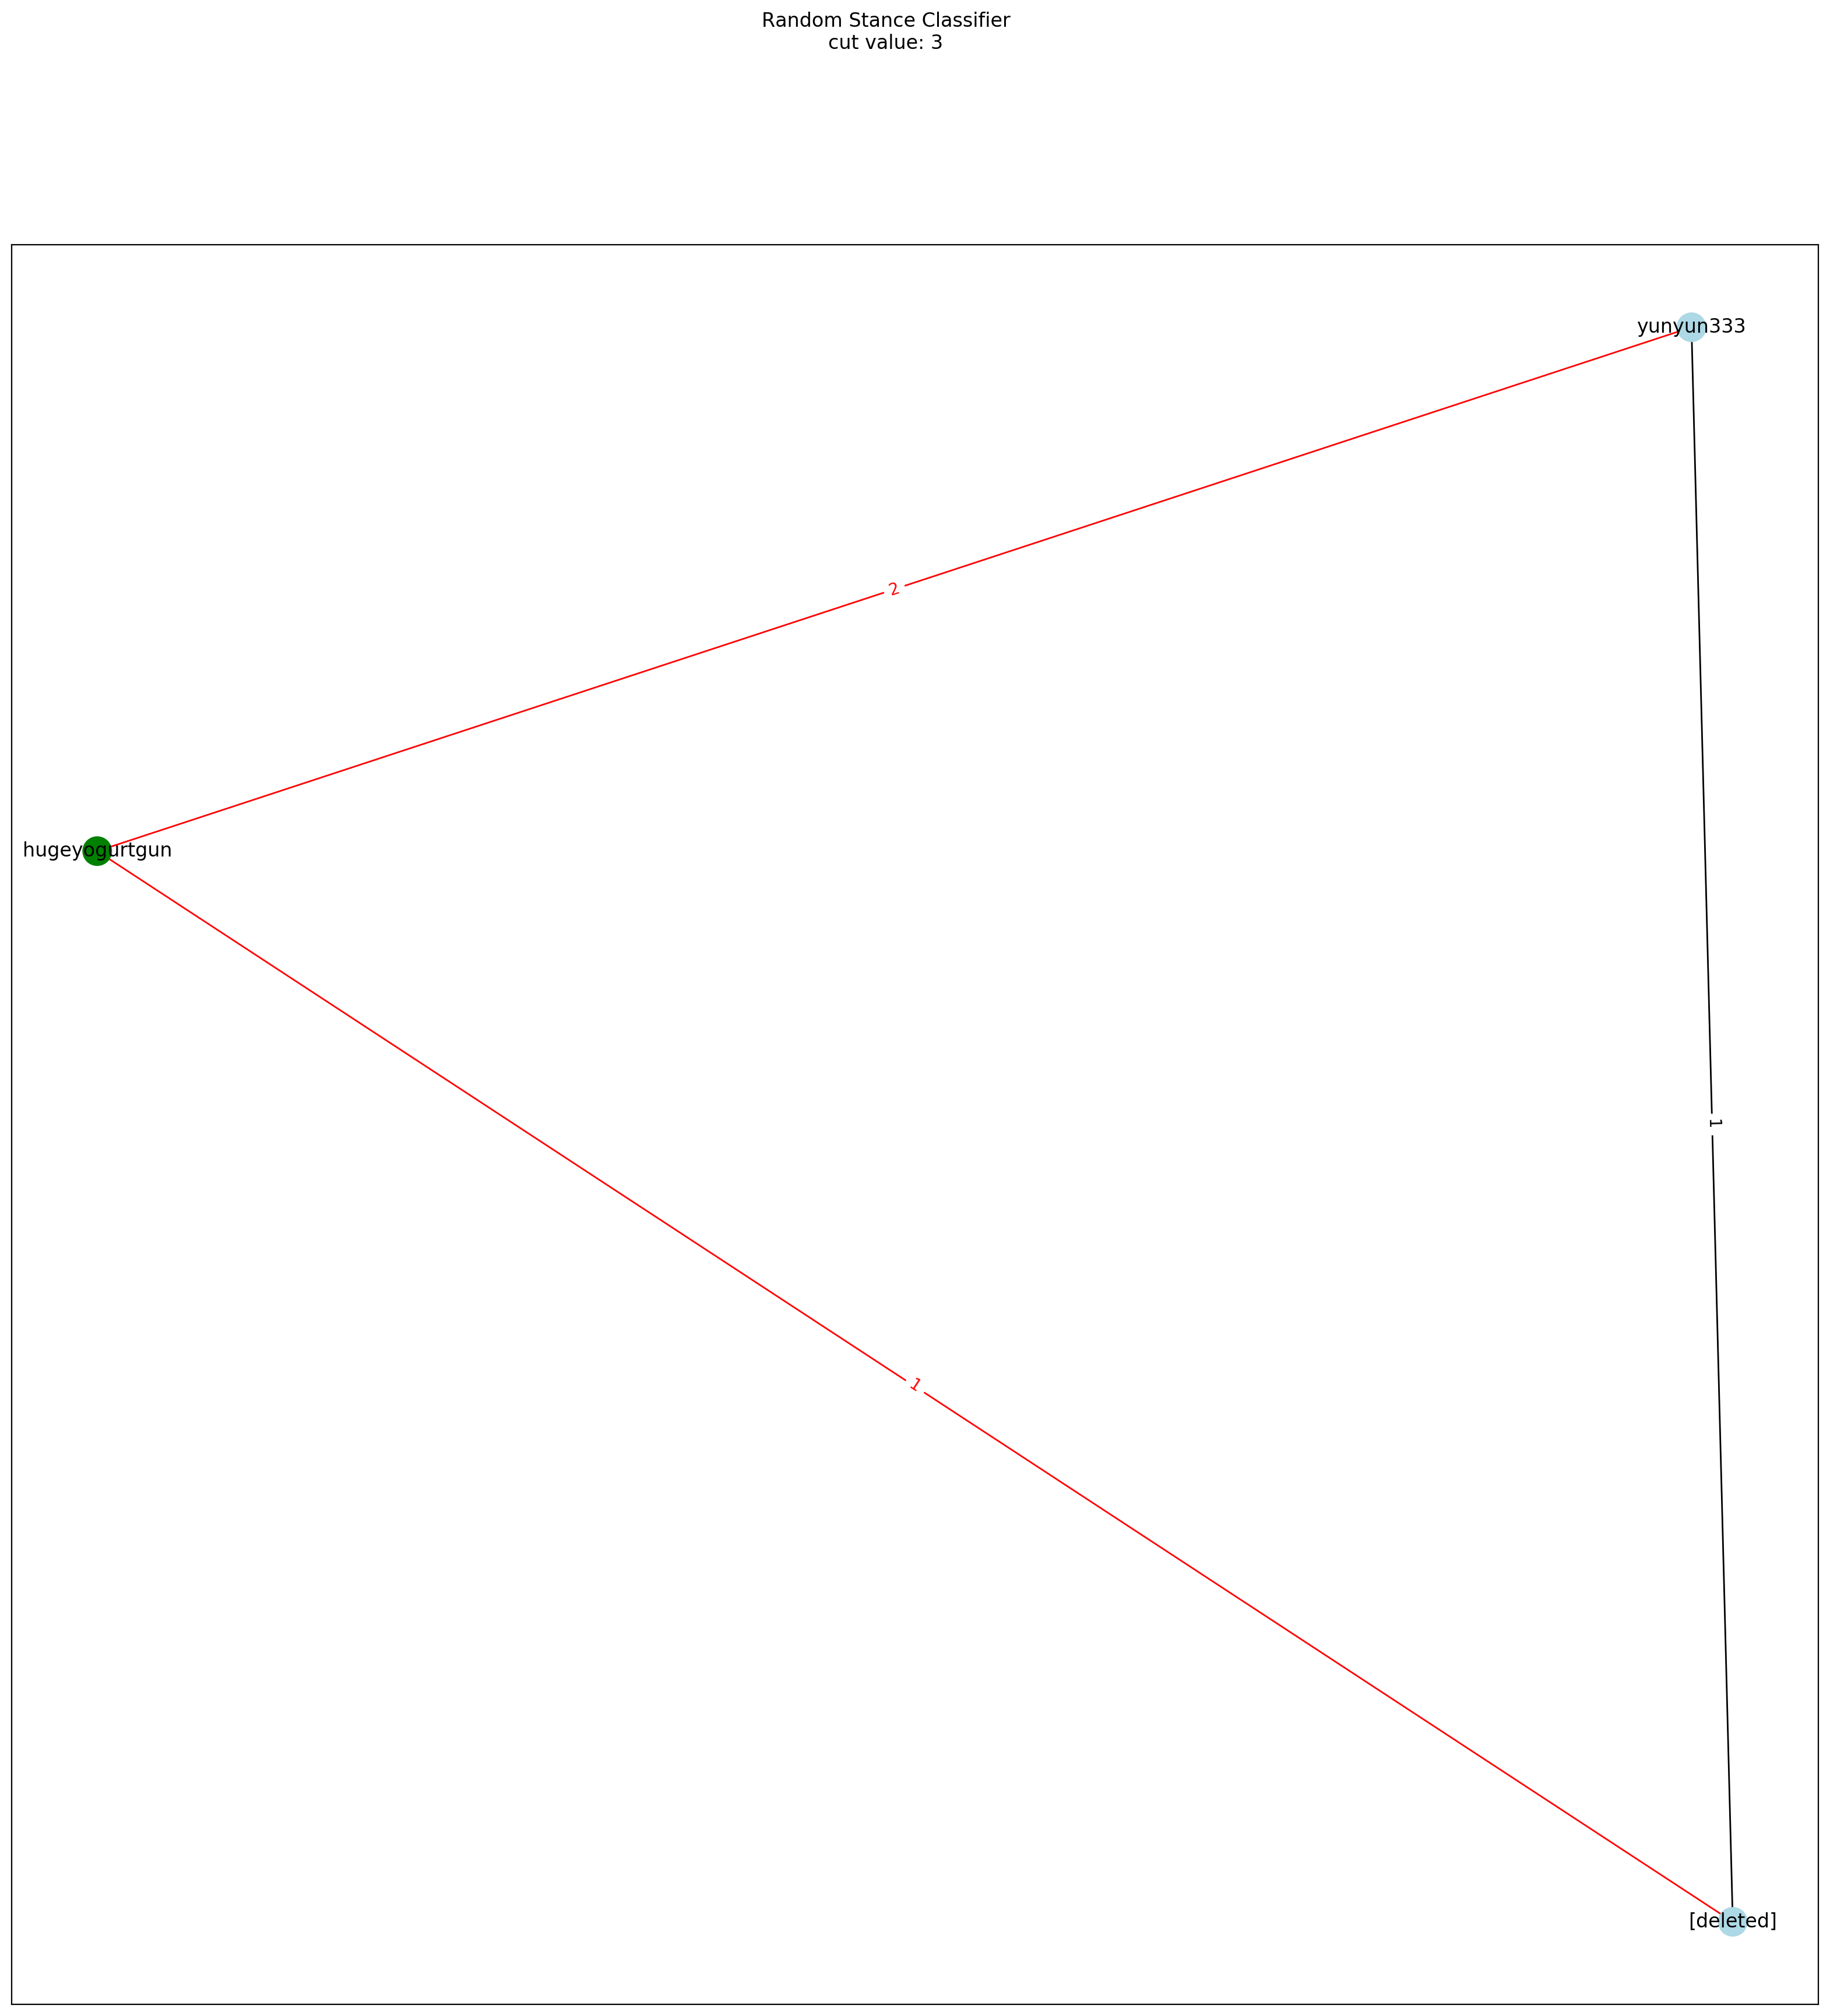

6nsxni


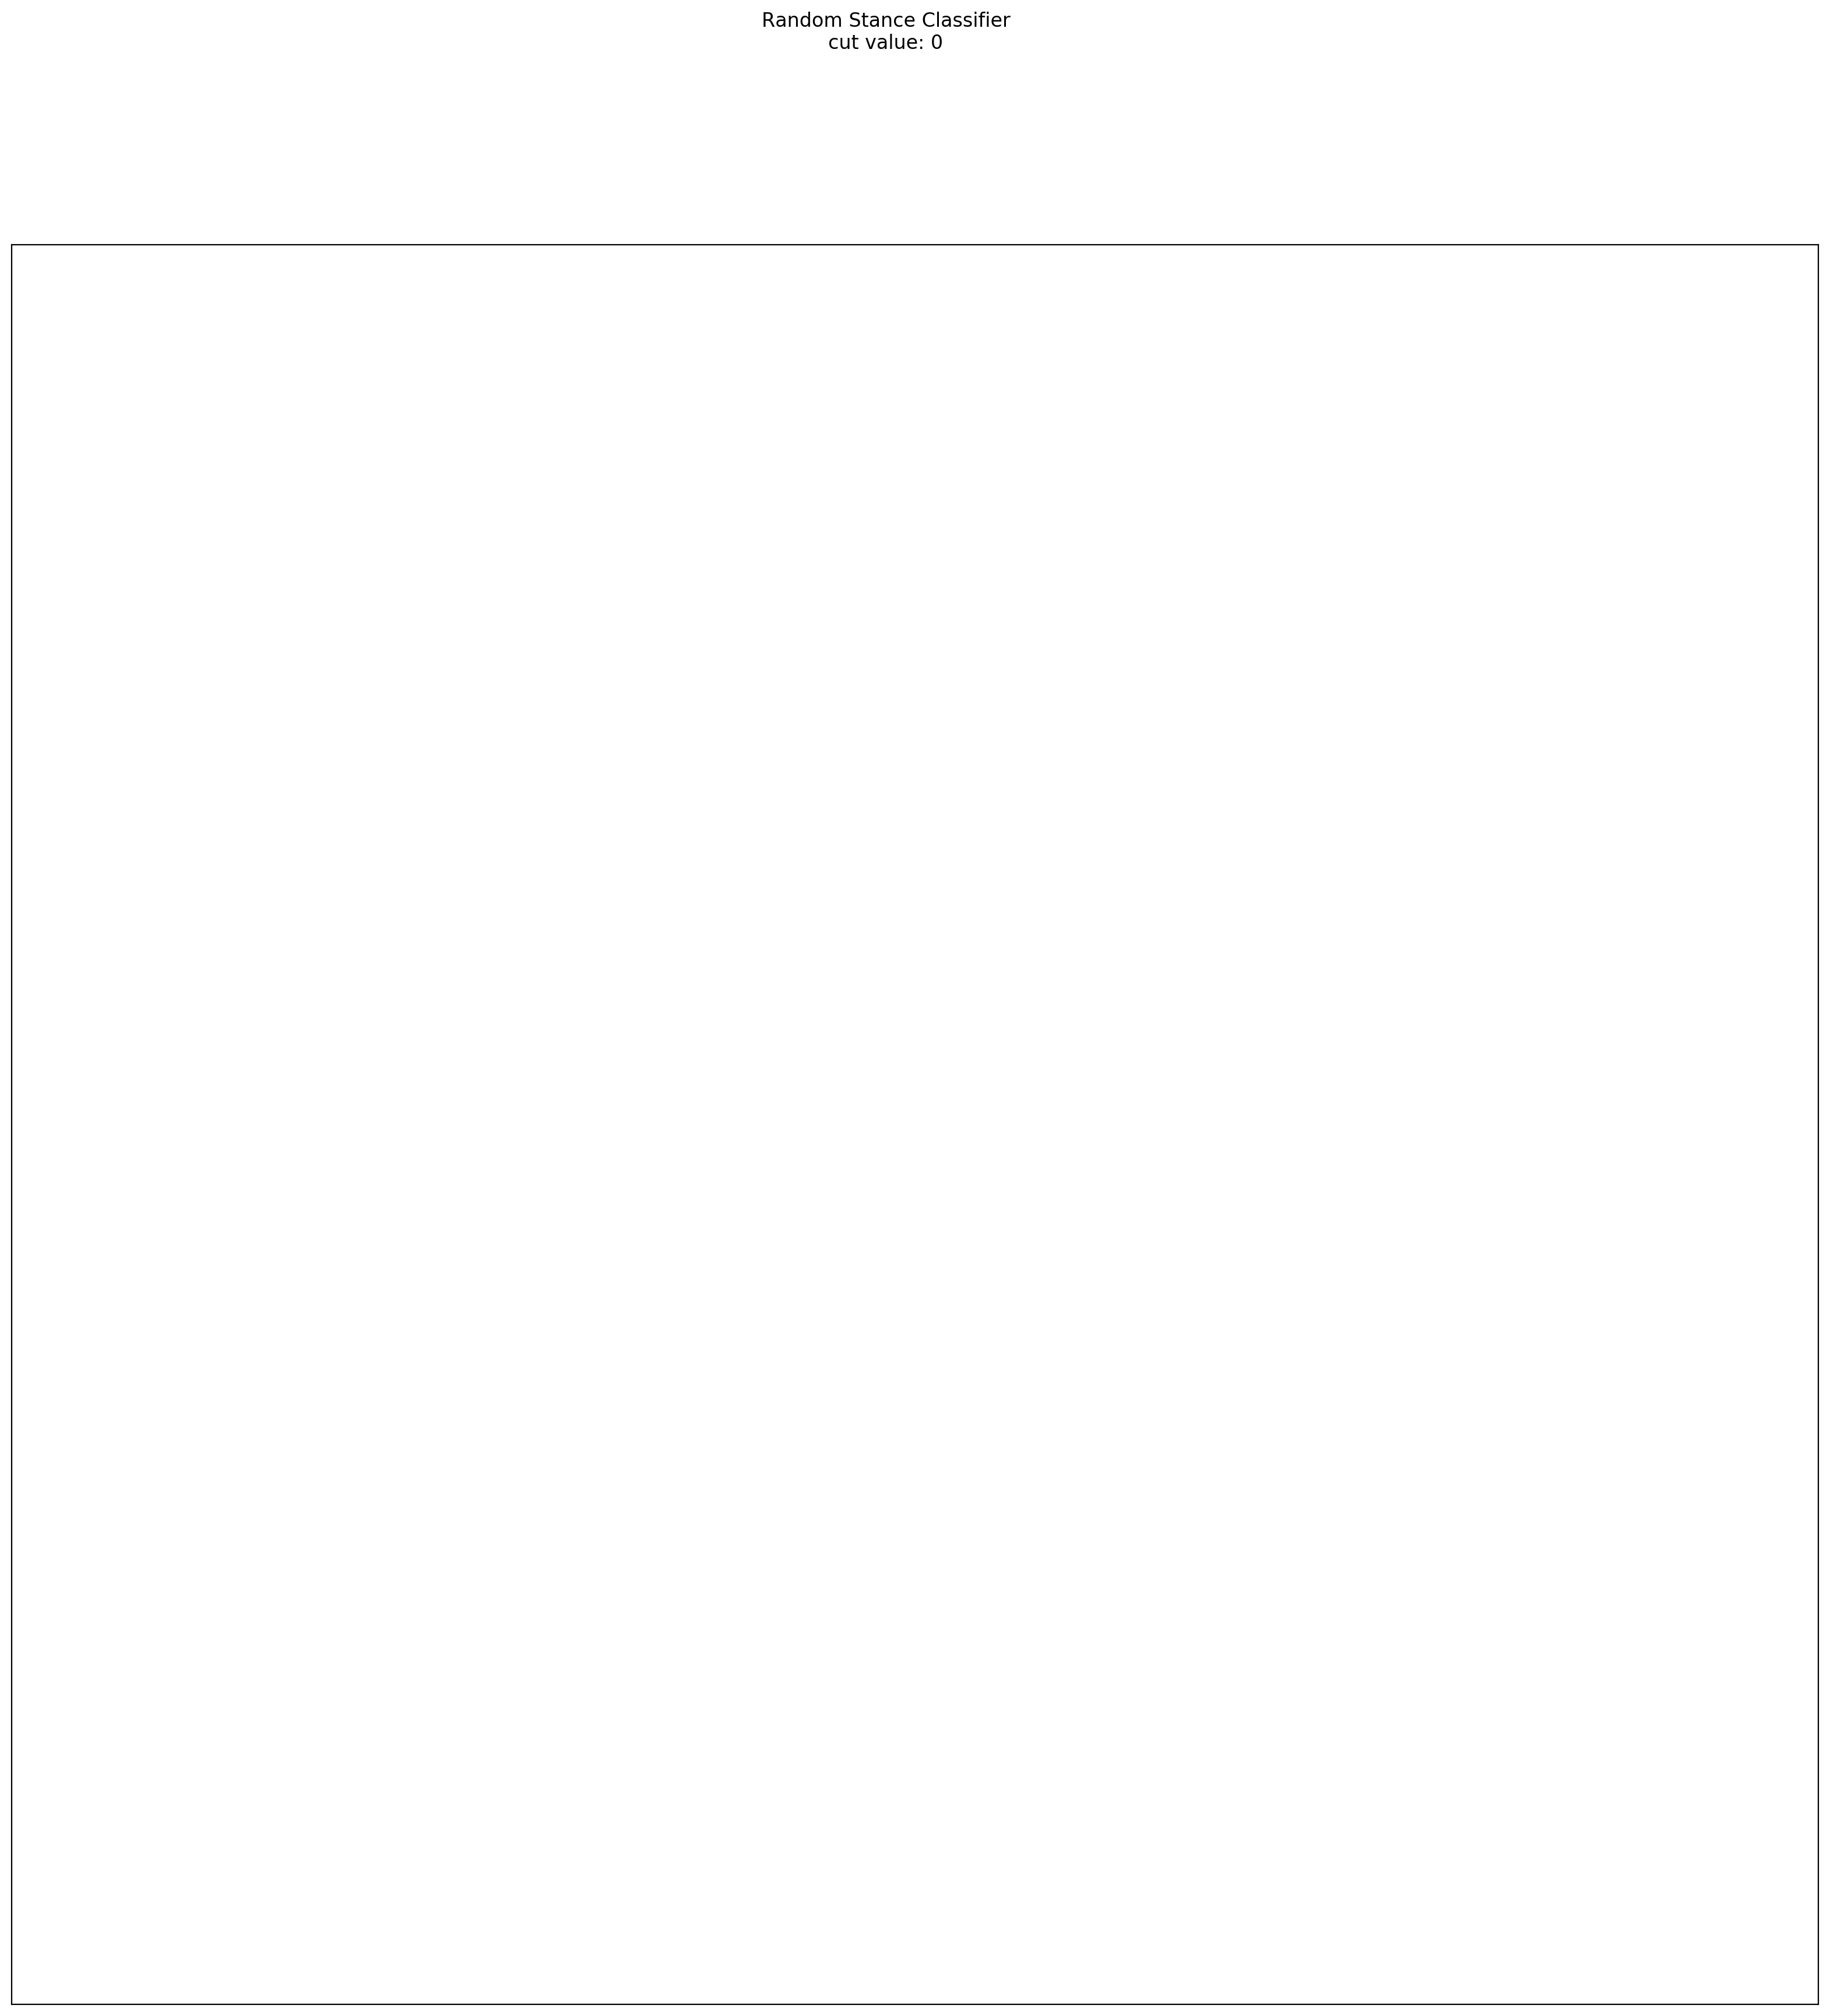

72gojp


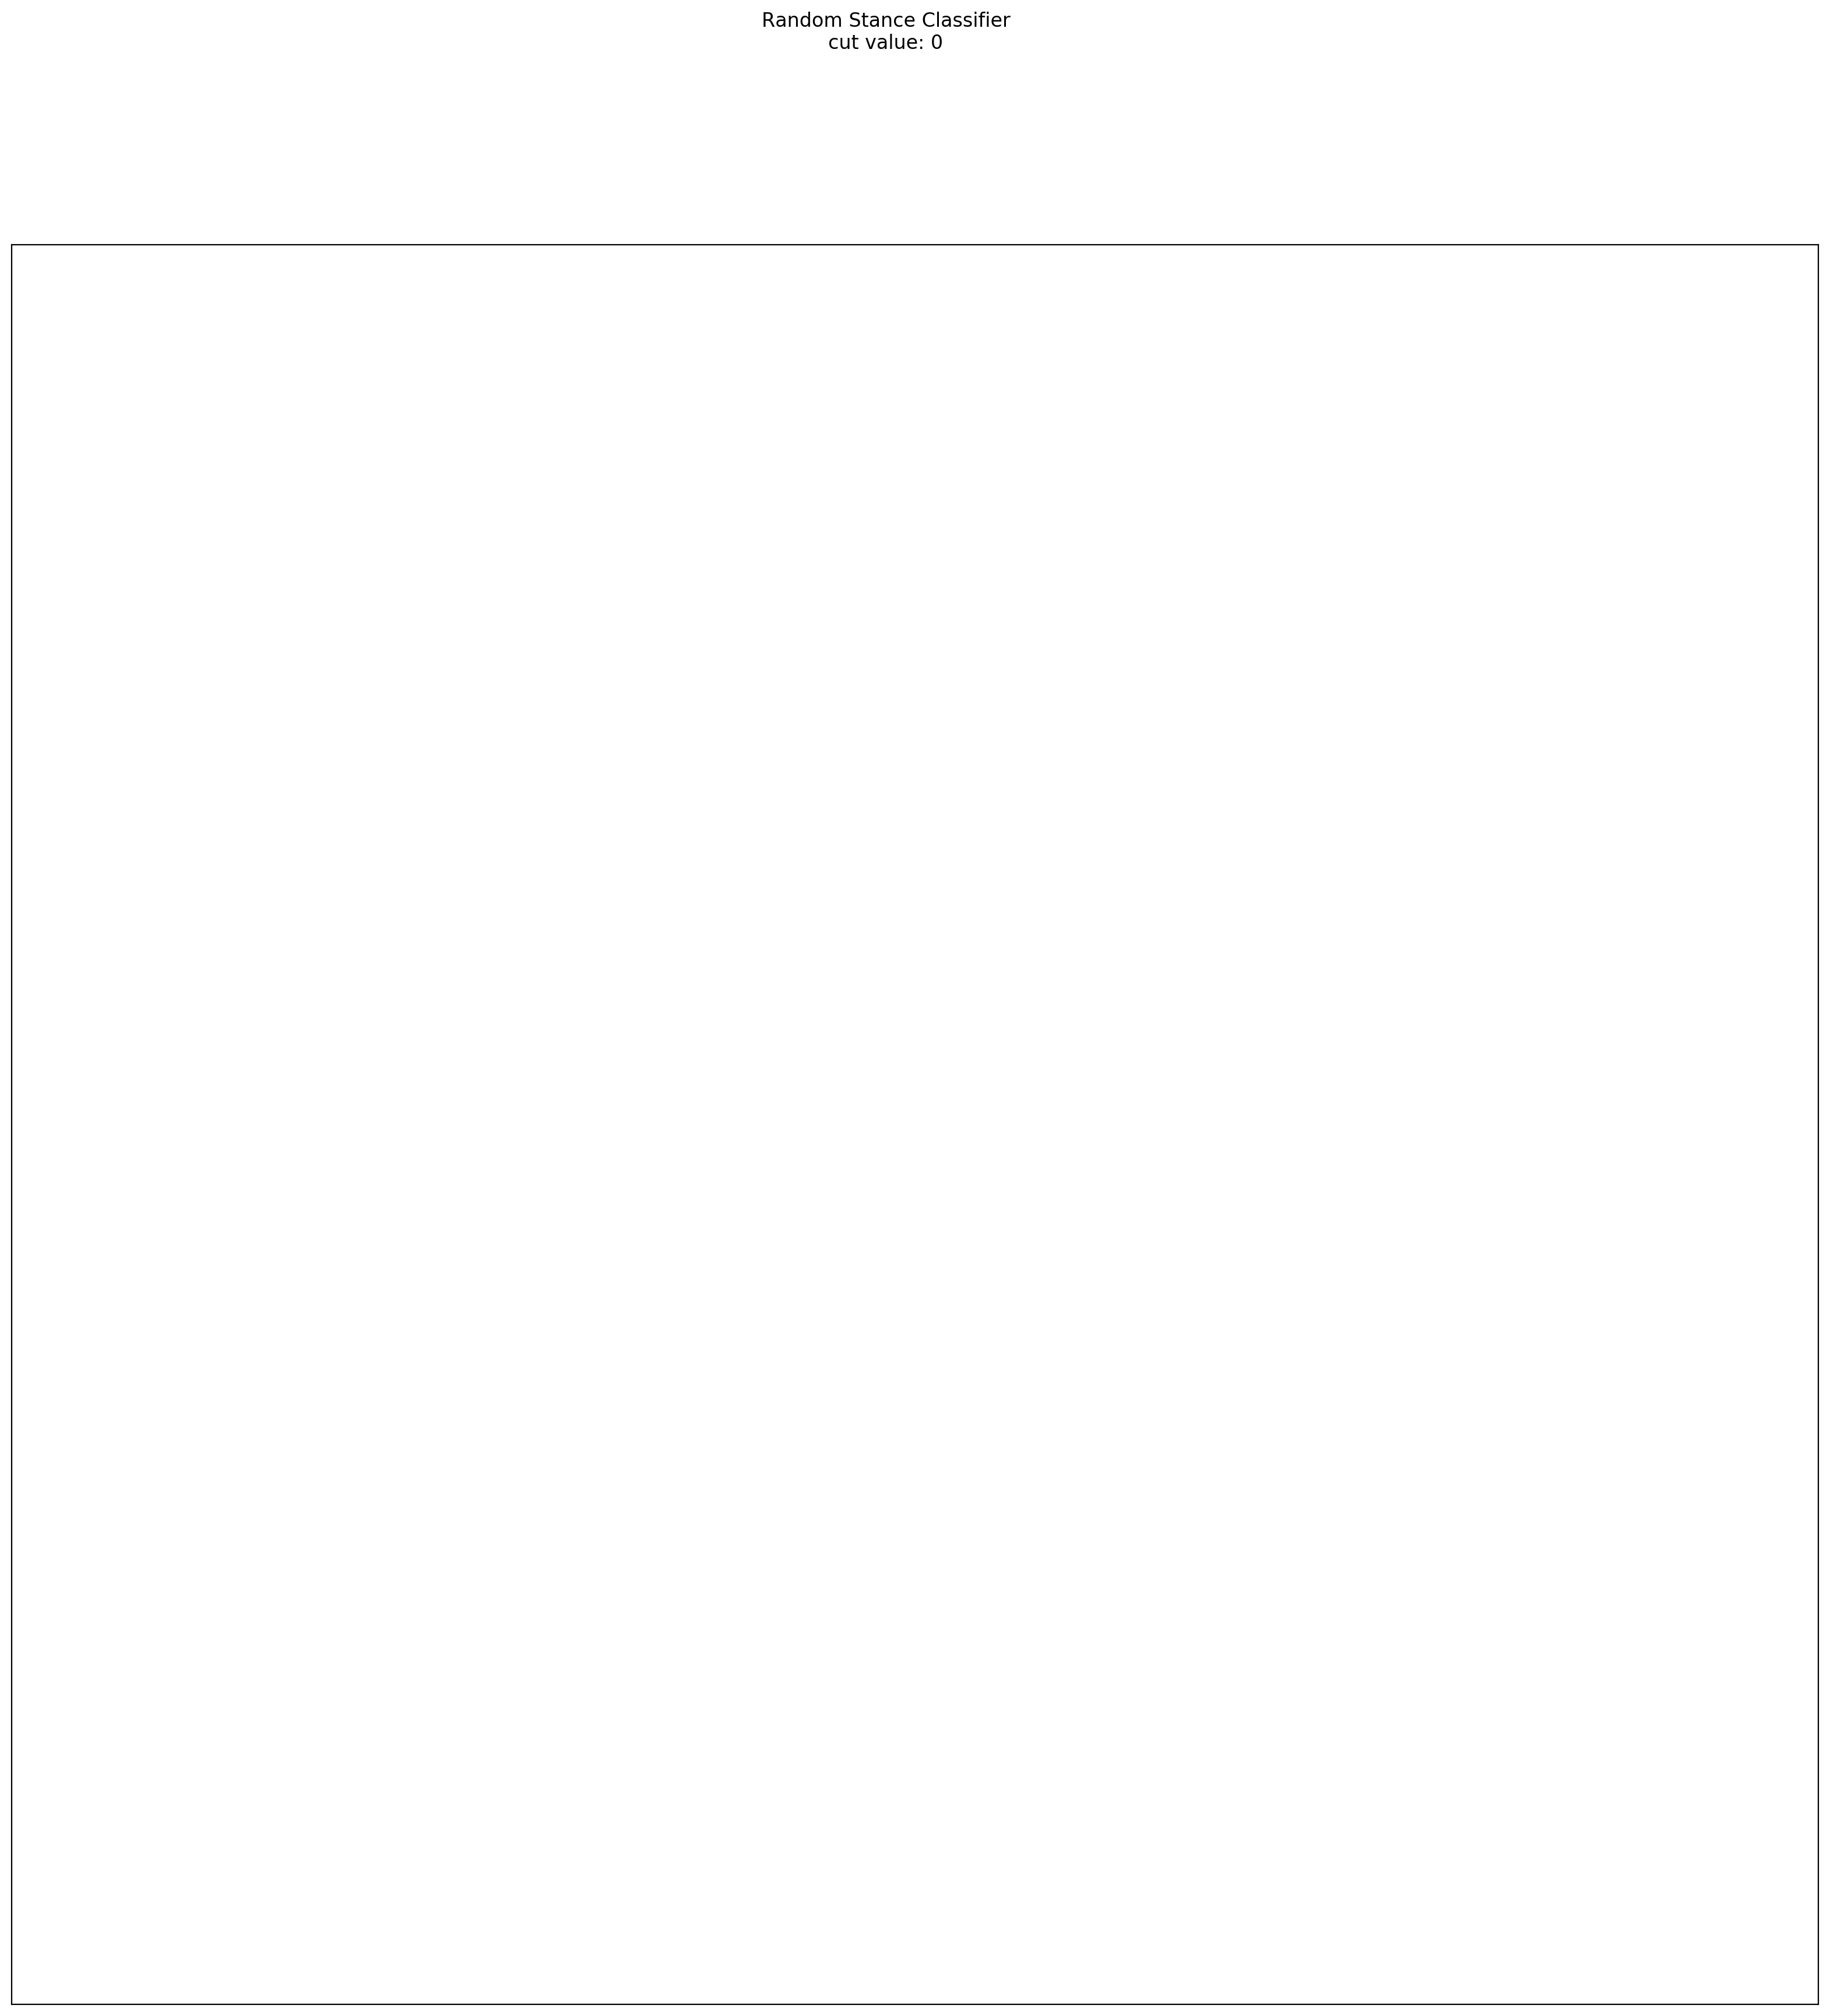

4rumij


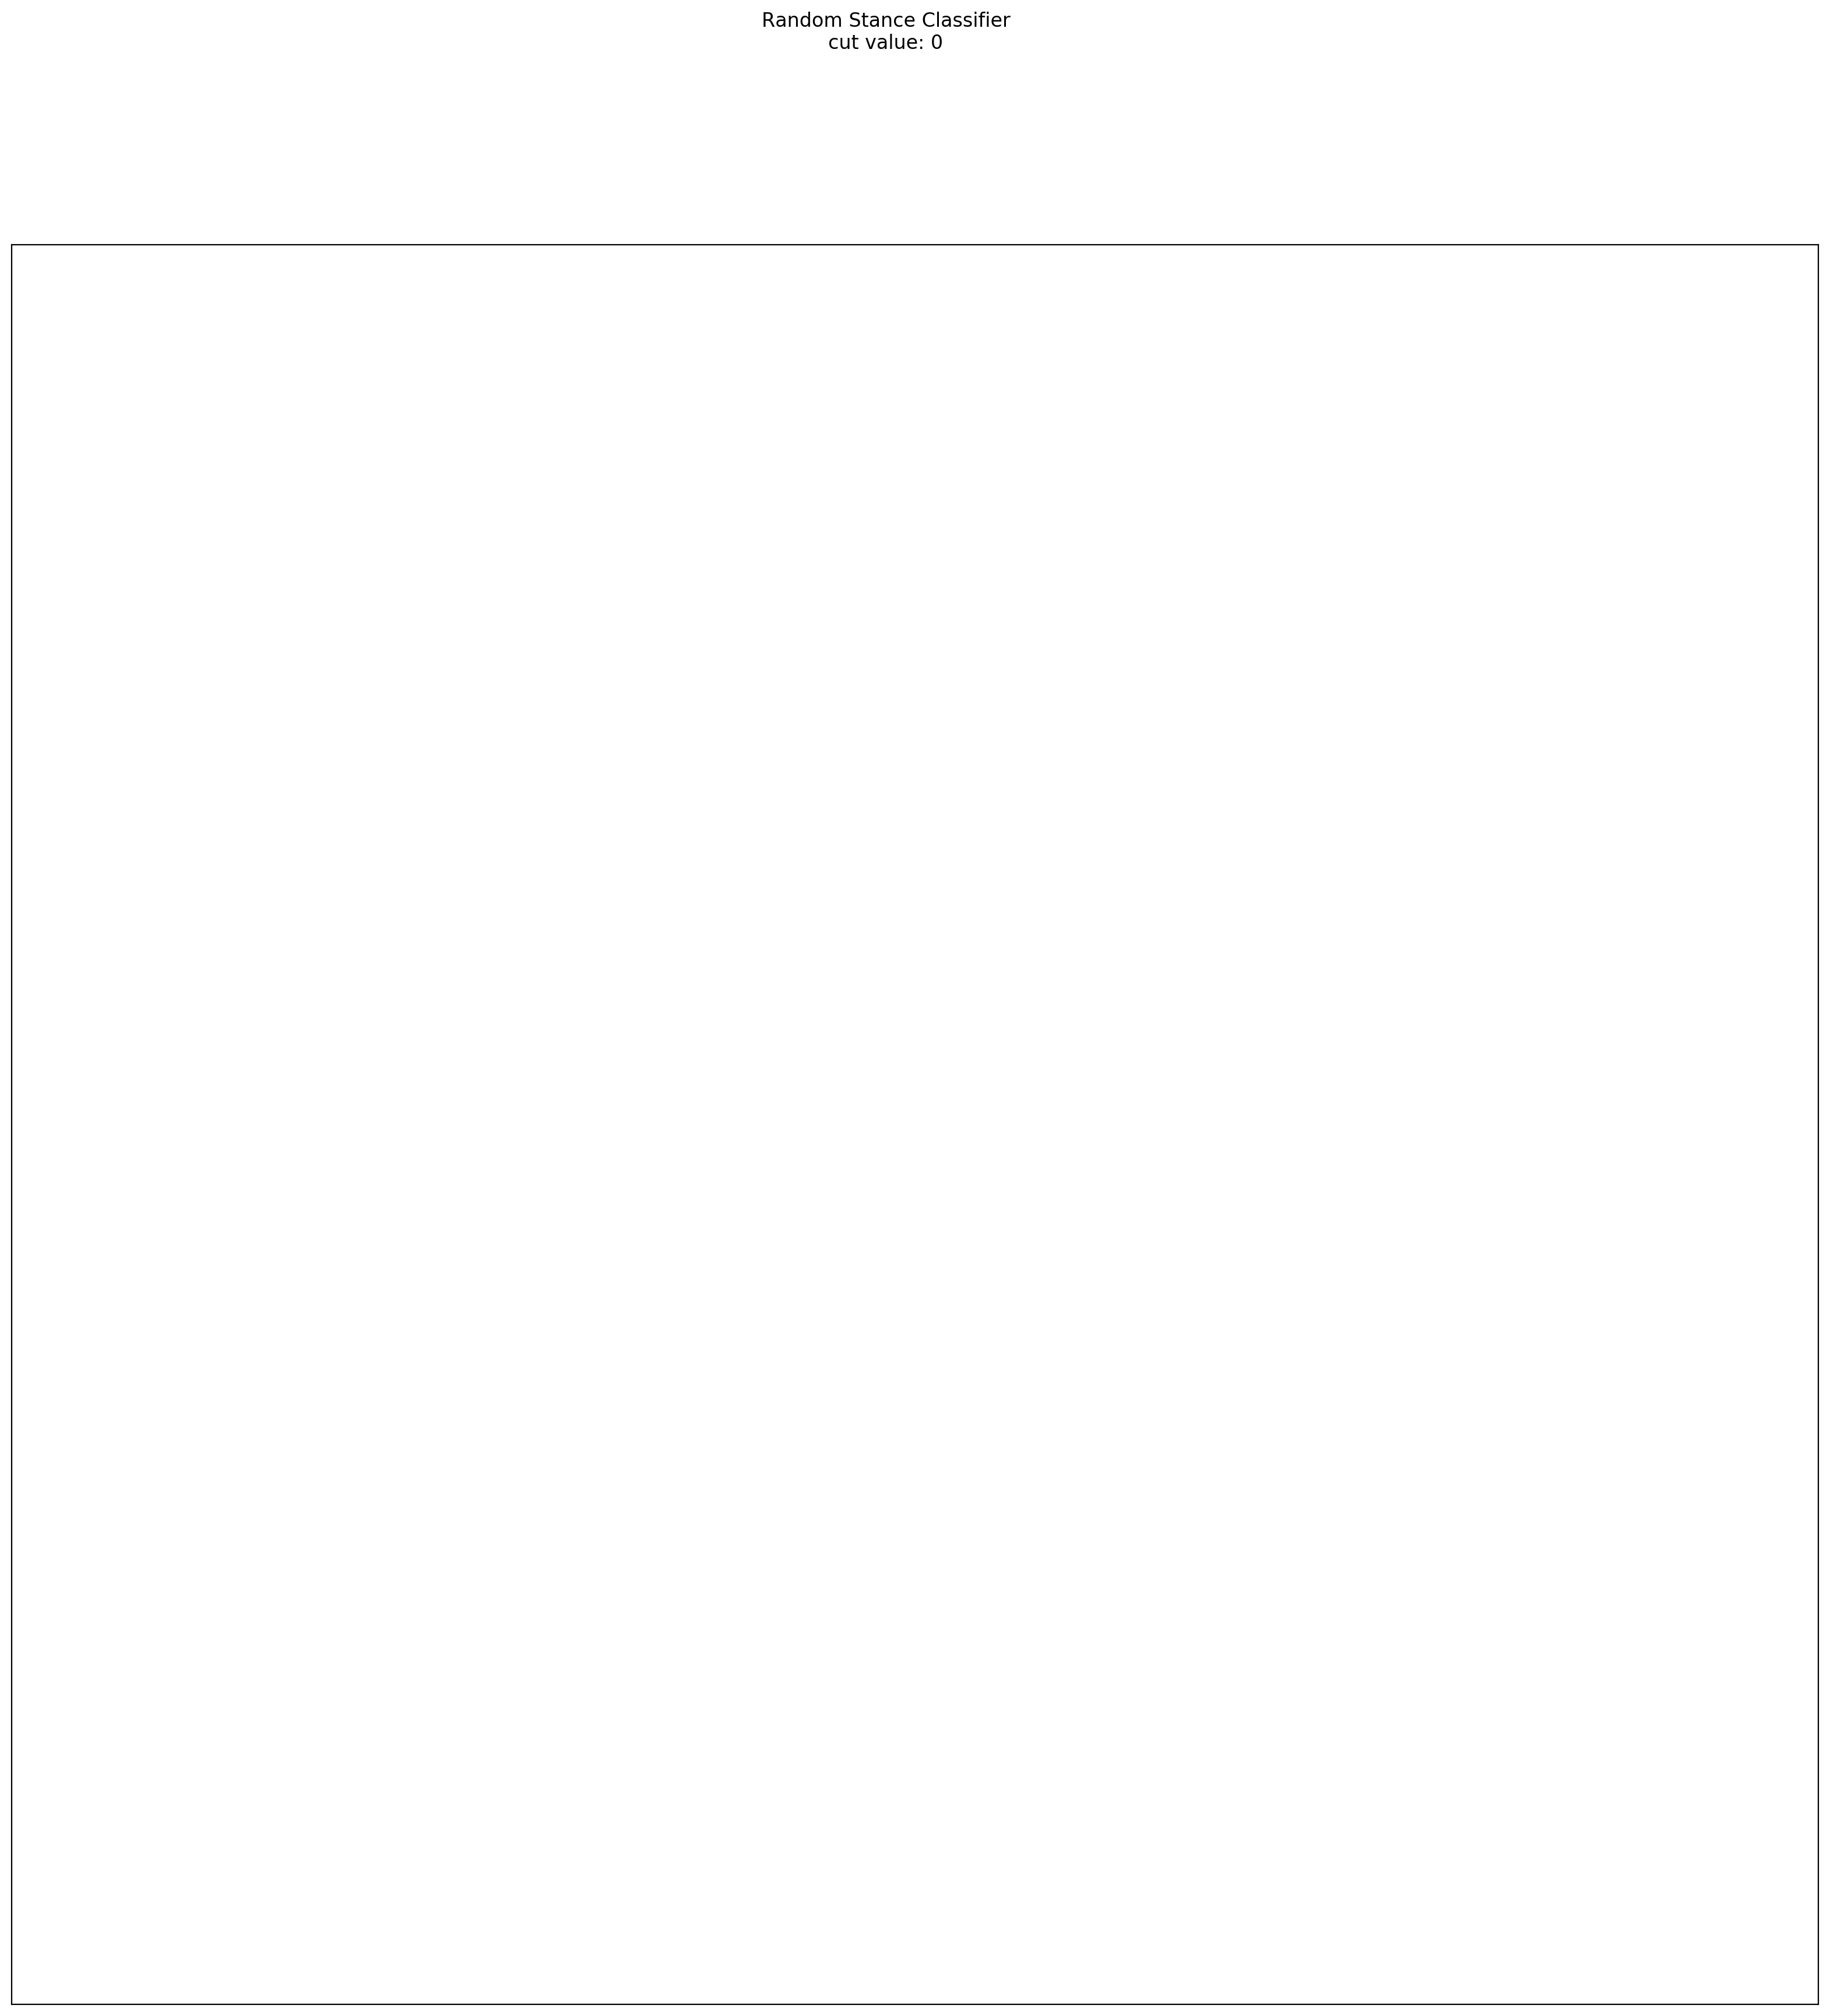

6gr55w


KeyboardInterrupt: 

In [45]:
rumers_author_stance = []
for conversation in tqdm(conversations):
    reply_interactions_parser = get_reply_interactions_parser()
    interaction_graph = reply_interactions_parser.parse(conversation)
    interaction_graph.get_core_interactions(inplace=True)
    if interaction_graph.graph.order() < 50:
        interaction_graph.set_interaction_weights(lambda x: x['replies'])
        maxcut = MaxcutStanceClassifier()
        maxcut.set_input(interaction_graph.graph)
        op = conversation.root.author
        maxcut.classify_stance(op)
        print(conversation.id)
        maxcut.draw()
        for supporter in maxcut.supporters:
            row = {'conversation_id': conversation.id,
                   'op': conversation.op,
                   'author': supporter,
                   'stance': 'supporter'}
            rumers_author_stance.append(row)
        for opposer in maxcut.complement:
            row = {'conversation_id': conversation.id,
                   'op': conversation.op,
                   'author': supporter,
                   'stance': 'opposer'}
            rumers_author_stance.append(row)

In [15]:
len(rumers_author_stance)

52288

In [16]:
user_stance_rumors = pd.DataFrame(rumers_author_stance)
user_stance_rumors

,conversation_id,op,author,stance
0,7f30fw,TBSchemer,Mtl325,supporter
1,7f30fw,TBSchemer,TBSchemer,supporter
2,7f30fw,TBSchemer,whillykers,supporter
3,7f30fw,TBSchemer,whillykers,opposer
4,7f30fw,TBSchemer,whillykers,opposer
...,...,...,...,...
52283,6p9ano,[deleted],DeltaBot,opposer
52284,6p9ano,[deleted],DeltaBot,opposer
52285,6p9ano,[deleted],DeltaBot,opposer
52286,6p9ano,[deleted],DeltaBot,opposer


In [ ]:
user_stance_rumors.to_csv('cmv_results_afer_maxcut.csv')

In [ ]:
user_stance_rumors.dtypes

In [ ]:
user_stance_rumors.conversation_id.nunique()

## Gold Standard

In [ ]:
path = r"C:\Users\ronp\Documents\stance-classification\rumors_dataset\pheme-rumour-scheme-dataset\annotations\en-scheme-annotations.json"
# path = "/Users/shaimeital/code/thesis/cmv-stance-classification/Examples/en-scheme-annotations_clean.jsonl"
rumors_gold_label = pd.read_json(path, lines = True)
rumors_gold_label


In [ ]:
rumors_gold_label['responsetype-vs-source'].value_counts()

In [ ]:
rumors_gold_label = rumors_gold_label.filter(['threadid', 'tweetid', 'responsetype-vs-source'], axis=1).rename({'responsetype-vs-source': 'label'}, axis=1)
rumors_gold_label

In [ ]:
rumors_gold_label.threadid = rumors_gold_label.threadid.astype('str') 

In [ ]:
rumors_gold_label.tweetid = rumors_gold_label.tweetid.astype('str') 

In [ ]:
rumors_gold_label.dtypes

In [ ]:
convs_a = convs_.filter(['threadid', 'tweetid', 'author'], axis=1)
convs_a

In [ ]:
convs_a.dtypes

In [ ]:
rumors_gold_label_ = rumors_gold_label.merge(convs_a, how = 'left', on=['threadid', 'tweetid'])
rumors_gold_label_

In [ ]:
rumors_gold_label_.author.isna().sum()

In [ ]:
rumors_gold_label_nona = rumors_gold_label_.dropna()
rumors_gold_label_nona

In [ ]:
user_stance_rumors = user_stance_rumors.rename({'conversation_id': 'threadid', 'stance':'stance_prediction'}, axis=1)
user_stance_rumors

In [ ]:
predictions = user_stance_rumors.merge(rumors_gold_label_nona, how='left', on = ['threadid', 'author'])
predictions

In [ ]:
predictions_ = predictions.dropna()
predictions_

In [ ]:
predictions_.loc[(predictions_.stance_prediction == 'supporter') & (predictions_.label == 'agreed') ]

In [ ]:
predictions_.loc[(predictions_.stance_prediction == 'opposer') & (predictions_.label == 'disagreed') ]

In [ ]:
predictions_.loc[(predictions_.stance_prediction == 'supporter') & (predictions_.label == 'disagreed') ]

In [ ]:
predictions_.loc[(predictions_.stance_prediction == 'opposer') & (predictions_.label == 'agreed') ]

## Gold standard for CMV

In [20]:
cmv_truth = pd.read_csv('stance-gs-extended.csv')
cmv_truth.head()

,tree_id,username,label
0,4rl42j,ThatBelligerentSloth,1
1,4rl42j,Hq3473,-1
2,4rl42j,Mintnose,-1
3,4rl42j,Octobers_second_one,-1
4,4rl42j,yaxamie,1


In [26]:
evaluation = cmv_truth.merge(user_stance_rumors, how='inner', left_on = ['tree_id', 'username'],
                right_on = ['conversation_id', 'author'])
evaluation.head()

,tree_id,username,label,conversation_id,op,author,stance
0,4rl42j,ThatBelligerentSloth,1,4rl42j,Slagernicus,ThatBelligerentSloth,supporter
1,4rl42j,EmilyRose607,-1,4rl42j,Slagernicus,EmilyRose607,supporter
2,4rl42j,Gladix,1,4rl42j,Slagernicus,Gladix,supporter
3,4rl42j,Letshavemorefun,1,4rl42j,Slagernicus,Letshavemorefun,supporter
4,4rl42j,gorkt,1,4rl42j,Slagernicus,gorkt,supporter


In [31]:
evaluation.stance.value_counts()

opposer      78
supporter    49
Name: stance, dtype: int64

In [30]:
len(evaluation)

127

In [29]:
evaluation.loc[(evaluation.label == 1) & (evaluation.stance == 'supporter')].count()

tree_id            38
username           38
label              38
conversation_id    38
op                 38
author             38
stance             38
dtype: int64

In [33]:
evaluation.loc[(evaluation.label ==-1) & (evaluation.stance == 'opposer')].count()

tree_id            29
username           29
label              29
conversation_id    29
op                 29
author             29
stance             29
dtype: int64

In [34]:
evaluation.loc[(evaluation.label ==-1) & (evaluation.stance == 'supporter')].count()

tree_id            11
username           11
label              11
conversation_id    11
op                 11
author             11
stance             11
dtype: int64

In [35]:
evaluation.loc[(evaluation.label ==1) & (evaluation.stance == 'opposer')].count()

tree_id            49
username           49
label              49
conversation_id    49
op                 49
author             49
stance             49
dtype: int64

## Extra for TSNE + PCA

In [ ]:
# data = pd.DataFrame.from_records(features, index="conv_id")
# print(data.head())

In [ ]:
data_ = data.loc[data.num_nodes > 10]

In [ ]:
data_.count()

In [ ]:
data_

In [ ]:
data_.describe()

In [ ]:
data_ = data_.fillna(0)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


In [ ]:
standardized_data = StandardScaler().fit_transform(data_)
print(standardized_data.shape)

In [ ]:
model = TSNE(n_components=2, random_state=0)

In [ ]:
tsne_data = model.fit_transform(standardized_data)

In [ ]:
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2"))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
sns.FacetGrid(tsne_df, height=9).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN


In [ ]:
m = DBSCAN()


In [ ]:
m.fit(standardized_data)

In [ ]:
clusters = m.labels_

In [ ]:
pd.Series(clusters).value_counts()

In [ ]:
# pca

from sklearn.decomposition import PCA


In [ ]:
pca = PCA(n_components=2)


In [ ]:
principalComponents = pca.fit_transform(standardized_data)

In [ ]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [ ]:
sns.FacetGrid(principalDf, height=6).map(plt.scatter, 'principal component 1', 'principal component 2').add_legend()
plt.show()